<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-07-20 19:36:26.730319: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-20 19:36:26.761736: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-20 19:36:26.761764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-20 19:36:26.762784: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-20 19:36:26.768118: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-20 19:36:26.768611: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-20 19:36:27.500774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-07-20 19:36:29.832065: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 90ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

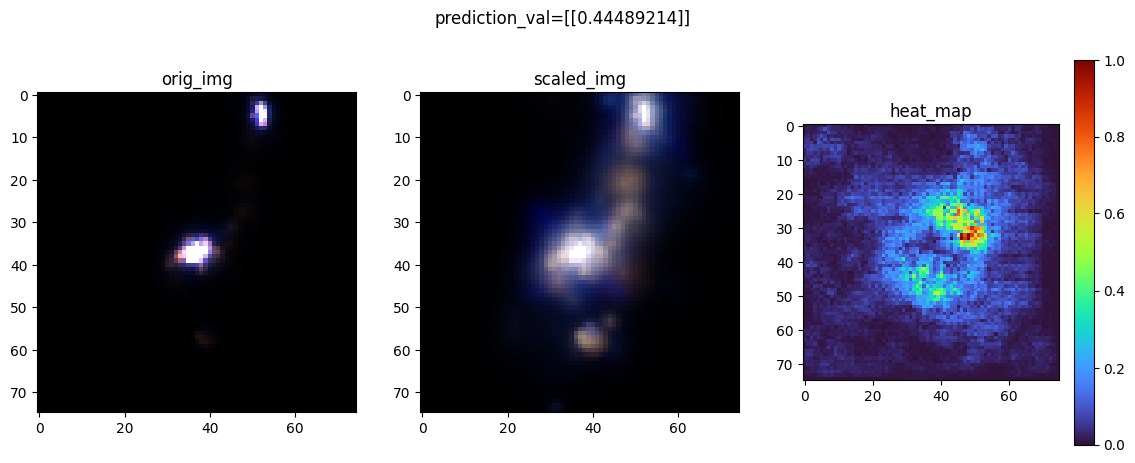

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

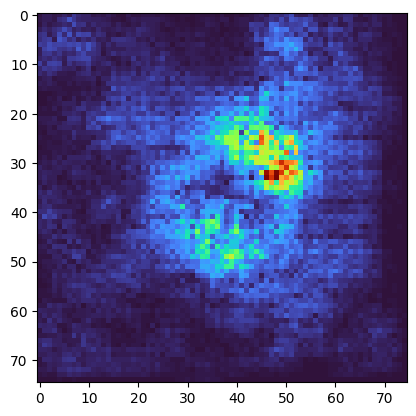

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-07-20 19:36:32.793797: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-20 19:36:33.628274: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-20 19:36:33.699286: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-20 19:36:33.741893: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-20 19:36:35.195061: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

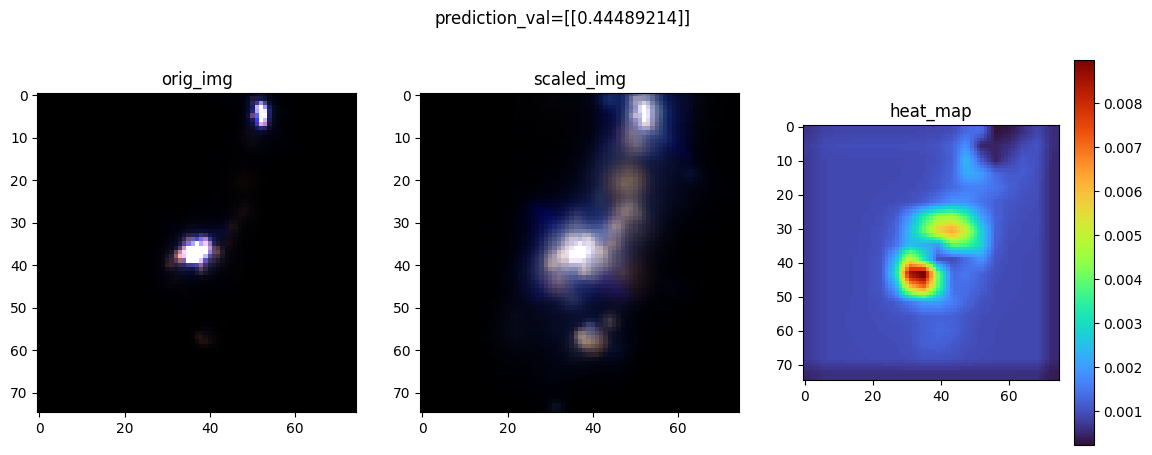

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 4/32 [==>...........................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

20/32 [=================>............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 1s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

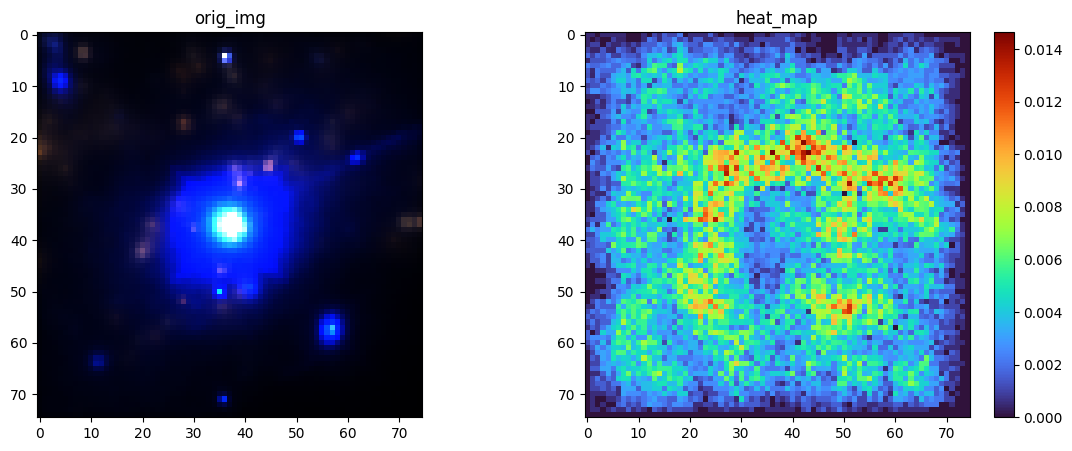

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:12 - loss: 0.7094 - accuracy: 0.5312

  2/338 [..............................] - ETA: 19s - loss: 0.7097 - accuracy: 0.5156 

  3/338 [..............................] - ETA: 19s - loss: 0.7109 - accuracy: 0.4479

  4/338 [..............................] - ETA: 18s - loss: 0.7105 - accuracy: 0.4531

  5/338 [..............................] - ETA: 18s - loss: 0.7100 - accuracy: 0.4625

  6/338 [..............................] - ETA: 18s - loss: 0.7093 - accuracy: 0.4792

  7/338 [..............................] - ETA: 18s - loss: 0.7094 - accuracy: 0.4554

  8/338 [..............................] - ETA: 18s - loss: 0.7094 - accuracy: 0.4375

  9/338 [..............................] - ETA: 18s - loss: 0.7091 - accuracy: 0.4340

 10/338 [..............................] - ETA: 18s - loss: 0.7088 - accuracy: 0.4375

 11/338 [..............................] - ETA: 18s - loss: 0.7084 - accuracy: 0.4432

 12/338 [>.............................] - ETA: 18s - loss: 0.7081 - accuracy: 0.4479

 13/338 [>.............................] - ETA: 18s - loss: 0.7078 - accuracy: 0.4447

 14/338 [>.............................] - ETA: 18s - loss: 0.7075 - accuracy: 0.4442

 15/338 [>.............................] - ETA: 17s - loss: 0.7072 - accuracy: 0.4479

 16/338 [>.............................] - ETA: 17s - loss: 0.7070 - accuracy: 0.4434

 17/338 [>.............................] - ETA: 17s - loss: 0.7067 - accuracy: 0.4540

 18/338 [>.............................] - ETA: 17s - loss: 0.7064 - accuracy: 0.4601

 19/338 [>.............................] - ETA: 17s - loss: 0.7061 - accuracy: 0.4688

 20/338 [>.............................] - ETA: 17s - loss: 0.7058 - accuracy: 0.4766

 21/338 [>.............................] - ETA: 17s - loss: 0.7056 - accuracy: 0.4717

 22/338 [>.............................] - ETA: 17s - loss: 0.7054 - accuracy: 0.4716

 23/338 [=>............................] - ETA: 17s - loss: 0.7052 - accuracy: 0.4728

 24/338 [=>............................] - ETA: 17s - loss: 0.7049 - accuracy: 0.4766

 25/338 [=>............................] - ETA: 17s - loss: 0.7048 - accuracy: 0.4750

 26/338 [=>............................] - ETA: 17s - loss: 0.7045 - accuracy: 0.4808

 27/338 [=>............................] - ETA: 17s - loss: 0.7043 - accuracy: 0.4861

 28/338 [=>............................] - ETA: 17s - loss: 0.7040 - accuracy: 0.4900

 29/338 [=>............................] - ETA: 17s - loss: 0.7039 - accuracy: 0.4871

 30/338 [=>............................] - ETA: 17s - loss: 0.7037 - accuracy: 0.4865

 31/338 [=>............................] - ETA: 17s - loss: 0.7035 - accuracy: 0.4909

 32/338 [=>............................] - ETA: 16s - loss: 0.7032 - accuracy: 0.4951

 33/338 [=>............................] - ETA: 16s - loss: 0.7031 - accuracy: 0.4943

 34/338 [==>...........................] - ETA: 16s - loss: 0.7030 - accuracy: 0.4945

 35/338 [==>...........................] - ETA: 16s - loss: 0.7028 - accuracy: 0.4946

 36/338 [==>...........................] - ETA: 16s - loss: 0.7027 - accuracy: 0.4931

 37/338 [==>...........................] - ETA: 16s - loss: 0.7026 - accuracy: 0.4899

 38/338 [==>...........................] - ETA: 16s - loss: 0.7025 - accuracy: 0.4910

 39/338 [==>...........................] - ETA: 16s - loss: 0.7022 - accuracy: 0.4944

 40/338 [==>...........................] - ETA: 16s - loss: 0.7021 - accuracy: 0.4969

 41/338 [==>...........................] - ETA: 16s - loss: 0.7019 - accuracy: 0.4985

 42/338 [==>...........................] - ETA: 16s - loss: 0.7018 - accuracy: 0.4985

 43/338 [==>...........................] - ETA: 16s - loss: 0.7016 - accuracy: 0.5015

 44/338 [==>...........................] - ETA: 16s - loss: 0.7014 - accuracy: 0.5021

 45/338 [==>...........................] - ETA: 16s - loss: 0.7013 - accuracy: 0.5035

 46/338 [===>..........................] - ETA: 16s - loss: 0.7011 - accuracy: 0.5061

 47/338 [===>..........................] - ETA: 16s - loss: 0.7010 - accuracy: 0.5060

 48/338 [===>..........................] - ETA: 16s - loss: 0.7008 - accuracy: 0.5072

 49/338 [===>..........................] - ETA: 15s - loss: 0.7007 - accuracy: 0.5077

 50/338 [===>..........................] - ETA: 15s - loss: 0.7006 - accuracy: 0.5081

 51/338 [===>..........................] - ETA: 15s - loss: 0.7005 - accuracy: 0.5074

 52/338 [===>..........................] - ETA: 15s - loss: 0.7004 - accuracy: 0.5072

 53/338 [===>..........................] - ETA: 15s - loss: 0.7003 - accuracy: 0.5083

 54/338 [===>..........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.5087

 55/338 [===>..........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.5080

 56/338 [===>..........................] - ETA: 15s - loss: 0.7000 - accuracy: 0.5106

 57/338 [====>.........................] - ETA: 15s - loss: 0.6998 - accuracy: 0.5121

 58/338 [====>.........................] - ETA: 15s - loss: 0.6997 - accuracy: 0.5124

 59/338 [====>.........................] - ETA: 15s - loss: 0.6996 - accuracy: 0.5138

 60/338 [====>.........................] - ETA: 15s - loss: 0.6995 - accuracy: 0.5141

 61/338 [====>.........................] - ETA: 15s - loss: 0.6995 - accuracy: 0.5123

 62/338 [====>.........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5146

 63/338 [====>.........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5159

 64/338 [====>.........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5161

 65/338 [====>.........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5139

 66/338 [====>.........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5147

 67/338 [====>.........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5149

 68/338 [=====>........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5142

 69/338 [=====>........................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5149

 70/338 [=====>........................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5161

 71/338 [=====>........................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5158

 72/338 [=====>........................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5178

 73/338 [=====>........................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5171

 74/338 [=====>........................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5177

 75/338 [=====>........................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5179

 76/338 [=====>........................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5173

 77/338 [=====>........................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5162

 78/338 [=====>........................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5176

 79/338 [======>.......................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5166

 80/338 [======>.......................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5168

 81/338 [======>.......................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5181

 82/338 [======>.......................] - ETA: 14s - loss: 0.6981 - accuracy: 0.5183

 83/338 [======>.......................] - ETA: 14s - loss: 0.6979 - accuracy: 0.5215

 84/338 [======>.......................] - ETA: 14s - loss: 0.6978 - accuracy: 0.5216

 85/338 [======>.......................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5228

 86/338 [======>.......................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5222

 87/338 [======>.......................] - ETA: 13s - loss: 0.6974 - accuracy: 0.5255

 88/338 [======>.......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5241

 89/338 [======>.......................] - ETA: 13s - loss: 0.6974 - accuracy: 0.5242

 90/338 [======>.......................] - ETA: 13s - loss: 0.6973 - accuracy: 0.5243

 91/338 [=======>......................] - ETA: 13s - loss: 0.6974 - accuracy: 0.5234

 92/338 [=======>......................] - ETA: 13s - loss: 0.6973 - accuracy: 0.5238

 93/338 [=======>......................] - ETA: 13s - loss: 0.6971 - accuracy: 0.5252

 94/338 [=======>......................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5266

 95/338 [=======>......................] - ETA: 13s - loss: 0.6969 - accuracy: 0.5266

 96/338 [=======>......................] - ETA: 13s - loss: 0.6969 - accuracy: 0.5264

 97/338 [=======>......................] - ETA: 13s - loss: 0.6969 - accuracy: 0.5261

 98/338 [=======>......................] - ETA: 13s - loss: 0.6969 - accuracy: 0.5255

 99/338 [=======>......................] - ETA: 13s - loss: 0.6968 - accuracy: 0.5259

100/338 [=======>......................] - ETA: 13s - loss: 0.6968 - accuracy: 0.5253

101/338 [=======>......................] - ETA: 13s - loss: 0.6968 - accuracy: 0.5254

102/338 [========>.....................] - ETA: 13s - loss: 0.6967 - accuracy: 0.5257

103/338 [========>.....................] - ETA: 13s - loss: 0.6967 - accuracy: 0.5261

104/338 [========>.....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5246

105/338 [========>.....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5238

106/338 [========>.....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5242

107/338 [========>.....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5239

108/338 [========>.....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5234

109/338 [========>.....................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5235

110/338 [========>.....................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5236

111/338 [========>.....................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5239

112/338 [========>.....................] - ETA: 12s - loss: 0.6964 - accuracy: 0.5248

113/338 [=========>....................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5243

114/338 [=========>....................] - ETA: 12s - loss: 0.6964 - accuracy: 0.5247

115/338 [=========>....................] - ETA: 12s - loss: 0.6963 - accuracy: 0.5250

116/338 [=========>....................] - ETA: 12s - loss: 0.6962 - accuracy: 0.5253

117/338 [=========>....................] - ETA: 12s - loss: 0.6963 - accuracy: 0.5246

118/338 [=========>....................] - ETA: 12s - loss: 0.6962 - accuracy: 0.5254

119/338 [=========>....................] - ETA: 12s - loss: 0.6962 - accuracy: 0.5244

120/338 [=========>....................] - ETA: 12s - loss: 0.6962 - accuracy: 0.5245

121/338 [=========>....................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5245

122/338 [=========>....................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5238

123/338 [=========>....................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5236

124/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5247

125/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5245

126/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5243

127/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5239

128/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5234

129/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5233

130/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5231

131/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5234

132/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5218

133/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5214

134/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5205

135/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5199

136/338 [===========>..................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5202

137/338 [===========>..................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5194

138/338 [===========>..................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5192

139/338 [===========>..................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5189

140/338 [===========>..................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5196

141/338 [===========>..................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5199

142/338 [===========>..................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5194

143/338 [===========>..................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5192

144/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5195

145/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5190

146/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5197

147/338 [============>.................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5191

148/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5198

149/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5199

150/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5196

151/338 [============>.................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5205

152/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5212

153/338 [============>.................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5223

154/338 [============>.................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5219

155/338 [============>.................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5222

156/338 [============>.................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5230

157/338 [============>.................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5231

158/338 [=============>................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5231 

159/338 [=============>................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5242

160/338 [=============>................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5240

161/338 [=============>................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5243

162/338 [=============>................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5237

163/338 [=============>................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5242

164/338 [=============>................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5234

165/338 [=============>................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5231

166/338 [=============>................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5235

167/338 [=============>................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5232

168/338 [=============>................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5225

169/338 [==============>...............] - ETA: 9s - loss: 0.6952 - accuracy: 0.5224

170/338 [==============>...............] - ETA: 9s - loss: 0.6952 - accuracy: 0.5226

171/338 [==============>...............] - ETA: 9s - loss: 0.6951 - accuracy: 0.5232

172/338 [==============>...............] - ETA: 9s - loss: 0.6951 - accuracy: 0.5233

173/338 [==============>...............] - ETA: 9s - loss: 0.6950 - accuracy: 0.5238

174/338 [==============>...............] - ETA: 9s - loss: 0.6951 - accuracy: 0.5232

175/338 [==============>...............] - ETA: 9s - loss: 0.6950 - accuracy: 0.5236

176/338 [==============>...............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5236

177/338 [==============>...............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5247

178/338 [==============>...............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5251

179/338 [==============>...............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5248

180/338 [==============>...............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5241

181/338 [===============>..............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5240

182/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5237

183/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5236

184/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5234

185/338 [===============>..............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5233

186/338 [===============>..............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5244

187/338 [===============>..............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5237

188/338 [===============>..............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5234

189/338 [===============>..............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5235

190/338 [===============>..............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5242

191/338 [===============>..............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5242

192/338 [================>.............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5234

193/338 [================>.............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5233

194/338 [================>.............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5234

195/338 [================>.............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5229

196/338 [================>.............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5231

197/338 [================>.............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5228

198/338 [================>.............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5227

199/338 [================>.............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5225

200/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5234

201/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5232

202/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5227

203/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5220

204/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5219

205/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5218

206/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5223

207/338 [=================>............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5226

208/338 [=================>............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5228

209/338 [=================>............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5226

210/338 [=================>............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5229

211/338 [=================>............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5227

212/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5231

213/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5226

214/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5223

215/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5221

216/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5217

217/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5229

218/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5226

219/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5228

220/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5232

221/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5226

222/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5225

223/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5224

224/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5222

225/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5225

226/338 [===================>..........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5221

227/338 [===================>..........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5223

228/338 [===================>..........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5218

229/338 [===================>..........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5216

230/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5208

231/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5210

232/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5209

233/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5209

234/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5207

235/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5207

236/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5208

237/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5210

238/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5211

239/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5217

240/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5217

241/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5214

242/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5210

243/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5212

244/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5213

245/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5208

246/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5205

247/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5200

248/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5199

249/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5195

250/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5188

251/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5192

252/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5193

253/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5198

254/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5198

255/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5196

256/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5194

257/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5196

258/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5195

259/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5192

260/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5191

261/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5189

262/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5191

263/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5188

264/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5198

265/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5195

266/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5195

267/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5192

268/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5198

269/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5201

270/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5200

271/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5198

272/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5195

273/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5191

274/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5192

275/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5186

276/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5186

277/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5190

278/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5191

279/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5190

280/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5193

281/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5192

282/338 [========================>.....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5193

283/338 [========================>.....] - ETA: 3s - loss: 0.6940 - accuracy: 0.5187

284/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5187

285/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5191

286/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5186

287/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5182

288/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5183

289/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5188

290/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5189

291/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5186

292/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5183

293/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5176

294/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5181

295/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5185

296/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5189

297/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5190

298/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5187

299/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5186

300/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5188

301/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5189

302/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5186

303/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5186

304/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5188

305/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5191

306/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5191

307/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5190

308/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5193

309/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5191

310/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5194

311/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5198

312/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5199

313/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5203

314/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5205

315/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5207

316/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5208

317/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5206

318/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5201

319/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5206

320/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5202

321/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5205

322/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5206

323/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5206

324/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5208

325/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5211

326/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5213

327/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5213

328/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5209

329/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5210

330/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5210

331/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5212

332/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5209

333/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5211

334/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5217

335/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5215

336/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5218

337/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5220

338/338 [==============================] - 21s 60ms/step - loss: 0.6932 - accuracy: 0.5219 - val_loss: 0.6904 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6929 - accuracy: 0.5000

  2/338 [..............................] - ETA: 18s - loss: 0.6882 - accuracy: 0.5469

  3/338 [..............................] - ETA: 18s - loss: 0.6845 - accuracy: 0.5833

  4/338 [..............................] - ETA: 18s - loss: 0.6846 - accuracy: 0.5781

  5/338 [..............................] - ETA: 18s - loss: 0.6863 - accuracy: 0.5562

  6/338 [..............................] - ETA: 18s - loss: 0.6882 - accuracy: 0.5365

  7/338 [..............................] - ETA: 18s - loss: 0.6873 - accuracy: 0.5446

  8/338 [..............................] - ETA: 18s - loss: 0.6876 - accuracy: 0.5430

  9/338 [..............................] - ETA: 18s - loss: 0.6885 - accuracy: 0.5312

 10/338 [..............................] - ETA: 18s - loss: 0.6875 - accuracy: 0.5437

 11/338 [..............................] - ETA: 18s - loss: 0.6877 - accuracy: 0.5398

 12/338 [>.............................] - ETA: 18s - loss: 0.6876 - accuracy: 0.5391

 13/338 [>.............................] - ETA: 17s - loss: 0.6879 - accuracy: 0.5337

 14/338 [>.............................] - ETA: 17s - loss: 0.6885 - accuracy: 0.5268

 15/338 [>.............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5271

 16/338 [>.............................] - ETA: 17s - loss: 0.6889 - accuracy: 0.5195

 17/338 [>.............................] - ETA: 17s - loss: 0.6890 - accuracy: 0.5202

 18/338 [>.............................] - ETA: 17s - loss: 0.6889 - accuracy: 0.5226

 19/338 [>.............................] - ETA: 17s - loss: 0.6884 - accuracy: 0.5280

 20/338 [>.............................] - ETA: 17s - loss: 0.6879 - accuracy: 0.5344

 21/338 [>.............................] - ETA: 17s - loss: 0.6886 - accuracy: 0.5283

 22/338 [>.............................] - ETA: 17s - loss: 0.6880 - accuracy: 0.5341

 23/338 [=>............................] - ETA: 17s - loss: 0.6881 - accuracy: 0.5326

 24/338 [=>............................] - ETA: 17s - loss: 0.6879 - accuracy: 0.5339

 25/338 [=>............................] - ETA: 17s - loss: 0.6876 - accuracy: 0.5375

 26/338 [=>............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5397

 27/338 [=>............................] - ETA: 17s - loss: 0.6873 - accuracy: 0.5405

 28/338 [=>............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5413

 29/338 [=>............................] - ETA: 17s - loss: 0.6870 - accuracy: 0.5409

 30/338 [=>............................] - ETA: 17s - loss: 0.6876 - accuracy: 0.5354

 31/338 [=>............................] - ETA: 17s - loss: 0.6876 - accuracy: 0.5343

 32/338 [=>............................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5352

 33/338 [=>............................] - ETA: 16s - loss: 0.6877 - accuracy: 0.5331

 34/338 [==>...........................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5294

 35/338 [==>...........................] - ETA: 16s - loss: 0.6879 - accuracy: 0.5321

 36/338 [==>...........................] - ETA: 16s - loss: 0.6877 - accuracy: 0.5347

 37/338 [==>...........................] - ETA: 16s - loss: 0.6878 - accuracy: 0.5321

 38/338 [==>...........................] - ETA: 16s - loss: 0.6878 - accuracy: 0.5321

 39/338 [==>...........................] - ETA: 16s - loss: 0.6877 - accuracy: 0.5329

 40/338 [==>...........................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5352

 41/338 [==>...........................] - ETA: 16s - loss: 0.6877 - accuracy: 0.5320

 42/338 [==>...........................] - ETA: 16s - loss: 0.6876 - accuracy: 0.5335

 43/338 [==>...........................] - ETA: 16s - loss: 0.6878 - accuracy: 0.5320

 44/338 [==>...........................] - ETA: 16s - loss: 0.6877 - accuracy: 0.5327

 45/338 [==>...........................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5347

 46/338 [===>..........................] - ETA: 16s - loss: 0.6872 - accuracy: 0.5380

 47/338 [===>..........................] - ETA: 16s - loss: 0.6870 - accuracy: 0.5412

 48/338 [===>..........................] - ETA: 16s - loss: 0.6870 - accuracy: 0.5397

 49/338 [===>..........................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5389

 50/338 [===>..........................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5425

 51/338 [===>..........................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5441

 52/338 [===>..........................] - ETA: 15s - loss: 0.6864 - accuracy: 0.5445

 53/338 [===>..........................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5401

 54/338 [===>..........................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5411

 55/338 [===>..........................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5392

 56/338 [===>..........................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5385

 57/338 [====>.........................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5384

 58/338 [====>.........................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5377

 59/338 [====>.........................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5376

 60/338 [====>.........................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5391

 61/338 [====>.........................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5369

 62/338 [====>.........................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5358

 63/338 [====>.........................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5352

 64/338 [====>.........................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5337

 65/338 [====>.........................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5322

 66/338 [====>.........................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5312

 67/338 [====>.........................] - ETA: 14s - loss: 0.6878 - accuracy: 0.5308

 68/338 [=====>........................] - ETA: 14s - loss: 0.6879 - accuracy: 0.5299

 69/338 [=====>........................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5294

 70/338 [=====>........................] - ETA: 14s - loss: 0.6879 - accuracy: 0.5304

 71/338 [=====>........................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5290

 72/338 [=====>........................] - ETA: 14s - loss: 0.6878 - accuracy: 0.5304

 73/338 [=====>........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5283

 74/338 [=====>........................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5274

 75/338 [=====>........................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5292

 76/338 [=====>........................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5292

 77/338 [=====>........................] - ETA: 14s - loss: 0.6879 - accuracy: 0.5304

 78/338 [=====>........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5280

 79/338 [======>.......................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5293

 80/338 [======>.......................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5289

 81/338 [======>.......................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5289

 82/338 [======>.......................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5274

 83/338 [======>.......................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5282

 84/338 [======>.......................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5279

 85/338 [======>.......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5272

 86/338 [======>.......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5273

 87/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5262

 88/338 [======>.......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5270

 89/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5270

 90/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5274

 91/338 [=======>......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5268

 92/338 [=======>......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5268

 93/338 [=======>......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5286

 94/338 [=======>......................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5309

 95/338 [=======>......................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5316

 96/338 [=======>......................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5319

 97/338 [=======>......................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5335

 98/338 [=======>......................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5332

 99/338 [=======>......................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5338

100/338 [=======>......................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5331

101/338 [=======>......................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5331

102/338 [========>.....................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5322

103/338 [========>.....................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5316

104/338 [========>.....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5294

105/338 [========>.....................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5307

106/338 [========>.....................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5321

107/338 [========>.....................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5312

108/338 [========>.....................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5304

109/338 [========>.....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5301

110/338 [========>.....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5304

111/338 [========>.....................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5312

112/338 [========>.....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5312

113/338 [=========>....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5312

114/338 [=========>....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5304

115/338 [=========>....................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5288

116/338 [=========>....................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5283

117/338 [=========>....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5272

118/338 [=========>....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5281

119/338 [=========>....................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5291

120/338 [=========>....................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5286

121/338 [=========>....................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5292

122/338 [=========>....................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5284

123/338 [=========>....................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5274

124/338 [==========>...................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5265

125/338 [==========>...................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5263

126/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5253

127/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5246

128/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5249

129/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5252

130/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5255

131/338 [==========>...................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5258

132/338 [==========>...................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5263

133/338 [==========>...................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5263

134/338 [==========>...................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5268

135/338 [==========>...................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5266

136/338 [===========>..................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5253

137/338 [===========>..................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5240

138/338 [===========>..................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5236

139/338 [===========>..................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5243

140/338 [===========>..................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5243

141/338 [===========>..................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5239

142/338 [===========>..................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5233

143/338 [===========>..................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5223

144/338 [===========>..................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5221

145/338 [===========>..................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5220

146/338 [===========>..................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5214

147/338 [============>.................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5219

148/338 [============>.................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5215

149/338 [============>.................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5210

150/338 [============>.................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5221

151/338 [============>.................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5221

152/338 [============>.................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5232

153/338 [============>.................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5239

154/338 [============>.................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5244

155/338 [============>.................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5240

156/338 [============>.................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5244

157/338 [============>.................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5243 

158/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5245

159/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5248

160/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5250

161/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5252

162/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5249

163/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5245

164/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5242

165/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5244

166/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5233

167/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5241

168/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5244

169/338 [==============>...............] - ETA: 9s - loss: 0.6888 - accuracy: 0.5248

170/338 [==============>...............] - ETA: 9s - loss: 0.6888 - accuracy: 0.5252

171/338 [==============>...............] - ETA: 9s - loss: 0.6888 - accuracy: 0.5254

172/338 [==============>...............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5263

173/338 [==============>...............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5266

174/338 [==============>...............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5264

175/338 [==============>...............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5257

176/338 [==============>...............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5261

177/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5260

178/338 [==============>...............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5255

179/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5262

180/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5267

181/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5259

182/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5259

183/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5256

184/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5260

185/338 [===============>..............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5250

186/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5252

187/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5256

188/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5261

189/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5253

190/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5248

191/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5257

192/338 [================>.............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5257

193/338 [================>.............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5253

194/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5258

195/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5256

196/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5249

197/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5252

198/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5253

199/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5251

200/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5247

201/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5246

202/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5246

203/338 [=================>............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5245

204/338 [=================>............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5247

205/338 [=================>............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5250

206/338 [=================>............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5246

207/338 [=================>............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5248

208/338 [=================>............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5248

209/338 [=================>............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5257

210/338 [=================>............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5260

211/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5267

212/338 [=================>............] - ETA: 6s - loss: 0.6883 - accuracy: 0.5271

213/338 [=================>............] - ETA: 6s - loss: 0.6883 - accuracy: 0.5271

214/338 [=================>............] - ETA: 6s - loss: 0.6882 - accuracy: 0.5273

215/338 [==================>...........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5270

216/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5273

217/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5272

218/338 [==================>...........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5265

219/338 [==================>...........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5267

220/338 [==================>...........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5263

221/338 [==================>...........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5266

222/338 [==================>...........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5265

223/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5266

224/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5266

225/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5274

226/338 [===================>..........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5277

227/338 [===================>..........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5279

228/338 [===================>..........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5280

229/338 [===================>..........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5274

230/338 [===================>..........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5273

231/338 [===================>..........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5277

232/338 [===================>..........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5269

233/338 [===================>..........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5272

234/338 [===================>..........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5274

235/338 [===================>..........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5273

236/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5277

237/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5278

238/338 [====================>.........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5277

239/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5282

240/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5281

241/338 [====================>.........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5274

242/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5275

243/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5276

244/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5277

245/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5282

246/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5281

247/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5281

248/338 [=====================>........] - ETA: 4s - loss: 0.6881 - accuracy: 0.5278

249/338 [=====================>........] - ETA: 4s - loss: 0.6881 - accuracy: 0.5277

250/338 [=====================>........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5279

251/338 [=====================>........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5281

252/338 [=====================>........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5285

253/338 [=====================>........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5284

254/338 [=====================>........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5285

255/338 [=====================>........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5289

256/338 [=====================>........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5284

257/338 [=====================>........] - ETA: 4s - loss: 0.6879 - accuracy: 0.5282

258/338 [=====================>........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5288

259/338 [=====================>........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5284

260/338 [======================>.......] - ETA: 4s - loss: 0.6879 - accuracy: 0.5281

261/338 [======================>.......] - ETA: 4s - loss: 0.6880 - accuracy: 0.5278

262/338 [======================>.......] - ETA: 4s - loss: 0.6880 - accuracy: 0.5273

263/338 [======================>.......] - ETA: 4s - loss: 0.6880 - accuracy: 0.5271

264/338 [======================>.......] - ETA: 4s - loss: 0.6881 - accuracy: 0.5266

265/338 [======================>.......] - ETA: 4s - loss: 0.6880 - accuracy: 0.5270

266/338 [======================>.......] - ETA: 3s - loss: 0.6881 - accuracy: 0.5263

267/338 [======================>.......] - ETA: 3s - loss: 0.6881 - accuracy: 0.5261

268/338 [======================>.......] - ETA: 3s - loss: 0.6881 - accuracy: 0.5264

269/338 [======================>.......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5267

270/338 [======================>.......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5265

271/338 [=======================>......] - ETA: 3s - loss: 0.6881 - accuracy: 0.5263

272/338 [=======================>......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5263

273/338 [=======================>......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5267

274/338 [=======================>......] - ETA: 3s - loss: 0.6881 - accuracy: 0.5265

275/338 [=======================>......] - ETA: 3s - loss: 0.6881 - accuracy: 0.5265

276/338 [=======================>......] - ETA: 3s - loss: 0.6881 - accuracy: 0.5265

277/338 [=======================>......] - ETA: 3s - loss: 0.6881 - accuracy: 0.5264

278/338 [=======================>......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5268

279/338 [=======================>......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5267

280/338 [=======================>......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5266

281/338 [=======================>......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5265

282/338 [========================>.....] - ETA: 3s - loss: 0.6880 - accuracy: 0.5265

283/338 [========================>.....] - ETA: 3s - loss: 0.6880 - accuracy: 0.5269

284/338 [========================>.....] - ETA: 2s - loss: 0.6880 - accuracy: 0.5267

285/338 [========================>.....] - ETA: 2s - loss: 0.6880 - accuracy: 0.5265

286/338 [========================>.....] - ETA: 2s - loss: 0.6880 - accuracy: 0.5267

287/338 [========================>.....] - ETA: 2s - loss: 0.6880 - accuracy: 0.5262

288/338 [========================>.....] - ETA: 2s - loss: 0.6880 - accuracy: 0.5260

289/338 [========================>.....] - ETA: 2s - loss: 0.6880 - accuracy: 0.5265

290/338 [========================>.....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5267

291/338 [========================>.....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5268

292/338 [========================>.....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5271

293/338 [=========================>....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5272

294/338 [=========================>....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5271

295/338 [=========================>....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5272

296/338 [=========================>....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5273

297/338 [=========================>....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5277

298/338 [=========================>....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5274

299/338 [=========================>....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5271

300/338 [=========================>....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5270

301/338 [=========================>....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5271

302/338 [=========================>....] - ETA: 1s - loss: 0.6878 - accuracy: 0.5269

303/338 [=========================>....] - ETA: 1s - loss: 0.6878 - accuracy: 0.5270

304/338 [=========================>....] - ETA: 1s - loss: 0.6878 - accuracy: 0.5268

305/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5266

306/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5267

307/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5270

308/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5268

309/338 [==========================>...] - ETA: 1s - loss: 0.6877 - accuracy: 0.5271

310/338 [==========================>...] - ETA: 1s - loss: 0.6877 - accuracy: 0.5272

311/338 [==========================>...] - ETA: 1s - loss: 0.6877 - accuracy: 0.5274

312/338 [==========================>...] - ETA: 1s - loss: 0.6877 - accuracy: 0.5272

313/338 [==========================>...] - ETA: 1s - loss: 0.6877 - accuracy: 0.5269

314/338 [==========================>...] - ETA: 1s - loss: 0.6877 - accuracy: 0.5271

315/338 [==========================>...] - ETA: 1s - loss: 0.6877 - accuracy: 0.5267

316/338 [===========================>..] - ETA: 1s - loss: 0.6877 - accuracy: 0.5267

317/338 [===========================>..] - ETA: 1s - loss: 0.6877 - accuracy: 0.5261

318/338 [===========================>..] - ETA: 1s - loss: 0.6877 - accuracy: 0.5263

319/338 [===========================>..] - ETA: 1s - loss: 0.6877 - accuracy: 0.5264

320/338 [===========================>..] - ETA: 0s - loss: 0.6876 - accuracy: 0.5265

321/338 [===========================>..] - ETA: 0s - loss: 0.6876 - accuracy: 0.5267

322/338 [===========================>..] - ETA: 0s - loss: 0.6876 - accuracy: 0.5267

323/338 [===========================>..] - ETA: 0s - loss: 0.6876 - accuracy: 0.5271

324/338 [===========================>..] - ETA: 0s - loss: 0.6876 - accuracy: 0.5269

325/338 [===========================>..] - ETA: 0s - loss: 0.6876 - accuracy: 0.5271

326/338 [===========================>..] - ETA: 0s - loss: 0.6875 - accuracy: 0.5271

327/338 [============================>.] - ETA: 0s - loss: 0.6876 - accuracy: 0.5271

328/338 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.5275

329/338 [============================>.] - ETA: 0s - loss: 0.6876 - accuracy: 0.5273

330/338 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.5278

331/338 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.5279

332/338 [============================>.] - ETA: 0s - loss: 0.6874 - accuracy: 0.5280

333/338 [============================>.] - ETA: 0s - loss: 0.6874 - accuracy: 0.5279

334/338 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.5275

335/338 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.5275

336/338 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.5273

337/338 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.5271

338/338 [==============================] - 20s 59ms/step - loss: 0.6875 - accuracy: 0.5271 - val_loss: 0.6848 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6847 - accuracy: 0.5312

  2/338 [..............................] - ETA: 18s - loss: 0.6923 - accuracy: 0.5000

  3/338 [..............................] - ETA: 19s - loss: 0.6912 - accuracy: 0.5000

  4/338 [..............................] - ETA: 18s - loss: 0.6921 - accuracy: 0.5000

  5/338 [..............................] - ETA: 18s - loss: 0.6961 - accuracy: 0.4750

  6/338 [..............................] - ETA: 18s - loss: 0.6964 - accuracy: 0.4583

  7/338 [..............................] - ETA: 18s - loss: 0.6956 - accuracy: 0.4732

  8/338 [..............................] - ETA: 18s - loss: 0.6961 - accuracy: 0.4648

  9/338 [..............................] - ETA: 18s - loss: 0.6923 - accuracy: 0.4931

 10/338 [..............................] - ETA: 18s - loss: 0.6923 - accuracy: 0.4969

 11/338 [..............................] - ETA: 18s - loss: 0.6915 - accuracy: 0.5028

 12/338 [>.............................] - ETA: 17s - loss: 0.6910 - accuracy: 0.5130

 13/338 [>.............................] - ETA: 17s - loss: 0.6903 - accuracy: 0.5192

 14/338 [>.............................] - ETA: 17s - loss: 0.6908 - accuracy: 0.5089

 15/338 [>.............................] - ETA: 17s - loss: 0.6907 - accuracy: 0.5083

 16/338 [>.............................] - ETA: 17s - loss: 0.6900 - accuracy: 0.5098

 17/338 [>.............................] - ETA: 17s - loss: 0.6896 - accuracy: 0.5074

 18/338 [>.............................] - ETA: 17s - loss: 0.6893 - accuracy: 0.5087

 19/338 [>.............................] - ETA: 17s - loss: 0.6889 - accuracy: 0.5164

 20/338 [>.............................] - ETA: 17s - loss: 0.6881 - accuracy: 0.5266

 21/338 [>.............................] - ETA: 17s - loss: 0.6883 - accuracy: 0.5268

 22/338 [>.............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5369

 23/338 [=>............................] - ETA: 17s - loss: 0.6864 - accuracy: 0.5408

 24/338 [=>............................] - ETA: 17s - loss: 0.6861 - accuracy: 0.5495

 25/338 [=>............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5475

 26/338 [=>............................] - ETA: 17s - loss: 0.6875 - accuracy: 0.5493

 27/338 [=>............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5556

 28/338 [=>............................] - ETA: 16s - loss: 0.6871 - accuracy: 0.5592

 29/338 [=>............................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5582

 30/338 [=>............................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5594

 31/338 [=>............................] - ETA: 16s - loss: 0.6872 - accuracy: 0.5575

 32/338 [=>............................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5547

 33/338 [=>............................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5530

 34/338 [==>...........................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5533

 35/338 [==>...........................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5545

 36/338 [==>...........................] - ETA: 16s - loss: 0.6871 - accuracy: 0.5582

 37/338 [==>...........................] - ETA: 16s - loss: 0.6869 - accuracy: 0.5600

 38/338 [==>...........................] - ETA: 16s - loss: 0.6870 - accuracy: 0.5609

 39/338 [==>...........................] - ETA: 16s - loss: 0.6871 - accuracy: 0.5609

 40/338 [==>...........................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5641

 41/338 [==>...........................] - ETA: 16s - loss: 0.6861 - accuracy: 0.5663

 42/338 [==>...........................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5640

 43/338 [==>...........................] - ETA: 16s - loss: 0.6865 - accuracy: 0.5676

 44/338 [==>...........................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5682

 45/338 [==>...........................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5674

 46/338 [===>..........................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5700

 47/338 [===>..........................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5691

 48/338 [===>..........................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5677

 49/338 [===>..........................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5695

 50/338 [===>..........................] - ETA: 15s - loss: 0.6866 - accuracy: 0.5706

 51/338 [===>..........................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5723

 52/338 [===>..........................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5733

 53/338 [===>..........................] - ETA: 15s - loss: 0.6857 - accuracy: 0.5737

 54/338 [===>..........................] - ETA: 15s - loss: 0.6858 - accuracy: 0.5741

 55/338 [===>..........................] - ETA: 15s - loss: 0.6856 - accuracy: 0.5750

 56/338 [===>..........................] - ETA: 15s - loss: 0.6855 - accuracy: 0.5765

 57/338 [====>.........................] - ETA: 15s - loss: 0.6851 - accuracy: 0.5789

 58/338 [====>.........................] - ETA: 15s - loss: 0.6852 - accuracy: 0.5814

 59/338 [====>.........................] - ETA: 15s - loss: 0.6852 - accuracy: 0.5816

 60/338 [====>.........................] - ETA: 15s - loss: 0.6847 - accuracy: 0.5839

 61/338 [====>.........................] - ETA: 15s - loss: 0.6843 - accuracy: 0.5866

 62/338 [====>.........................] - ETA: 15s - loss: 0.6841 - accuracy: 0.5862

 63/338 [====>.........................] - ETA: 15s - loss: 0.6838 - accuracy: 0.5873

 64/338 [====>.........................] - ETA: 15s - loss: 0.6835 - accuracy: 0.5894

 65/338 [====>.........................] - ETA: 15s - loss: 0.6833 - accuracy: 0.5909

 66/338 [====>.........................] - ETA: 14s - loss: 0.6836 - accuracy: 0.5885

 67/338 [====>.........................] - ETA: 14s - loss: 0.6836 - accuracy: 0.5891

 68/338 [=====>........................] - ETA: 14s - loss: 0.6838 - accuracy: 0.5901

 69/338 [=====>........................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5892

 70/338 [=====>........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5884

 71/338 [=====>........................] - ETA: 14s - loss: 0.6844 - accuracy: 0.5880

 72/338 [=====>........................] - ETA: 14s - loss: 0.6845 - accuracy: 0.5872

 73/338 [=====>........................] - ETA: 14s - loss: 0.6848 - accuracy: 0.5873

 74/338 [=====>........................] - ETA: 14s - loss: 0.6848 - accuracy: 0.5878

 75/338 [=====>........................] - ETA: 14s - loss: 0.6847 - accuracy: 0.5871

 76/338 [=====>........................] - ETA: 14s - loss: 0.6847 - accuracy: 0.5868

 77/338 [=====>........................] - ETA: 14s - loss: 0.6846 - accuracy: 0.5881

 78/338 [=====>........................] - ETA: 14s - loss: 0.6845 - accuracy: 0.5881

 79/338 [======>.......................] - ETA: 14s - loss: 0.6846 - accuracy: 0.5866

 80/338 [======>.......................] - ETA: 14s - loss: 0.6845 - accuracy: 0.5871

 81/338 [======>.......................] - ETA: 14s - loss: 0.6844 - accuracy: 0.5860

 82/338 [======>.......................] - ETA: 14s - loss: 0.6845 - accuracy: 0.5850

 83/338 [======>.......................] - ETA: 14s - loss: 0.6846 - accuracy: 0.5847

 84/338 [======>.......................] - ETA: 14s - loss: 0.6846 - accuracy: 0.5856

 85/338 [======>.......................] - ETA: 13s - loss: 0.6846 - accuracy: 0.5864

 86/338 [======>.......................] - ETA: 13s - loss: 0.6845 - accuracy: 0.5865

 87/338 [======>.......................] - ETA: 13s - loss: 0.6845 - accuracy: 0.5866

 88/338 [======>.......................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5874

 89/338 [======>.......................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5874

 90/338 [======>.......................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5868

 91/338 [=======>......................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5869

 92/338 [=======>......................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5873

 93/338 [=======>......................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5874

 94/338 [=======>......................] - ETA: 13s - loss: 0.6840 - accuracy: 0.5884

 95/338 [=======>......................] - ETA: 13s - loss: 0.6839 - accuracy: 0.5891

 96/338 [=======>......................] - ETA: 13s - loss: 0.6840 - accuracy: 0.5898

 97/338 [=======>......................] - ETA: 13s - loss: 0.6841 - accuracy: 0.5889

 98/338 [=======>......................] - ETA: 13s - loss: 0.6840 - accuracy: 0.5899

 99/338 [=======>......................] - ETA: 13s - loss: 0.6840 - accuracy: 0.5896

100/338 [=======>......................] - ETA: 13s - loss: 0.6840 - accuracy: 0.5891

101/338 [=======>......................] - ETA: 13s - loss: 0.6839 - accuracy: 0.5888

102/338 [========>.....................] - ETA: 13s - loss: 0.6841 - accuracy: 0.5873

103/338 [========>.....................] - ETA: 12s - loss: 0.6841 - accuracy: 0.5874

104/338 [========>.....................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5874

105/338 [========>.....................] - ETA: 12s - loss: 0.6841 - accuracy: 0.5884

106/338 [========>.....................] - ETA: 12s - loss: 0.6843 - accuracy: 0.5876

107/338 [========>.....................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5879

108/338 [========>.....................] - ETA: 12s - loss: 0.6844 - accuracy: 0.5877

109/338 [========>.....................] - ETA: 12s - loss: 0.6843 - accuracy: 0.5889

110/338 [========>.....................] - ETA: 12s - loss: 0.6843 - accuracy: 0.5892

111/338 [========>.....................] - ETA: 12s - loss: 0.6843 - accuracy: 0.5895

112/338 [========>.....................] - ETA: 12s - loss: 0.6840 - accuracy: 0.5918

113/338 [=========>....................] - ETA: 12s - loss: 0.6840 - accuracy: 0.5910

114/338 [=========>....................] - ETA: 12s - loss: 0.6841 - accuracy: 0.5910

115/338 [=========>....................] - ETA: 12s - loss: 0.6841 - accuracy: 0.5910

116/338 [=========>....................] - ETA: 12s - loss: 0.6841 - accuracy: 0.5913

117/338 [=========>....................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5905

118/338 [=========>....................] - ETA: 12s - loss: 0.6840 - accuracy: 0.5911

119/338 [=========>....................] - ETA: 12s - loss: 0.6839 - accuracy: 0.5919

120/338 [=========>....................] - ETA: 12s - loss: 0.6840 - accuracy: 0.5911

121/338 [=========>....................] - ETA: 11s - loss: 0.6840 - accuracy: 0.5912

122/338 [=========>....................] - ETA: 11s - loss: 0.6841 - accuracy: 0.5907

123/338 [=========>....................] - ETA: 11s - loss: 0.6839 - accuracy: 0.5907

124/338 [==========>...................] - ETA: 11s - loss: 0.6837 - accuracy: 0.5920

125/338 [==========>...................] - ETA: 11s - loss: 0.6838 - accuracy: 0.5900

126/338 [==========>...................] - ETA: 11s - loss: 0.6838 - accuracy: 0.5898

127/338 [==========>...................] - ETA: 11s - loss: 0.6837 - accuracy: 0.5896

128/338 [==========>...................] - ETA: 11s - loss: 0.6837 - accuracy: 0.5898

129/338 [==========>...................] - ETA: 11s - loss: 0.6836 - accuracy: 0.5906

130/338 [==========>...................] - ETA: 11s - loss: 0.6837 - accuracy: 0.5899

131/338 [==========>...................] - ETA: 11s - loss: 0.6836 - accuracy: 0.5899

132/338 [==========>...................] - ETA: 11s - loss: 0.6836 - accuracy: 0.5895

133/338 [==========>...................] - ETA: 11s - loss: 0.6836 - accuracy: 0.5898

134/338 [==========>...................] - ETA: 11s - loss: 0.6836 - accuracy: 0.5893

135/338 [==========>...................] - ETA: 11s - loss: 0.6836 - accuracy: 0.5891

136/338 [===========>..................] - ETA: 11s - loss: 0.6837 - accuracy: 0.5894

137/338 [===========>..................] - ETA: 11s - loss: 0.6836 - accuracy: 0.5899

138/338 [===========>..................] - ETA: 11s - loss: 0.6836 - accuracy: 0.5892

139/338 [===========>..................] - ETA: 10s - loss: 0.6836 - accuracy: 0.5890

140/338 [===========>..................] - ETA: 10s - loss: 0.6834 - accuracy: 0.5902

141/338 [===========>..................] - ETA: 10s - loss: 0.6833 - accuracy: 0.5902

142/338 [===========>..................] - ETA: 10s - loss: 0.6832 - accuracy: 0.5911

143/338 [===========>..................] - ETA: 10s - loss: 0.6831 - accuracy: 0.5905

144/338 [===========>..................] - ETA: 10s - loss: 0.6834 - accuracy: 0.5898

145/338 [===========>..................] - ETA: 10s - loss: 0.6836 - accuracy: 0.5888

146/338 [===========>..................] - ETA: 10s - loss: 0.6837 - accuracy: 0.5895

147/338 [============>.................] - ETA: 10s - loss: 0.6836 - accuracy: 0.5901

148/338 [============>.................] - ETA: 10s - loss: 0.6835 - accuracy: 0.5912

149/338 [============>.................] - ETA: 10s - loss: 0.6835 - accuracy: 0.5917

150/338 [============>.................] - ETA: 10s - loss: 0.6834 - accuracy: 0.5921

151/338 [============>.................] - ETA: 10s - loss: 0.6832 - accuracy: 0.5927

152/338 [============>.................] - ETA: 10s - loss: 0.6832 - accuracy: 0.5927

153/338 [============>.................] - ETA: 10s - loss: 0.6831 - accuracy: 0.5931

154/338 [============>.................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5942

155/338 [============>.................] - ETA: 10s - loss: 0.6831 - accuracy: 0.5931

156/338 [============>.................] - ETA: 10s - loss: 0.6831 - accuracy: 0.5929

157/338 [============>.................] - ETA: 9s - loss: 0.6831 - accuracy: 0.5930 

158/338 [=============>................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5932

159/338 [=============>................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5930

160/338 [=============>................] - ETA: 9s - loss: 0.6832 - accuracy: 0.5920

161/338 [=============>................] - ETA: 9s - loss: 0.6832 - accuracy: 0.5920

162/338 [=============>................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5928

163/338 [=============>................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5930

164/338 [=============>................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5930

165/338 [=============>................] - ETA: 9s - loss: 0.6829 - accuracy: 0.5926

166/338 [=============>................] - ETA: 9s - loss: 0.6827 - accuracy: 0.5938

167/338 [=============>................] - ETA: 9s - loss: 0.6827 - accuracy: 0.5932

168/338 [=============>................] - ETA: 9s - loss: 0.6827 - accuracy: 0.5928

169/338 [==============>...............] - ETA: 9s - loss: 0.6826 - accuracy: 0.5932

170/338 [==============>...............] - ETA: 9s - loss: 0.6826 - accuracy: 0.5930

171/338 [==============>...............] - ETA: 9s - loss: 0.6826 - accuracy: 0.5932

172/338 [==============>...............] - ETA: 9s - loss: 0.6826 - accuracy: 0.5938

173/338 [==============>...............] - ETA: 9s - loss: 0.6825 - accuracy: 0.5945

174/338 [==============>...............] - ETA: 9s - loss: 0.6824 - accuracy: 0.5954

175/338 [==============>...............] - ETA: 8s - loss: 0.6824 - accuracy: 0.5952

176/338 [==============>...............] - ETA: 8s - loss: 0.6824 - accuracy: 0.5950

177/338 [==============>...............] - ETA: 8s - loss: 0.6824 - accuracy: 0.5952

178/338 [==============>...............] - ETA: 8s - loss: 0.6823 - accuracy: 0.5955

179/338 [==============>...............] - ETA: 8s - loss: 0.6823 - accuracy: 0.5957

180/338 [==============>...............] - ETA: 8s - loss: 0.6823 - accuracy: 0.5958

181/338 [===============>..............] - ETA: 8s - loss: 0.6823 - accuracy: 0.5970

182/338 [===============>..............] - ETA: 8s - loss: 0.6824 - accuracy: 0.5968

183/338 [===============>..............] - ETA: 8s - loss: 0.6825 - accuracy: 0.5967

184/338 [===============>..............] - ETA: 8s - loss: 0.6824 - accuracy: 0.5966

185/338 [===============>..............] - ETA: 8s - loss: 0.6824 - accuracy: 0.5965

186/338 [===============>..............] - ETA: 8s - loss: 0.6824 - accuracy: 0.5961

187/338 [===============>..............] - ETA: 8s - loss: 0.6825 - accuracy: 0.5956

188/338 [===============>..............] - ETA: 8s - loss: 0.6825 - accuracy: 0.5952

189/338 [===============>..............] - ETA: 8s - loss: 0.6824 - accuracy: 0.5961

190/338 [===============>..............] - ETA: 8s - loss: 0.6823 - accuracy: 0.5967

191/338 [===============>..............] - ETA: 8s - loss: 0.6822 - accuracy: 0.5972

192/338 [================>.............] - ETA: 8s - loss: 0.6821 - accuracy: 0.5972

193/338 [================>.............] - ETA: 7s - loss: 0.6823 - accuracy: 0.5963

194/338 [================>.............] - ETA: 7s - loss: 0.6822 - accuracy: 0.5970

195/338 [================>.............] - ETA: 7s - loss: 0.6822 - accuracy: 0.5971

196/338 [================>.............] - ETA: 7s - loss: 0.6821 - accuracy: 0.5973

197/338 [================>.............] - ETA: 7s - loss: 0.6821 - accuracy: 0.5972

198/338 [================>.............] - ETA: 7s - loss: 0.6821 - accuracy: 0.5974

199/338 [================>.............] - ETA: 7s - loss: 0.6820 - accuracy: 0.5975

200/338 [================>.............] - ETA: 7s - loss: 0.6820 - accuracy: 0.5970

201/338 [================>.............] - ETA: 7s - loss: 0.6820 - accuracy: 0.5962

202/338 [================>.............] - ETA: 7s - loss: 0.6820 - accuracy: 0.5961

203/338 [=================>............] - ETA: 7s - loss: 0.6819 - accuracy: 0.5964

204/338 [=================>............] - ETA: 7s - loss: 0.6820 - accuracy: 0.5964

205/338 [=================>............] - ETA: 7s - loss: 0.6821 - accuracy: 0.5960

206/338 [=================>............] - ETA: 7s - loss: 0.6821 - accuracy: 0.5962

207/338 [=================>............] - ETA: 7s - loss: 0.6821 - accuracy: 0.5971

208/338 [=================>............] - ETA: 7s - loss: 0.6820 - accuracy: 0.5971

209/338 [=================>............] - ETA: 7s - loss: 0.6820 - accuracy: 0.5972

210/338 [=================>............] - ETA: 7s - loss: 0.6820 - accuracy: 0.5972

211/338 [=================>............] - ETA: 6s - loss: 0.6821 - accuracy: 0.5967

212/338 [=================>............] - ETA: 6s - loss: 0.6821 - accuracy: 0.5966

213/338 [=================>............] - ETA: 6s - loss: 0.6821 - accuracy: 0.5964

214/338 [=================>............] - ETA: 6s - loss: 0.6820 - accuracy: 0.5973

215/338 [==================>...........] - ETA: 6s - loss: 0.6819 - accuracy: 0.5977

216/338 [==================>...........] - ETA: 6s - loss: 0.6818 - accuracy: 0.5979

217/338 [==================>...........] - ETA: 6s - loss: 0.6817 - accuracy: 0.5981

218/338 [==================>...........] - ETA: 6s - loss: 0.6817 - accuracy: 0.5985

219/338 [==================>...........] - ETA: 6s - loss: 0.6817 - accuracy: 0.5989

220/338 [==================>...........] - ETA: 6s - loss: 0.6817 - accuracy: 0.5986

221/338 [==================>...........] - ETA: 6s - loss: 0.6816 - accuracy: 0.5993

222/338 [==================>...........] - ETA: 6s - loss: 0.6817 - accuracy: 0.5987

223/338 [==================>...........] - ETA: 6s - loss: 0.6816 - accuracy: 0.5989

224/338 [==================>...........] - ETA: 6s - loss: 0.6817 - accuracy: 0.5986

225/338 [==================>...........] - ETA: 6s - loss: 0.6818 - accuracy: 0.5982

226/338 [===================>..........] - ETA: 6s - loss: 0.6817 - accuracy: 0.5985

227/338 [===================>..........] - ETA: 6s - loss: 0.6817 - accuracy: 0.5987

228/338 [===================>..........] - ETA: 6s - loss: 0.6817 - accuracy: 0.5987

229/338 [===================>..........] - ETA: 5s - loss: 0.6816 - accuracy: 0.5985

230/338 [===================>..........] - ETA: 5s - loss: 0.6816 - accuracy: 0.5988

231/338 [===================>..........] - ETA: 5s - loss: 0.6814 - accuracy: 0.5996

232/338 [===================>..........] - ETA: 5s - loss: 0.6813 - accuracy: 0.5997

233/338 [===================>..........] - ETA: 5s - loss: 0.6812 - accuracy: 0.6001

234/338 [===================>..........] - ETA: 5s - loss: 0.6812 - accuracy: 0.6004

235/338 [===================>..........] - ETA: 5s - loss: 0.6812 - accuracy: 0.6009

236/338 [===================>..........] - ETA: 5s - loss: 0.6811 - accuracy: 0.6010

237/338 [====================>.........] - ETA: 5s - loss: 0.6812 - accuracy: 0.6013

238/338 [====================>.........] - ETA: 5s - loss: 0.6812 - accuracy: 0.6011

239/338 [====================>.........] - ETA: 5s - loss: 0.6812 - accuracy: 0.6016

240/338 [====================>.........] - ETA: 5s - loss: 0.6813 - accuracy: 0.6010

241/338 [====================>.........] - ETA: 5s - loss: 0.6812 - accuracy: 0.6014

242/338 [====================>.........] - ETA: 5s - loss: 0.6812 - accuracy: 0.6015

243/338 [====================>.........] - ETA: 5s - loss: 0.6811 - accuracy: 0.6019

244/338 [====================>.........] - ETA: 5s - loss: 0.6812 - accuracy: 0.6016

245/338 [====================>.........] - ETA: 5s - loss: 0.6813 - accuracy: 0.6010

246/338 [====================>.........] - ETA: 5s - loss: 0.6814 - accuracy: 0.6007

247/338 [====================>.........] - ETA: 5s - loss: 0.6814 - accuracy: 0.6003

248/338 [=====================>........] - ETA: 4s - loss: 0.6813 - accuracy: 0.6007

249/338 [=====================>........] - ETA: 4s - loss: 0.6813 - accuracy: 0.6009

250/338 [=====================>........] - ETA: 4s - loss: 0.6812 - accuracy: 0.6008

251/338 [=====================>........] - ETA: 4s - loss: 0.6812 - accuracy: 0.6006

252/338 [=====================>........] - ETA: 4s - loss: 0.6814 - accuracy: 0.6000

253/338 [=====================>........] - ETA: 4s - loss: 0.6814 - accuracy: 0.6000

254/338 [=====================>........] - ETA: 4s - loss: 0.6814 - accuracy: 0.5997

255/338 [=====================>........] - ETA: 4s - loss: 0.6814 - accuracy: 0.5994

256/338 [=====================>........] - ETA: 4s - loss: 0.6814 - accuracy: 0.5996

257/338 [=====================>........] - ETA: 4s - loss: 0.6814 - accuracy: 0.5997

258/338 [=====================>........] - ETA: 4s - loss: 0.6813 - accuracy: 0.6002

259/338 [=====================>........] - ETA: 4s - loss: 0.6813 - accuracy: 0.6003

260/338 [======================>.......] - ETA: 4s - loss: 0.6813 - accuracy: 0.6002

261/338 [======================>.......] - ETA: 4s - loss: 0.6811 - accuracy: 0.6011

262/338 [======================>.......] - ETA: 4s - loss: 0.6811 - accuracy: 0.6010

263/338 [======================>.......] - ETA: 4s - loss: 0.6812 - accuracy: 0.6005

264/338 [======================>.......] - ETA: 4s - loss: 0.6813 - accuracy: 0.6001

265/338 [======================>.......] - ETA: 4s - loss: 0.6812 - accuracy: 0.6006

266/338 [======================>.......] - ETA: 3s - loss: 0.6812 - accuracy: 0.6006

267/338 [======================>.......] - ETA: 3s - loss: 0.6811 - accuracy: 0.6009

268/338 [======================>.......] - ETA: 3s - loss: 0.6811 - accuracy: 0.6009

269/338 [======================>.......] - ETA: 3s - loss: 0.6810 - accuracy: 0.6014

270/338 [======================>.......] - ETA: 3s - loss: 0.6810 - accuracy: 0.6015

271/338 [=======================>......] - ETA: 3s - loss: 0.6810 - accuracy: 0.6015

272/338 [=======================>......] - ETA: 3s - loss: 0.6810 - accuracy: 0.6014

273/338 [=======================>......] - ETA: 3s - loss: 0.6810 - accuracy: 0.6016

274/338 [=======================>......] - ETA: 3s - loss: 0.6810 - accuracy: 0.6013

275/338 [=======================>......] - ETA: 3s - loss: 0.6810 - accuracy: 0.6014

276/338 [=======================>......] - ETA: 3s - loss: 0.6809 - accuracy: 0.6014

277/338 [=======================>......] - ETA: 3s - loss: 0.6808 - accuracy: 0.6016

278/338 [=======================>......] - ETA: 3s - loss: 0.6808 - accuracy: 0.6020

279/338 [=======================>......] - ETA: 3s - loss: 0.6806 - accuracy: 0.6024

280/338 [=======================>......] - ETA: 3s - loss: 0.6806 - accuracy: 0.6026

281/338 [=======================>......] - ETA: 3s - loss: 0.6805 - accuracy: 0.6029

282/338 [========================>.....] - ETA: 3s - loss: 0.6804 - accuracy: 0.6036

283/338 [========================>.....] - ETA: 3s - loss: 0.6803 - accuracy: 0.6042

284/338 [========================>.....] - ETA: 2s - loss: 0.6803 - accuracy: 0.6039

285/338 [========================>.....] - ETA: 2s - loss: 0.6802 - accuracy: 0.6043

286/338 [========================>.....] - ETA: 2s - loss: 0.6801 - accuracy: 0.6046

287/338 [========================>.....] - ETA: 2s - loss: 0.6802 - accuracy: 0.6041

288/338 [========================>.....] - ETA: 2s - loss: 0.6802 - accuracy: 0.6042

289/338 [========================>.....] - ETA: 2s - loss: 0.6801 - accuracy: 0.6043

290/338 [========================>.....] - ETA: 2s - loss: 0.6800 - accuracy: 0.6044

291/338 [========================>.....] - ETA: 2s - loss: 0.6799 - accuracy: 0.6048

292/338 [========================>.....] - ETA: 2s - loss: 0.6800 - accuracy: 0.6045

293/338 [=========================>....] - ETA: 2s - loss: 0.6800 - accuracy: 0.6046

294/338 [=========================>....] - ETA: 2s - loss: 0.6802 - accuracy: 0.6040

295/338 [=========================>....] - ETA: 2s - loss: 0.6802 - accuracy: 0.6038

296/338 [=========================>....] - ETA: 2s - loss: 0.6802 - accuracy: 0.6036

297/338 [=========================>....] - ETA: 2s - loss: 0.6801 - accuracy: 0.6036

298/338 [=========================>....] - ETA: 2s - loss: 0.6801 - accuracy: 0.6036

299/338 [=========================>....] - ETA: 2s - loss: 0.6800 - accuracy: 0.6041

300/338 [=========================>....] - ETA: 2s - loss: 0.6800 - accuracy: 0.6040

301/338 [=========================>....] - ETA: 2s - loss: 0.6799 - accuracy: 0.6042

302/338 [=========================>....] - ETA: 1s - loss: 0.6799 - accuracy: 0.6043

303/338 [=========================>....] - ETA: 1s - loss: 0.6799 - accuracy: 0.6039

304/338 [=========================>....] - ETA: 1s - loss: 0.6799 - accuracy: 0.6039

305/338 [==========================>...] - ETA: 1s - loss: 0.6800 - accuracy: 0.6035

306/338 [==========================>...] - ETA: 1s - loss: 0.6800 - accuracy: 0.6036

307/338 [==========================>...] - ETA: 1s - loss: 0.6800 - accuracy: 0.6034

308/338 [==========================>...] - ETA: 1s - loss: 0.6800 - accuracy: 0.6032

309/338 [==========================>...] - ETA: 1s - loss: 0.6800 - accuracy: 0.6034

310/338 [==========================>...] - ETA: 1s - loss: 0.6799 - accuracy: 0.6036

311/338 [==========================>...] - ETA: 1s - loss: 0.6798 - accuracy: 0.6042

312/338 [==========================>...] - ETA: 1s - loss: 0.6797 - accuracy: 0.6047

313/338 [==========================>...] - ETA: 1s - loss: 0.6797 - accuracy: 0.6045

314/338 [==========================>...] - ETA: 1s - loss: 0.6798 - accuracy: 0.6044

315/338 [==========================>...] - ETA: 1s - loss: 0.6797 - accuracy: 0.6048

316/338 [===========================>..] - ETA: 1s - loss: 0.6798 - accuracy: 0.6047

317/338 [===========================>..] - ETA: 1s - loss: 0.6797 - accuracy: 0.6050

318/338 [===========================>..] - ETA: 1s - loss: 0.6797 - accuracy: 0.6050

319/338 [===========================>..] - ETA: 1s - loss: 0.6797 - accuracy: 0.6052

320/338 [===========================>..] - ETA: 0s - loss: 0.6797 - accuracy: 0.6051

321/338 [===========================>..] - ETA: 0s - loss: 0.6797 - accuracy: 0.6050

322/338 [===========================>..] - ETA: 0s - loss: 0.6796 - accuracy: 0.6050

323/338 [===========================>..] - ETA: 0s - loss: 0.6796 - accuracy: 0.6051

324/338 [===========================>..] - ETA: 0s - loss: 0.6796 - accuracy: 0.6053

325/338 [===========================>..] - ETA: 0s - loss: 0.6796 - accuracy: 0.6052

326/338 [===========================>..] - ETA: 0s - loss: 0.6796 - accuracy: 0.6053

327/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.6049

328/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.6046

329/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.6045

330/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.6048

331/338 [============================>.] - ETA: 0s - loss: 0.6795 - accuracy: 0.6051

332/338 [============================>.] - ETA: 0s - loss: 0.6795 - accuracy: 0.6050

333/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.6047

334/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.6048

335/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.6046

336/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.6045

337/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.6045

338/338 [==============================] - 20s 59ms/step - loss: 0.6796 - accuracy: 0.6046 - val_loss: 0.6767 - val_accuracy: 0.6001


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6617 - accuracy: 0.6250

  2/338 [..............................] - ETA: 18s - loss: 0.6638 - accuracy: 0.6562

  3/338 [..............................] - ETA: 18s - loss: 0.6538 - accuracy: 0.6979

  4/338 [..............................] - ETA: 18s - loss: 0.6616 - accuracy: 0.6719

  5/338 [..............................] - ETA: 18s - loss: 0.6652 - accuracy: 0.6687

  6/338 [..............................] - ETA: 18s - loss: 0.6648 - accuracy: 0.6667

  7/338 [..............................] - ETA: 17s - loss: 0.6689 - accuracy: 0.6473

  8/338 [..............................] - ETA: 18s - loss: 0.6714 - accuracy: 0.6328

  9/338 [..............................] - ETA: 18s - loss: 0.6696 - accuracy: 0.6319

 10/338 [..............................] - ETA: 18s - loss: 0.6685 - accuracy: 0.6406

 11/338 [..............................] - ETA: 17s - loss: 0.6679 - accuracy: 0.6392

 12/338 [>.............................] - ETA: 17s - loss: 0.6667 - accuracy: 0.6432

 13/338 [>.............................] - ETA: 17s - loss: 0.6678 - accuracy: 0.6370

 14/338 [>.............................] - ETA: 17s - loss: 0.6672 - accuracy: 0.6406

 15/338 [>.............................] - ETA: 17s - loss: 0.6676 - accuracy: 0.6458

 16/338 [>.............................] - ETA: 17s - loss: 0.6696 - accuracy: 0.6387

 17/338 [>.............................] - ETA: 17s - loss: 0.6688 - accuracy: 0.6434

 18/338 [>.............................] - ETA: 17s - loss: 0.6680 - accuracy: 0.6458

 19/338 [>.............................] - ETA: 17s - loss: 0.6672 - accuracy: 0.6480

 20/338 [>.............................] - ETA: 17s - loss: 0.6668 - accuracy: 0.6500

 21/338 [>.............................] - ETA: 17s - loss: 0.6685 - accuracy: 0.6458

 22/338 [>.............................] - ETA: 17s - loss: 0.6693 - accuracy: 0.6435

 23/338 [=>............................] - ETA: 17s - loss: 0.6692 - accuracy: 0.6440

 24/338 [=>............................] - ETA: 17s - loss: 0.6697 - accuracy: 0.6432

 25/338 [=>............................] - ETA: 17s - loss: 0.6691 - accuracy: 0.6450

 26/338 [=>............................] - ETA: 17s - loss: 0.6689 - accuracy: 0.6454

 27/338 [=>............................] - ETA: 17s - loss: 0.6692 - accuracy: 0.6447

 28/338 [=>............................] - ETA: 17s - loss: 0.6682 - accuracy: 0.6484

 29/338 [=>............................] - ETA: 16s - loss: 0.6675 - accuracy: 0.6509

 30/338 [=>............................] - ETA: 16s - loss: 0.6670 - accuracy: 0.6531

 31/338 [=>............................] - ETA: 16s - loss: 0.6672 - accuracy: 0.6512

 32/338 [=>............................] - ETA: 16s - loss: 0.6671 - accuracy: 0.6504

 33/338 [=>............................] - ETA: 16s - loss: 0.6668 - accuracy: 0.6525

 34/338 [==>...........................] - ETA: 16s - loss: 0.6663 - accuracy: 0.6535

 35/338 [==>...........................] - ETA: 16s - loss: 0.6669 - accuracy: 0.6509

 36/338 [==>...........................] - ETA: 16s - loss: 0.6673 - accuracy: 0.6510

 37/338 [==>...........................] - ETA: 16s - loss: 0.6669 - accuracy: 0.6520

 38/338 [==>...........................] - ETA: 16s - loss: 0.6672 - accuracy: 0.6513

 39/338 [==>...........................] - ETA: 16s - loss: 0.6662 - accuracy: 0.6522

 40/338 [==>...........................] - ETA: 16s - loss: 0.6659 - accuracy: 0.6531

 41/338 [==>...........................] - ETA: 16s - loss: 0.6655 - accuracy: 0.6547

 42/338 [==>...........................] - ETA: 16s - loss: 0.6667 - accuracy: 0.6510

 43/338 [==>...........................] - ETA: 16s - loss: 0.6667 - accuracy: 0.6512

 44/338 [==>...........................] - ETA: 16s - loss: 0.6662 - accuracy: 0.6520

 45/338 [==>...........................] - ETA: 16s - loss: 0.6674 - accuracy: 0.6486

 46/338 [===>..........................] - ETA: 16s - loss: 0.6672 - accuracy: 0.6495

 47/338 [===>..........................] - ETA: 15s - loss: 0.6673 - accuracy: 0.6489

 48/338 [===>..........................] - ETA: 15s - loss: 0.6679 - accuracy: 0.6471

 49/338 [===>..........................] - ETA: 15s - loss: 0.6673 - accuracy: 0.6486

 50/338 [===>..........................] - ETA: 15s - loss: 0.6674 - accuracy: 0.6488

 51/338 [===>..........................] - ETA: 15s - loss: 0.6670 - accuracy: 0.6495

 52/338 [===>..........................] - ETA: 15s - loss: 0.6667 - accuracy: 0.6514

 53/338 [===>..........................] - ETA: 15s - loss: 0.6671 - accuracy: 0.6492

 54/338 [===>..........................] - ETA: 15s - loss: 0.6670 - accuracy: 0.6505

 55/338 [===>..........................] - ETA: 15s - loss: 0.6671 - accuracy: 0.6500

 56/338 [===>..........................] - ETA: 15s - loss: 0.6674 - accuracy: 0.6490

 57/338 [====>.........................] - ETA: 15s - loss: 0.6670 - accuracy: 0.6502

 58/338 [====>.........................] - ETA: 15s - loss: 0.6674 - accuracy: 0.6492

 59/338 [====>.........................] - ETA: 15s - loss: 0.6676 - accuracy: 0.6494

 60/338 [====>.........................] - ETA: 15s - loss: 0.6686 - accuracy: 0.6453

 61/338 [====>.........................] - ETA: 15s - loss: 0.6694 - accuracy: 0.6424

 62/338 [====>.........................] - ETA: 15s - loss: 0.6690 - accuracy: 0.6442

 63/338 [====>.........................] - ETA: 15s - loss: 0.6690 - accuracy: 0.6438

 64/338 [====>.........................] - ETA: 15s - loss: 0.6693 - accuracy: 0.6421

 65/338 [====>.........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6418

 66/338 [====>.........................] - ETA: 14s - loss: 0.6691 - accuracy: 0.6425

 67/338 [====>.........................] - ETA: 14s - loss: 0.6696 - accuracy: 0.6409

 68/338 [=====>........................] - ETA: 14s - loss: 0.6698 - accuracy: 0.6397

 69/338 [=====>........................] - ETA: 14s - loss: 0.6699 - accuracy: 0.6386

 70/338 [=====>........................] - ETA: 14s - loss: 0.6697 - accuracy: 0.6393

 71/338 [=====>........................] - ETA: 14s - loss: 0.6699 - accuracy: 0.6386

 72/338 [=====>........................] - ETA: 14s - loss: 0.6698 - accuracy: 0.6393

 73/338 [=====>........................] - ETA: 14s - loss: 0.6691 - accuracy: 0.6413

 74/338 [=====>........................] - ETA: 14s - loss: 0.6687 - accuracy: 0.6427

 75/338 [=====>........................] - ETA: 14s - loss: 0.6694 - accuracy: 0.6408

 76/338 [=====>........................] - ETA: 14s - loss: 0.6694 - accuracy: 0.6410

 77/338 [=====>........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6412

 78/338 [=====>........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6410

 79/338 [======>.......................] - ETA: 14s - loss: 0.6690 - accuracy: 0.6416

 80/338 [======>.......................] - ETA: 14s - loss: 0.6691 - accuracy: 0.6410

 81/338 [======>.......................] - ETA: 14s - loss: 0.6690 - accuracy: 0.6412

 82/338 [======>.......................] - ETA: 14s - loss: 0.6689 - accuracy: 0.6418

 83/338 [======>.......................] - ETA: 13s - loss: 0.6684 - accuracy: 0.6431

 84/338 [======>.......................] - ETA: 13s - loss: 0.6686 - accuracy: 0.6421

 85/338 [======>.......................] - ETA: 13s - loss: 0.6687 - accuracy: 0.6419

 86/338 [======>.......................] - ETA: 13s - loss: 0.6686 - accuracy: 0.6421

 87/338 [======>.......................] - ETA: 13s - loss: 0.6683 - accuracy: 0.6430

 88/338 [======>.......................] - ETA: 13s - loss: 0.6682 - accuracy: 0.6435

 89/338 [======>.......................] - ETA: 13s - loss: 0.6689 - accuracy: 0.6412

 90/338 [======>.......................] - ETA: 13s - loss: 0.6685 - accuracy: 0.6424

 91/338 [=======>......................] - ETA: 13s - loss: 0.6678 - accuracy: 0.6446

 92/338 [=======>......................] - ETA: 13s - loss: 0.6680 - accuracy: 0.6437

 93/338 [=======>......................] - ETA: 13s - loss: 0.6682 - accuracy: 0.6431

 94/338 [=======>......................] - ETA: 13s - loss: 0.6682 - accuracy: 0.6433

 95/338 [=======>......................] - ETA: 13s - loss: 0.6683 - accuracy: 0.6424

 96/338 [=======>......................] - ETA: 13s - loss: 0.6688 - accuracy: 0.6406

 97/338 [=======>......................] - ETA: 13s - loss: 0.6688 - accuracy: 0.6408

 98/338 [=======>......................] - ETA: 13s - loss: 0.6688 - accuracy: 0.6406

 99/338 [=======>......................] - ETA: 13s - loss: 0.6689 - accuracy: 0.6395

100/338 [=======>......................] - ETA: 13s - loss: 0.6690 - accuracy: 0.6394

101/338 [=======>......................] - ETA: 12s - loss: 0.6688 - accuracy: 0.6402

102/338 [========>.....................] - ETA: 12s - loss: 0.6687 - accuracy: 0.6400

103/338 [========>.....................] - ETA: 12s - loss: 0.6689 - accuracy: 0.6393

104/338 [========>.....................] - ETA: 12s - loss: 0.6688 - accuracy: 0.6397

105/338 [========>.....................] - ETA: 12s - loss: 0.6689 - accuracy: 0.6390

106/338 [========>.....................] - ETA: 12s - loss: 0.6687 - accuracy: 0.6392

107/338 [========>.....................] - ETA: 12s - loss: 0.6691 - accuracy: 0.6381

108/338 [========>.....................] - ETA: 12s - loss: 0.6692 - accuracy: 0.6377

109/338 [========>.....................] - ETA: 12s - loss: 0.6691 - accuracy: 0.6379

110/338 [========>.....................] - ETA: 12s - loss: 0.6695 - accuracy: 0.6366

111/338 [========>.....................] - ETA: 12s - loss: 0.6693 - accuracy: 0.6374

112/338 [========>.....................] - ETA: 12s - loss: 0.6694 - accuracy: 0.6367

113/338 [=========>....................] - ETA: 12s - loss: 0.6696 - accuracy: 0.6358

114/338 [=========>....................] - ETA: 12s - loss: 0.6696 - accuracy: 0.6354

115/338 [=========>....................] - ETA: 12s - loss: 0.6695 - accuracy: 0.6361

116/338 [=========>....................] - ETA: 12s - loss: 0.6694 - accuracy: 0.6369

117/338 [=========>....................] - ETA: 12s - loss: 0.6693 - accuracy: 0.6373

118/338 [=========>....................] - ETA: 12s - loss: 0.6691 - accuracy: 0.6374

119/338 [=========>....................] - ETA: 12s - loss: 0.6687 - accuracy: 0.6387

120/338 [=========>....................] - ETA: 11s - loss: 0.6690 - accuracy: 0.6380

121/338 [=========>....................] - ETA: 11s - loss: 0.6689 - accuracy: 0.6377

122/338 [=========>....................] - ETA: 11s - loss: 0.6691 - accuracy: 0.6368

123/338 [=========>....................] - ETA: 11s - loss: 0.6691 - accuracy: 0.6364

124/338 [==========>...................] - ETA: 11s - loss: 0.6692 - accuracy: 0.6358

125/338 [==========>...................] - ETA: 11s - loss: 0.6692 - accuracy: 0.6357

126/338 [==========>...................] - ETA: 11s - loss: 0.6693 - accuracy: 0.6349

127/338 [==========>...................] - ETA: 11s - loss: 0.6695 - accuracy: 0.6344

128/338 [==========>...................] - ETA: 11s - loss: 0.6695 - accuracy: 0.6345

129/338 [==========>...................] - ETA: 11s - loss: 0.6696 - accuracy: 0.6342

130/338 [==========>...................] - ETA: 11s - loss: 0.6692 - accuracy: 0.6358

131/338 [==========>...................] - ETA: 11s - loss: 0.6692 - accuracy: 0.6357

132/338 [==========>...................] - ETA: 11s - loss: 0.6694 - accuracy: 0.6347

133/338 [==========>...................] - ETA: 11s - loss: 0.6695 - accuracy: 0.6344

134/338 [==========>...................] - ETA: 11s - loss: 0.6696 - accuracy: 0.6339

135/338 [==========>...................] - ETA: 11s - loss: 0.6697 - accuracy: 0.6336

136/338 [===========>..................] - ETA: 11s - loss: 0.6697 - accuracy: 0.6330

137/338 [===========>..................] - ETA: 11s - loss: 0.6696 - accuracy: 0.6332

138/338 [===========>..................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6336

139/338 [===========>..................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6344

140/338 [===========>..................] - ETA: 10s - loss: 0.6692 - accuracy: 0.6346

141/338 [===========>..................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6341

142/338 [===========>..................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6334

143/338 [===========>..................] - ETA: 10s - loss: 0.6696 - accuracy: 0.6335

144/338 [===========>..................] - ETA: 10s - loss: 0.6696 - accuracy: 0.6335

145/338 [===========>..................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6343

146/338 [===========>..................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6340

147/338 [============>.................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6348

148/338 [============>.................] - ETA: 10s - loss: 0.6696 - accuracy: 0.6341

149/338 [============>.................] - ETA: 10s - loss: 0.6696 - accuracy: 0.6338

150/338 [============>.................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6338

151/338 [============>.................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6339

152/338 [============>.................] - ETA: 10s - loss: 0.6694 - accuracy: 0.6340

153/338 [============>.................] - ETA: 10s - loss: 0.6694 - accuracy: 0.6338

154/338 [============>.................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6339

155/338 [============>.................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6343

156/338 [============>.................] - ETA: 9s - loss: 0.6690 - accuracy: 0.6352 

157/338 [============>.................] - ETA: 9s - loss: 0.6692 - accuracy: 0.6346

158/338 [=============>................] - ETA: 9s - loss: 0.6690 - accuracy: 0.6353

159/338 [=============>................] - ETA: 9s - loss: 0.6689 - accuracy: 0.6350

160/338 [=============>................] - ETA: 9s - loss: 0.6691 - accuracy: 0.6344

161/338 [=============>................] - ETA: 9s - loss: 0.6691 - accuracy: 0.6345

162/338 [=============>................] - ETA: 9s - loss: 0.6693 - accuracy: 0.6337

163/338 [=============>................] - ETA: 9s - loss: 0.6693 - accuracy: 0.6331

164/338 [=============>................] - ETA: 9s - loss: 0.6691 - accuracy: 0.6338

165/338 [=============>................] - ETA: 9s - loss: 0.6695 - accuracy: 0.6328

166/338 [=============>................] - ETA: 9s - loss: 0.6695 - accuracy: 0.6327

167/338 [=============>................] - ETA: 9s - loss: 0.6693 - accuracy: 0.6329

168/338 [=============>................] - ETA: 9s - loss: 0.6693 - accuracy: 0.6328

169/338 [==============>...............] - ETA: 9s - loss: 0.6694 - accuracy: 0.6324

170/338 [==============>...............] - ETA: 9s - loss: 0.6694 - accuracy: 0.6325

171/338 [==============>...............] - ETA: 9s - loss: 0.6692 - accuracy: 0.6330

172/338 [==============>...............] - ETA: 9s - loss: 0.6694 - accuracy: 0.6326

173/338 [==============>...............] - ETA: 9s - loss: 0.6692 - accuracy: 0.6337

174/338 [==============>...............] - ETA: 9s - loss: 0.6691 - accuracy: 0.6340

175/338 [==============>...............] - ETA: 8s - loss: 0.6690 - accuracy: 0.6339

176/338 [==============>...............] - ETA: 8s - loss: 0.6690 - accuracy: 0.6339

177/338 [==============>...............] - ETA: 8s - loss: 0.6690 - accuracy: 0.6342

178/338 [==============>...............] - ETA: 8s - loss: 0.6691 - accuracy: 0.6340

179/338 [==============>...............] - ETA: 8s - loss: 0.6686 - accuracy: 0.6351

180/338 [==============>...............] - ETA: 8s - loss: 0.6688 - accuracy: 0.6345

181/338 [===============>..............] - ETA: 8s - loss: 0.6686 - accuracy: 0.6352

182/338 [===============>..............] - ETA: 8s - loss: 0.6686 - accuracy: 0.6353

183/338 [===============>..............] - ETA: 8s - loss: 0.6685 - accuracy: 0.6358

184/338 [===============>..............] - ETA: 8s - loss: 0.6685 - accuracy: 0.6355

185/338 [===============>..............] - ETA: 8s - loss: 0.6685 - accuracy: 0.6353

186/338 [===============>..............] - ETA: 8s - loss: 0.6686 - accuracy: 0.6344

187/338 [===============>..............] - ETA: 8s - loss: 0.6687 - accuracy: 0.6340

188/338 [===============>..............] - ETA: 8s - loss: 0.6690 - accuracy: 0.6330

189/338 [===============>..............] - ETA: 8s - loss: 0.6689 - accuracy: 0.6334

190/338 [===============>..............] - ETA: 8s - loss: 0.6689 - accuracy: 0.6334

191/338 [===============>..............] - ETA: 8s - loss: 0.6690 - accuracy: 0.6333

192/338 [================>.............] - ETA: 8s - loss: 0.6689 - accuracy: 0.6335

193/338 [================>.............] - ETA: 7s - loss: 0.6689 - accuracy: 0.6333

194/338 [================>.............] - ETA: 7s - loss: 0.6691 - accuracy: 0.6324

195/338 [================>.............] - ETA: 7s - loss: 0.6692 - accuracy: 0.6321

196/338 [================>.............] - ETA: 7s - loss: 0.6692 - accuracy: 0.6320

197/338 [================>.............] - ETA: 7s - loss: 0.6692 - accuracy: 0.6320

198/338 [================>.............] - ETA: 7s - loss: 0.6690 - accuracy: 0.6323

199/338 [================>.............] - ETA: 7s - loss: 0.6688 - accuracy: 0.6330

200/338 [================>.............] - ETA: 7s - loss: 0.6690 - accuracy: 0.6323

201/338 [================>.............] - ETA: 7s - loss: 0.6692 - accuracy: 0.6315

202/338 [================>.............] - ETA: 7s - loss: 0.6692 - accuracy: 0.6315

203/338 [=================>............] - ETA: 7s - loss: 0.6692 - accuracy: 0.6313

204/338 [=================>............] - ETA: 7s - loss: 0.6690 - accuracy: 0.6317

205/338 [=================>............] - ETA: 7s - loss: 0.6693 - accuracy: 0.6309

206/338 [=================>............] - ETA: 7s - loss: 0.6692 - accuracy: 0.6314

207/338 [=================>............] - ETA: 7s - loss: 0.6691 - accuracy: 0.6313

208/338 [=================>............] - ETA: 7s - loss: 0.6692 - accuracy: 0.6306

209/338 [=================>............] - ETA: 7s - loss: 0.6693 - accuracy: 0.6304

210/338 [=================>............] - ETA: 7s - loss: 0.6692 - accuracy: 0.6307

211/338 [=================>............] - ETA: 6s - loss: 0.6691 - accuracy: 0.6308

212/338 [=================>............] - ETA: 6s - loss: 0.6690 - accuracy: 0.6312

213/338 [=================>............] - ETA: 6s - loss: 0.6690 - accuracy: 0.6310

214/338 [=================>............] - ETA: 6s - loss: 0.6692 - accuracy: 0.6307

215/338 [==================>...........] - ETA: 6s - loss: 0.6690 - accuracy: 0.6311

216/338 [==================>...........] - ETA: 6s - loss: 0.6689 - accuracy: 0.6315

217/338 [==================>...........] - ETA: 6s - loss: 0.6686 - accuracy: 0.6319

218/338 [==================>...........] - ETA: 6s - loss: 0.6685 - accuracy: 0.6320

219/338 [==================>...........] - ETA: 6s - loss: 0.6684 - accuracy: 0.6321

220/338 [==================>...........] - ETA: 6s - loss: 0.6684 - accuracy: 0.6321

221/338 [==================>...........] - ETA: 6s - loss: 0.6684 - accuracy: 0.6318

222/338 [==================>...........] - ETA: 6s - loss: 0.6686 - accuracy: 0.6312

223/338 [==================>...........] - ETA: 6s - loss: 0.6686 - accuracy: 0.6312

224/338 [==================>...........] - ETA: 6s - loss: 0.6685 - accuracy: 0.6317

225/338 [==================>...........] - ETA: 6s - loss: 0.6686 - accuracy: 0.6313

226/338 [===================>..........] - ETA: 6s - loss: 0.6688 - accuracy: 0.6308

227/338 [===================>..........] - ETA: 6s - loss: 0.6688 - accuracy: 0.6306

228/338 [===================>..........] - ETA: 6s - loss: 0.6688 - accuracy: 0.6308

229/338 [===================>..........] - ETA: 5s - loss: 0.6689 - accuracy: 0.6305

230/338 [===================>..........] - ETA: 5s - loss: 0.6690 - accuracy: 0.6303

231/338 [===================>..........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6300

232/338 [===================>..........] - ETA: 5s - loss: 0.6690 - accuracy: 0.6307

233/338 [===================>..........] - ETA: 5s - loss: 0.6691 - accuracy: 0.6302

234/338 [===================>..........] - ETA: 5s - loss: 0.6689 - accuracy: 0.6307

235/338 [===================>..........] - ETA: 5s - loss: 0.6687 - accuracy: 0.6307

236/338 [===================>..........] - ETA: 5s - loss: 0.6690 - accuracy: 0.6298

237/338 [====================>.........] - ETA: 5s - loss: 0.6694 - accuracy: 0.6290

238/338 [====================>.........] - ETA: 5s - loss: 0.6694 - accuracy: 0.6288

239/338 [====================>.........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6292

240/338 [====================>.........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6289

241/338 [====================>.........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6293

242/338 [====================>.........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6295

243/338 [====================>.........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6292

244/338 [====================>.........] - ETA: 5s - loss: 0.6691 - accuracy: 0.6297

245/338 [====================>.........] - ETA: 5s - loss: 0.6691 - accuracy: 0.6296

246/338 [====================>.........] - ETA: 5s - loss: 0.6690 - accuracy: 0.6297

247/338 [====================>.........] - ETA: 5s - loss: 0.6689 - accuracy: 0.6302

248/338 [=====================>........] - ETA: 4s - loss: 0.6690 - accuracy: 0.6299

249/338 [=====================>........] - ETA: 4s - loss: 0.6688 - accuracy: 0.6303

250/338 [=====================>........] - ETA: 4s - loss: 0.6688 - accuracy: 0.6301

251/338 [=====================>........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6297

252/338 [=====================>........] - ETA: 4s - loss: 0.6690 - accuracy: 0.6295

253/338 [=====================>........] - ETA: 4s - loss: 0.6688 - accuracy: 0.6299

254/338 [=====================>........] - ETA: 4s - loss: 0.6688 - accuracy: 0.6302

255/338 [=====================>........] - ETA: 4s - loss: 0.6688 - accuracy: 0.6303

256/338 [=====================>........] - ETA: 4s - loss: 0.6688 - accuracy: 0.6301

257/338 [=====================>........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6297

258/338 [=====================>........] - ETA: 4s - loss: 0.6690 - accuracy: 0.6295

259/338 [=====================>........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6298

260/338 [======================>.......] - ETA: 4s - loss: 0.6688 - accuracy: 0.6299

261/338 [======================>.......] - ETA: 4s - loss: 0.6689 - accuracy: 0.6295

262/338 [======================>.......] - ETA: 4s - loss: 0.6691 - accuracy: 0.6291

263/338 [======================>.......] - ETA: 4s - loss: 0.6692 - accuracy: 0.6288

264/338 [======================>.......] - ETA: 4s - loss: 0.6693 - accuracy: 0.6286

265/338 [======================>.......] - ETA: 4s - loss: 0.6692 - accuracy: 0.6285

266/338 [======================>.......] - ETA: 3s - loss: 0.6691 - accuracy: 0.6288

267/338 [======================>.......] - ETA: 3s - loss: 0.6691 - accuracy: 0.6287

268/338 [======================>.......] - ETA: 3s - loss: 0.6691 - accuracy: 0.6287

269/338 [======================>.......] - ETA: 3s - loss: 0.6693 - accuracy: 0.6281

270/338 [======================>.......] - ETA: 3s - loss: 0.6693 - accuracy: 0.6280

271/338 [=======================>......] - ETA: 3s - loss: 0.6693 - accuracy: 0.6279

272/338 [=======================>......] - ETA: 3s - loss: 0.6692 - accuracy: 0.6282

273/338 [=======================>......] - ETA: 3s - loss: 0.6692 - accuracy: 0.6282

274/338 [=======================>......] - ETA: 3s - loss: 0.6692 - accuracy: 0.6282

275/338 [=======================>......] - ETA: 3s - loss: 0.6690 - accuracy: 0.6286

276/338 [=======================>......] - ETA: 3s - loss: 0.6691 - accuracy: 0.6282

277/338 [=======================>......] - ETA: 3s - loss: 0.6691 - accuracy: 0.6284

278/338 [=======================>......] - ETA: 3s - loss: 0.6691 - accuracy: 0.6285

279/338 [=======================>......] - ETA: 3s - loss: 0.6692 - accuracy: 0.6282

280/338 [=======================>......] - ETA: 3s - loss: 0.6692 - accuracy: 0.6283

281/338 [=======================>......] - ETA: 3s - loss: 0.6691 - accuracy: 0.6284

282/338 [========================>.....] - ETA: 3s - loss: 0.6690 - accuracy: 0.6289

283/338 [========================>.....] - ETA: 3s - loss: 0.6689 - accuracy: 0.6290

284/338 [========================>.....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6292

285/338 [========================>.....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6293

286/338 [========================>.....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6289

287/338 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6295

288/338 [========================>.....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6294

289/338 [========================>.....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6295

290/338 [========================>.....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6294

291/338 [========================>.....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6294

292/338 [========================>.....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6294

293/338 [=========================>....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6293

294/338 [=========================>....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6291

295/338 [=========================>....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6294

296/338 [=========================>....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6300

297/338 [=========================>....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6302

298/338 [=========================>....] - ETA: 2s - loss: 0.6685 - accuracy: 0.6302

299/338 [=========================>....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6299

300/338 [=========================>....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6296

301/338 [=========================>....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6293

302/338 [=========================>....] - ETA: 1s - loss: 0.6687 - accuracy: 0.6292

303/338 [=========================>....] - ETA: 1s - loss: 0.6687 - accuracy: 0.6293

304/338 [=========================>....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6294

305/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6298

306/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6297

307/338 [==========================>...] - ETA: 1s - loss: 0.6684 - accuracy: 0.6299

308/338 [==========================>...] - ETA: 1s - loss: 0.6684 - accuracy: 0.6299

309/338 [==========================>...] - ETA: 1s - loss: 0.6684 - accuracy: 0.6296

310/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6293

311/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6293

312/338 [==========================>...] - ETA: 1s - loss: 0.6687 - accuracy: 0.6286

313/338 [==========================>...] - ETA: 1s - loss: 0.6687 - accuracy: 0.6285

314/338 [==========================>...] - ETA: 1s - loss: 0.6687 - accuracy: 0.6288

315/338 [==========================>...] - ETA: 1s - loss: 0.6686 - accuracy: 0.6292

316/338 [===========================>..] - ETA: 1s - loss: 0.6684 - accuracy: 0.6295

317/338 [===========================>..] - ETA: 1s - loss: 0.6686 - accuracy: 0.6291

318/338 [===========================>..] - ETA: 1s - loss: 0.6684 - accuracy: 0.6294

319/338 [===========================>..] - ETA: 1s - loss: 0.6685 - accuracy: 0.6293

320/338 [===========================>..] - ETA: 0s - loss: 0.6685 - accuracy: 0.6292

321/338 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.6287

322/338 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.6285

323/338 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.6283

324/338 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.6282

325/338 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.6283

326/338 [===========================>..] - ETA: 0s - loss: 0.6686 - accuracy: 0.6285

327/338 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.6282

328/338 [============================>.] - ETA: 0s - loss: 0.6689 - accuracy: 0.6277

329/338 [============================>.] - ETA: 0s - loss: 0.6688 - accuracy: 0.6280

330/338 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6286

331/338 [============================>.] - ETA: 0s - loss: 0.6685 - accuracy: 0.6286

332/338 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6286

333/338 [============================>.] - ETA: 0s - loss: 0.6685 - accuracy: 0.6285

334/338 [============================>.] - ETA: 0s - loss: 0.6685 - accuracy: 0.6287

335/338 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6282

336/338 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6283

337/338 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6284

338/338 [==============================] - 21s 62ms/step - loss: 0.6686 - accuracy: 0.6284 - val_loss: 0.6735 - val_accuracy: 0.5923


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6883 - accuracy: 0.5625

  2/338 [..............................] - ETA: 18s - loss: 0.6826 - accuracy: 0.5469

  3/338 [..............................] - ETA: 18s - loss: 0.6846 - accuracy: 0.5625

  4/338 [..............................] - ETA: 18s - loss: 0.6870 - accuracy: 0.5703

  5/338 [..............................] - ETA: 18s - loss: 0.6909 - accuracy: 0.5500

  6/338 [..............................] - ETA: 18s - loss: 0.6876 - accuracy: 0.5625

  7/338 [..............................] - ETA: 18s - loss: 0.6875 - accuracy: 0.5670

  8/338 [..............................] - ETA: 18s - loss: 0.6837 - accuracy: 0.5742

  9/338 [..............................] - ETA: 17s - loss: 0.6832 - accuracy: 0.5799

 10/338 [..............................] - ETA: 17s - loss: 0.6817 - accuracy: 0.5813

 11/338 [..............................] - ETA: 17s - loss: 0.6848 - accuracy: 0.5767

 12/338 [>.............................] - ETA: 17s - loss: 0.6810 - accuracy: 0.5833

 13/338 [>.............................] - ETA: 17s - loss: 0.6731 - accuracy: 0.6058

 14/338 [>.............................] - ETA: 17s - loss: 0.6725 - accuracy: 0.6094

 15/338 [>.............................] - ETA: 17s - loss: 0.6698 - accuracy: 0.6167

 16/338 [>.............................] - ETA: 17s - loss: 0.6685 - accuracy: 0.6152

 17/338 [>.............................] - ETA: 17s - loss: 0.6676 - accuracy: 0.6176

 18/338 [>.............................] - ETA: 17s - loss: 0.6671 - accuracy: 0.6215

 19/338 [>.............................] - ETA: 17s - loss: 0.6694 - accuracy: 0.6135

 20/338 [>.............................] - ETA: 17s - loss: 0.6681 - accuracy: 0.6187

 21/338 [>.............................] - ETA: 17s - loss: 0.6682 - accuracy: 0.6205

 22/338 [>.............................] - ETA: 17s - loss: 0.6702 - accuracy: 0.6165

 23/338 [=>............................] - ETA: 17s - loss: 0.6672 - accuracy: 0.6264

 24/338 [=>............................] - ETA: 17s - loss: 0.6700 - accuracy: 0.6211

 25/338 [=>............................] - ETA: 17s - loss: 0.6691 - accuracy: 0.6237

 26/338 [=>............................] - ETA: 17s - loss: 0.6683 - accuracy: 0.6250

 27/338 [=>............................] - ETA: 17s - loss: 0.6687 - accuracy: 0.6238

 28/338 [=>............................] - ETA: 17s - loss: 0.6689 - accuracy: 0.6228

 29/338 [=>............................] - ETA: 17s - loss: 0.6696 - accuracy: 0.6185

 30/338 [=>............................] - ETA: 16s - loss: 0.6692 - accuracy: 0.6187

 31/338 [=>............................] - ETA: 16s - loss: 0.6690 - accuracy: 0.6179

 32/338 [=>............................] - ETA: 16s - loss: 0.6684 - accuracy: 0.6182

 33/338 [=>............................] - ETA: 16s - loss: 0.6669 - accuracy: 0.6222

 34/338 [==>...........................] - ETA: 16s - loss: 0.6692 - accuracy: 0.6158

 35/338 [==>...........................] - ETA: 16s - loss: 0.6695 - accuracy: 0.6152

 36/338 [==>...........................] - ETA: 16s - loss: 0.6703 - accuracy: 0.6128

 37/338 [==>...........................] - ETA: 16s - loss: 0.6703 - accuracy: 0.6123

 38/338 [==>...........................] - ETA: 16s - loss: 0.6700 - accuracy: 0.6143

 39/338 [==>...........................] - ETA: 16s - loss: 0.6682 - accuracy: 0.6194

 40/338 [==>...........................] - ETA: 16s - loss: 0.6685 - accuracy: 0.6172

 41/338 [==>...........................] - ETA: 16s - loss: 0.6691 - accuracy: 0.6159

 42/338 [==>...........................] - ETA: 16s - loss: 0.6683 - accuracy: 0.6176

 43/338 [==>...........................] - ETA: 16s - loss: 0.6678 - accuracy: 0.6185

 44/338 [==>...........................] - ETA: 16s - loss: 0.6687 - accuracy: 0.6143

 45/338 [==>...........................] - ETA: 16s - loss: 0.6695 - accuracy: 0.6125

 46/338 [===>..........................] - ETA: 16s - loss: 0.6685 - accuracy: 0.6141

 47/338 [===>..........................] - ETA: 16s - loss: 0.6683 - accuracy: 0.6144

 48/338 [===>..........................] - ETA: 16s - loss: 0.6666 - accuracy: 0.6191

 49/338 [===>..........................] - ETA: 15s - loss: 0.6668 - accuracy: 0.6180

 50/338 [===>..........................] - ETA: 15s - loss: 0.6659 - accuracy: 0.6200

 51/338 [===>..........................] - ETA: 15s - loss: 0.6664 - accuracy: 0.6183

 52/338 [===>..........................] - ETA: 15s - loss: 0.6666 - accuracy: 0.6172

 53/338 [===>..........................] - ETA: 15s - loss: 0.6655 - accuracy: 0.6197

 54/338 [===>..........................] - ETA: 15s - loss: 0.6656 - accuracy: 0.6186

 55/338 [===>..........................] - ETA: 15s - loss: 0.6660 - accuracy: 0.6182

 56/338 [===>..........................] - ETA: 15s - loss: 0.6658 - accuracy: 0.6177

 57/338 [====>.........................] - ETA: 15s - loss: 0.6649 - accuracy: 0.6206

 58/338 [====>.........................] - ETA: 15s - loss: 0.6643 - accuracy: 0.6223

 59/338 [====>.........................] - ETA: 15s - loss: 0.6644 - accuracy: 0.6224

 60/338 [====>.........................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6219

 61/338 [====>.........................] - ETA: 15s - loss: 0.6642 - accuracy: 0.6219

 62/338 [====>.........................] - ETA: 15s - loss: 0.6633 - accuracy: 0.6250

 63/338 [====>.........................] - ETA: 15s - loss: 0.6629 - accuracy: 0.6260

 64/338 [====>.........................] - ETA: 15s - loss: 0.6635 - accuracy: 0.6250

 65/338 [====>.........................] - ETA: 15s - loss: 0.6638 - accuracy: 0.6245

 66/338 [====>.........................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6241

 67/338 [====>.........................] - ETA: 14s - loss: 0.6632 - accuracy: 0.6255

 68/338 [=====>........................] - ETA: 14s - loss: 0.6633 - accuracy: 0.6250

 69/338 [=====>........................] - ETA: 14s - loss: 0.6629 - accuracy: 0.6259

 70/338 [=====>........................] - ETA: 14s - loss: 0.6630 - accuracy: 0.6259

 71/338 [=====>........................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6246

 72/338 [=====>........................] - ETA: 14s - loss: 0.6638 - accuracy: 0.6250

 73/338 [=====>........................] - ETA: 14s - loss: 0.6638 - accuracy: 0.6250

 74/338 [=====>........................] - ETA: 14s - loss: 0.6638 - accuracy: 0.6246

 75/338 [=====>........................] - ETA: 14s - loss: 0.6639 - accuracy: 0.6246

 76/338 [=====>........................] - ETA: 14s - loss: 0.6637 - accuracy: 0.6250

 77/338 [=====>........................] - ETA: 14s - loss: 0.6640 - accuracy: 0.6254

 78/338 [=====>........................] - ETA: 14s - loss: 0.6634 - accuracy: 0.6270

 79/338 [======>.......................] - ETA: 14s - loss: 0.6634 - accuracy: 0.6262

 80/338 [======>.......................] - ETA: 14s - loss: 0.6637 - accuracy: 0.6254

 81/338 [======>.......................] - ETA: 14s - loss: 0.6637 - accuracy: 0.6254

 82/338 [======>.......................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6254

 83/338 [======>.......................] - ETA: 14s - loss: 0.6632 - accuracy: 0.6254

 84/338 [======>.......................] - ETA: 13s - loss: 0.6634 - accuracy: 0.6250

 85/338 [======>.......................] - ETA: 13s - loss: 0.6636 - accuracy: 0.6250

 86/338 [======>.......................] - ETA: 13s - loss: 0.6639 - accuracy: 0.6243

 87/338 [======>.......................] - ETA: 13s - loss: 0.6641 - accuracy: 0.6232

 88/338 [======>.......................] - ETA: 13s - loss: 0.6648 - accuracy: 0.6214

 89/338 [======>.......................] - ETA: 13s - loss: 0.6648 - accuracy: 0.6215

 90/338 [======>.......................] - ETA: 13s - loss: 0.6648 - accuracy: 0.6215

 91/338 [=======>......................] - ETA: 13s - loss: 0.6645 - accuracy: 0.6226

 92/338 [=======>......................] - ETA: 13s - loss: 0.6645 - accuracy: 0.6230

 93/338 [=======>......................] - ETA: 13s - loss: 0.6640 - accuracy: 0.6243

 94/338 [=======>......................] - ETA: 13s - loss: 0.6636 - accuracy: 0.6250

 95/338 [=======>......................] - ETA: 13s - loss: 0.6627 - accuracy: 0.6286

 96/338 [=======>......................] - ETA: 13s - loss: 0.6626 - accuracy: 0.6286

 97/338 [=======>......................] - ETA: 13s - loss: 0.6628 - accuracy: 0.6279

 98/338 [=======>......................] - ETA: 13s - loss: 0.6629 - accuracy: 0.6279

 99/338 [=======>......................] - ETA: 13s - loss: 0.6625 - accuracy: 0.6282

100/338 [=======>......................] - ETA: 13s - loss: 0.6623 - accuracy: 0.6288

101/338 [=======>......................] - ETA: 13s - loss: 0.6620 - accuracy: 0.6300

102/338 [========>.....................] - ETA: 12s - loss: 0.6617 - accuracy: 0.6305

103/338 [========>.....................] - ETA: 12s - loss: 0.6612 - accuracy: 0.6317

104/338 [========>.....................] - ETA: 12s - loss: 0.6614 - accuracy: 0.6307

105/338 [========>.....................] - ETA: 12s - loss: 0.6610 - accuracy: 0.6315

106/338 [========>.....................] - ETA: 12s - loss: 0.6606 - accuracy: 0.6327

107/338 [========>.....................] - ETA: 12s - loss: 0.6607 - accuracy: 0.6323

108/338 [========>.....................] - ETA: 12s - loss: 0.6604 - accuracy: 0.6337

109/338 [========>.....................] - ETA: 12s - loss: 0.6604 - accuracy: 0.6333

110/338 [========>.....................] - ETA: 12s - loss: 0.6602 - accuracy: 0.6347

111/338 [========>.....................] - ETA: 12s - loss: 0.6599 - accuracy: 0.6354

112/338 [========>.....................] - ETA: 12s - loss: 0.6597 - accuracy: 0.6359

113/338 [=========>....................] - ETA: 12s - loss: 0.6602 - accuracy: 0.6347

114/338 [=========>....................] - ETA: 12s - loss: 0.6606 - accuracy: 0.6338

115/338 [=========>....................] - ETA: 12s - loss: 0.6608 - accuracy: 0.6334

116/338 [=========>....................] - ETA: 12s - loss: 0.6609 - accuracy: 0.6334

117/338 [=========>....................] - ETA: 12s - loss: 0.6605 - accuracy: 0.6346

118/338 [=========>....................] - ETA: 12s - loss: 0.6606 - accuracy: 0.6348

119/338 [=========>....................] - ETA: 12s - loss: 0.6607 - accuracy: 0.6347

120/338 [=========>....................] - ETA: 11s - loss: 0.6607 - accuracy: 0.6349

121/338 [=========>....................] - ETA: 11s - loss: 0.6605 - accuracy: 0.6353

122/338 [=========>....................] - ETA: 11s - loss: 0.6607 - accuracy: 0.6347

123/338 [=========>....................] - ETA: 11s - loss: 0.6607 - accuracy: 0.6341

124/338 [==========>...................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6343

125/338 [==========>...................] - ETA: 11s - loss: 0.6604 - accuracy: 0.6345

126/338 [==========>...................] - ETA: 11s - loss: 0.6604 - accuracy: 0.6347

127/338 [==========>...................] - ETA: 11s - loss: 0.6602 - accuracy: 0.6351

128/338 [==========>...................] - ETA: 11s - loss: 0.6601 - accuracy: 0.6357

129/338 [==========>...................] - ETA: 11s - loss: 0.6602 - accuracy: 0.6349

130/338 [==========>...................] - ETA: 11s - loss: 0.6601 - accuracy: 0.6349

131/338 [==========>...................] - ETA: 11s - loss: 0.6596 - accuracy: 0.6362

132/338 [==========>...................] - ETA: 11s - loss: 0.6593 - accuracy: 0.6373

133/338 [==========>...................] - ETA: 11s - loss: 0.6593 - accuracy: 0.6375

134/338 [==========>...................] - ETA: 11s - loss: 0.6592 - accuracy: 0.6376

135/338 [==========>...................] - ETA: 11s - loss: 0.6593 - accuracy: 0.6370

136/338 [===========>..................] - ETA: 11s - loss: 0.6593 - accuracy: 0.6372

137/338 [===========>..................] - ETA: 11s - loss: 0.6587 - accuracy: 0.6387

138/338 [===========>..................] - ETA: 10s - loss: 0.6591 - accuracy: 0.6384

139/338 [===========>..................] - ETA: 10s - loss: 0.6592 - accuracy: 0.6376

140/338 [===========>..................] - ETA: 10s - loss: 0.6593 - accuracy: 0.6371

141/338 [===========>..................] - ETA: 10s - loss: 0.6594 - accuracy: 0.6372

142/338 [===========>..................] - ETA: 10s - loss: 0.6595 - accuracy: 0.6367

143/338 [===========>..................] - ETA: 10s - loss: 0.6596 - accuracy: 0.6361

144/338 [===========>..................] - ETA: 10s - loss: 0.6598 - accuracy: 0.6354

145/338 [===========>..................] - ETA: 10s - loss: 0.6597 - accuracy: 0.6364

146/338 [===========>..................] - ETA: 10s - loss: 0.6595 - accuracy: 0.6368

147/338 [============>.................] - ETA: 10s - loss: 0.6595 - accuracy: 0.6367

148/338 [============>.................] - ETA: 10s - loss: 0.6595 - accuracy: 0.6364

149/338 [============>.................] - ETA: 10s - loss: 0.6594 - accuracy: 0.6367

150/338 [============>.................] - ETA: 10s - loss: 0.6592 - accuracy: 0.6369

151/338 [============>.................] - ETA: 10s - loss: 0.6590 - accuracy: 0.6376

152/338 [============>.................] - ETA: 10s - loss: 0.6592 - accuracy: 0.6373

153/338 [============>.................] - ETA: 10s - loss: 0.6591 - accuracy: 0.6375

154/338 [============>.................] - ETA: 10s - loss: 0.6591 - accuracy: 0.6372

155/338 [============>.................] - ETA: 10s - loss: 0.6592 - accuracy: 0.6369

156/338 [============>.................] - ETA: 10s - loss: 0.6589 - accuracy: 0.6374

157/338 [============>.................] - ETA: 9s - loss: 0.6589 - accuracy: 0.6371 

158/338 [=============>................] - ETA: 9s - loss: 0.6592 - accuracy: 0.6371

159/338 [=============>................] - ETA: 9s - loss: 0.6591 - accuracy: 0.6370

160/338 [=============>................] - ETA: 9s - loss: 0.6591 - accuracy: 0.6373

161/338 [=============>................] - ETA: 9s - loss: 0.6591 - accuracy: 0.6370

162/338 [=============>................] - ETA: 9s - loss: 0.6593 - accuracy: 0.6368

163/338 [=============>................] - ETA: 9s - loss: 0.6591 - accuracy: 0.6373

164/338 [=============>................] - ETA: 9s - loss: 0.6593 - accuracy: 0.6362

165/338 [=============>................] - ETA: 9s - loss: 0.6594 - accuracy: 0.6358

166/338 [=============>................] - ETA: 9s - loss: 0.6593 - accuracy: 0.6361

167/338 [=============>................] - ETA: 9s - loss: 0.6595 - accuracy: 0.6359

168/338 [=============>................] - ETA: 9s - loss: 0.6597 - accuracy: 0.6356

169/338 [==============>...............] - ETA: 9s - loss: 0.6597 - accuracy: 0.6357

170/338 [==============>...............] - ETA: 9s - loss: 0.6600 - accuracy: 0.6347

171/338 [==============>...............] - ETA: 9s - loss: 0.6598 - accuracy: 0.6351

172/338 [==============>...............] - ETA: 9s - loss: 0.6597 - accuracy: 0.6354

173/338 [==============>...............] - ETA: 9s - loss: 0.6600 - accuracy: 0.6346

174/338 [==============>...............] - ETA: 9s - loss: 0.6601 - accuracy: 0.6342

175/338 [==============>...............] - ETA: 8s - loss: 0.6600 - accuracy: 0.6343

176/338 [==============>...............] - ETA: 8s - loss: 0.6603 - accuracy: 0.6333

177/338 [==============>...............] - ETA: 8s - loss: 0.6606 - accuracy: 0.6326

178/338 [==============>...............] - ETA: 8s - loss: 0.6603 - accuracy: 0.6333

179/338 [==============>...............] - ETA: 8s - loss: 0.6603 - accuracy: 0.6330

180/338 [==============>...............] - ETA: 8s - loss: 0.6602 - accuracy: 0.6333

181/338 [===============>..............] - ETA: 8s - loss: 0.6601 - accuracy: 0.6331

182/338 [===============>..............] - ETA: 8s - loss: 0.6600 - accuracy: 0.6332

183/338 [===============>..............] - ETA: 8s - loss: 0.6598 - accuracy: 0.6339

184/338 [===============>..............] - ETA: 8s - loss: 0.6597 - accuracy: 0.6340

185/338 [===============>..............] - ETA: 8s - loss: 0.6598 - accuracy: 0.6334

186/338 [===============>..............] - ETA: 8s - loss: 0.6597 - accuracy: 0.6337

187/338 [===============>..............] - ETA: 8s - loss: 0.6598 - accuracy: 0.6337

188/338 [===============>..............] - ETA: 8s - loss: 0.6599 - accuracy: 0.6338

189/338 [===============>..............] - ETA: 8s - loss: 0.6599 - accuracy: 0.6334

190/338 [===============>..............] - ETA: 8s - loss: 0.6597 - accuracy: 0.6340

191/338 [===============>..............] - ETA: 8s - loss: 0.6596 - accuracy: 0.6342

192/338 [================>.............] - ETA: 8s - loss: 0.6595 - accuracy: 0.6341

193/338 [================>.............] - ETA: 7s - loss: 0.6594 - accuracy: 0.6346

194/338 [================>.............] - ETA: 7s - loss: 0.6595 - accuracy: 0.6343

195/338 [================>.............] - ETA: 7s - loss: 0.6594 - accuracy: 0.6345

196/338 [================>.............] - ETA: 7s - loss: 0.6596 - accuracy: 0.6339

197/338 [================>.............] - ETA: 7s - loss: 0.6599 - accuracy: 0.6329

198/338 [================>.............] - ETA: 7s - loss: 0.6599 - accuracy: 0.6329

199/338 [================>.............] - ETA: 7s - loss: 0.6600 - accuracy: 0.6325

200/338 [================>.............] - ETA: 7s - loss: 0.6602 - accuracy: 0.6320

201/338 [================>.............] - ETA: 7s - loss: 0.6601 - accuracy: 0.6326

202/338 [================>.............] - ETA: 7s - loss: 0.6600 - accuracy: 0.6327

203/338 [=================>............] - ETA: 7s - loss: 0.6601 - accuracy: 0.6322

204/338 [=================>............] - ETA: 7s - loss: 0.6602 - accuracy: 0.6322

205/338 [=================>............] - ETA: 7s - loss: 0.6601 - accuracy: 0.6325

206/338 [=================>............] - ETA: 7s - loss: 0.6602 - accuracy: 0.6321

207/338 [=================>............] - ETA: 7s - loss: 0.6601 - accuracy: 0.6324

208/338 [=================>............] - ETA: 7s - loss: 0.6603 - accuracy: 0.6322

209/338 [=================>............] - ETA: 7s - loss: 0.6601 - accuracy: 0.6329

210/338 [=================>............] - ETA: 7s - loss: 0.6601 - accuracy: 0.6329

211/338 [=================>............] - ETA: 6s - loss: 0.6602 - accuracy: 0.6326

212/338 [=================>............] - ETA: 6s - loss: 0.6602 - accuracy: 0.6325

213/338 [=================>............] - ETA: 6s - loss: 0.6601 - accuracy: 0.6328

214/338 [=================>............] - ETA: 6s - loss: 0.6600 - accuracy: 0.6330

215/338 [==================>...........] - ETA: 6s - loss: 0.6600 - accuracy: 0.6333

216/338 [==================>...........] - ETA: 6s - loss: 0.6600 - accuracy: 0.6331

217/338 [==================>...........] - ETA: 6s - loss: 0.6601 - accuracy: 0.6331

218/338 [==================>...........] - ETA: 6s - loss: 0.6600 - accuracy: 0.6327

219/338 [==================>...........] - ETA: 6s - loss: 0.6602 - accuracy: 0.6326

220/338 [==================>...........] - ETA: 6s - loss: 0.6605 - accuracy: 0.6320

221/338 [==================>...........] - ETA: 6s - loss: 0.6605 - accuracy: 0.6321

222/338 [==================>...........] - ETA: 6s - loss: 0.6604 - accuracy: 0.6325

223/338 [==================>...........] - ETA: 6s - loss: 0.6605 - accuracy: 0.6324

224/338 [==================>...........] - ETA: 6s - loss: 0.6602 - accuracy: 0.6331

225/338 [==================>...........] - ETA: 6s - loss: 0.6603 - accuracy: 0.6333

226/338 [===================>..........] - ETA: 6s - loss: 0.6603 - accuracy: 0.6329

227/338 [===================>..........] - ETA: 6s - loss: 0.6604 - accuracy: 0.6328

228/338 [===================>..........] - ETA: 6s - loss: 0.6603 - accuracy: 0.6329

229/338 [===================>..........] - ETA: 5s - loss: 0.6603 - accuracy: 0.6333

230/338 [===================>..........] - ETA: 5s - loss: 0.6603 - accuracy: 0.6333

231/338 [===================>..........] - ETA: 5s - loss: 0.6602 - accuracy: 0.6338

232/338 [===================>..........] - ETA: 5s - loss: 0.6601 - accuracy: 0.6340

233/338 [===================>..........] - ETA: 5s - loss: 0.6601 - accuracy: 0.6334

234/338 [===================>..........] - ETA: 5s - loss: 0.6601 - accuracy: 0.6333

235/338 [===================>..........] - ETA: 5s - loss: 0.6601 - accuracy: 0.6334

236/338 [===================>..........] - ETA: 5s - loss: 0.6600 - accuracy: 0.6336

237/338 [====================>.........] - ETA: 5s - loss: 0.6605 - accuracy: 0.6326

238/338 [====================>.........] - ETA: 5s - loss: 0.6605 - accuracy: 0.6327

239/338 [====================>.........] - ETA: 5s - loss: 0.6608 - accuracy: 0.6322

240/338 [====================>.........] - ETA: 5s - loss: 0.6604 - accuracy: 0.6329

241/338 [====================>.........] - ETA: 5s - loss: 0.6605 - accuracy: 0.6332

242/338 [====================>.........] - ETA: 5s - loss: 0.6606 - accuracy: 0.6329

243/338 [====================>.........] - ETA: 5s - loss: 0.6604 - accuracy: 0.6330

244/338 [====================>.........] - ETA: 5s - loss: 0.6604 - accuracy: 0.6328

245/338 [====================>.........] - ETA: 5s - loss: 0.6603 - accuracy: 0.6329

246/338 [====================>.........] - ETA: 5s - loss: 0.6602 - accuracy: 0.6333

247/338 [====================>.........] - ETA: 5s - loss: 0.6602 - accuracy: 0.6332

248/338 [=====================>........] - ETA: 4s - loss: 0.6601 - accuracy: 0.6333

249/338 [=====================>........] - ETA: 4s - loss: 0.6600 - accuracy: 0.6334

250/338 [=====================>........] - ETA: 4s - loss: 0.6600 - accuracy: 0.6332

251/338 [=====================>........] - ETA: 4s - loss: 0.6599 - accuracy: 0.6336

252/338 [=====================>........] - ETA: 4s - loss: 0.6600 - accuracy: 0.6333

253/338 [=====================>........] - ETA: 4s - loss: 0.6598 - accuracy: 0.6336

254/338 [=====================>........] - ETA: 4s - loss: 0.6599 - accuracy: 0.6335

255/338 [=====================>........] - ETA: 4s - loss: 0.6601 - accuracy: 0.6331

256/338 [=====================>........] - ETA: 4s - loss: 0.6603 - accuracy: 0.6326

257/338 [=====================>........] - ETA: 4s - loss: 0.6604 - accuracy: 0.6324

258/338 [=====================>........] - ETA: 4s - loss: 0.6604 - accuracy: 0.6325

259/338 [=====================>........] - ETA: 4s - loss: 0.6604 - accuracy: 0.6325

260/338 [======================>.......] - ETA: 4s - loss: 0.6602 - accuracy: 0.6326

261/338 [======================>.......] - ETA: 4s - loss: 0.6601 - accuracy: 0.6330

262/338 [======================>.......] - ETA: 4s - loss: 0.6600 - accuracy: 0.6331

263/338 [======================>.......] - ETA: 4s - loss: 0.6600 - accuracy: 0.6330

264/338 [======================>.......] - ETA: 4s - loss: 0.6601 - accuracy: 0.6330

265/338 [======================>.......] - ETA: 4s - loss: 0.6600 - accuracy: 0.6331

266/338 [======================>.......] - ETA: 3s - loss: 0.6600 - accuracy: 0.6330

267/338 [======================>.......] - ETA: 3s - loss: 0.6600 - accuracy: 0.6330

268/338 [======================>.......] - ETA: 3s - loss: 0.6602 - accuracy: 0.6323

269/338 [======================>.......] - ETA: 3s - loss: 0.6603 - accuracy: 0.6322

270/338 [======================>.......] - ETA: 3s - loss: 0.6602 - accuracy: 0.6323

271/338 [=======================>......] - ETA: 3s - loss: 0.6602 - accuracy: 0.6320

272/338 [=======================>......] - ETA: 3s - loss: 0.6601 - accuracy: 0.6324

273/338 [=======================>......] - ETA: 3s - loss: 0.6600 - accuracy: 0.6324

274/338 [=======================>......] - ETA: 3s - loss: 0.6601 - accuracy: 0.6320

275/338 [=======================>......] - ETA: 3s - loss: 0.6599 - accuracy: 0.6327

276/338 [=======================>......] - ETA: 3s - loss: 0.6597 - accuracy: 0.6329

277/338 [=======================>......] - ETA: 3s - loss: 0.6597 - accuracy: 0.6330

278/338 [=======================>......] - ETA: 3s - loss: 0.6596 - accuracy: 0.6330

279/338 [=======================>......] - ETA: 3s - loss: 0.6595 - accuracy: 0.6330

280/338 [=======================>......] - ETA: 3s - loss: 0.6594 - accuracy: 0.6330

281/338 [=======================>......] - ETA: 3s - loss: 0.6595 - accuracy: 0.6327

282/338 [========================>.....] - ETA: 3s - loss: 0.6595 - accuracy: 0.6326

283/338 [========================>.....] - ETA: 3s - loss: 0.6596 - accuracy: 0.6324

284/338 [========================>.....] - ETA: 2s - loss: 0.6597 - accuracy: 0.6322

285/338 [========================>.....] - ETA: 2s - loss: 0.6598 - accuracy: 0.6318

286/338 [========================>.....] - ETA: 2s - loss: 0.6598 - accuracy: 0.6317

287/338 [========================>.....] - ETA: 2s - loss: 0.6597 - accuracy: 0.6319

288/338 [========================>.....] - ETA: 2s - loss: 0.6598 - accuracy: 0.6318

289/338 [========================>.....] - ETA: 2s - loss: 0.6597 - accuracy: 0.6319

290/338 [========================>.....] - ETA: 2s - loss: 0.6597 - accuracy: 0.6318

291/338 [========================>.....] - ETA: 2s - loss: 0.6594 - accuracy: 0.6324

292/338 [========================>.....] - ETA: 2s - loss: 0.6594 - accuracy: 0.6323

293/338 [=========================>....] - ETA: 2s - loss: 0.6594 - accuracy: 0.6321

294/338 [=========================>....] - ETA: 2s - loss: 0.6595 - accuracy: 0.6318

295/338 [=========================>....] - ETA: 2s - loss: 0.6593 - accuracy: 0.6322

296/338 [=========================>....] - ETA: 2s - loss: 0.6592 - accuracy: 0.6325

297/338 [=========================>....] - ETA: 2s - loss: 0.6593 - accuracy: 0.6323

298/338 [=========================>....] - ETA: 2s - loss: 0.6594 - accuracy: 0.6321

299/338 [=========================>....] - ETA: 2s - loss: 0.6595 - accuracy: 0.6318

300/338 [=========================>....] - ETA: 2s - loss: 0.6592 - accuracy: 0.6322

301/338 [=========================>....] - ETA: 2s - loss: 0.6592 - accuracy: 0.6321

302/338 [=========================>....] - ETA: 1s - loss: 0.6590 - accuracy: 0.6326

303/338 [=========================>....] - ETA: 1s - loss: 0.6588 - accuracy: 0.6328

304/338 [=========================>....] - ETA: 1s - loss: 0.6591 - accuracy: 0.6323

305/338 [==========================>...] - ETA: 1s - loss: 0.6591 - accuracy: 0.6321

306/338 [==========================>...] - ETA: 1s - loss: 0.6592 - accuracy: 0.6320

307/338 [==========================>...] - ETA: 1s - loss: 0.6592 - accuracy: 0.6318

308/338 [==========================>...] - ETA: 1s - loss: 0.6592 - accuracy: 0.6318

309/338 [==========================>...] - ETA: 1s - loss: 0.6591 - accuracy: 0.6321

310/338 [==========================>...] - ETA: 1s - loss: 0.6592 - accuracy: 0.6319

311/338 [==========================>...] - ETA: 1s - loss: 0.6592 - accuracy: 0.6321

312/338 [==========================>...] - ETA: 1s - loss: 0.6590 - accuracy: 0.6324

313/338 [==========================>...] - ETA: 1s - loss: 0.6590 - accuracy: 0.6324

314/338 [==========================>...] - ETA: 1s - loss: 0.6588 - accuracy: 0.6327

315/338 [==========================>...] - ETA: 1s - loss: 0.6586 - accuracy: 0.6329

316/338 [===========================>..] - ETA: 1s - loss: 0.6585 - accuracy: 0.6331

317/338 [===========================>..] - ETA: 1s - loss: 0.6584 - accuracy: 0.6334

318/338 [===========================>..] - ETA: 1s - loss: 0.6582 - accuracy: 0.6338

319/338 [===========================>..] - ETA: 1s - loss: 0.6583 - accuracy: 0.6335

320/338 [===========================>..] - ETA: 0s - loss: 0.6583 - accuracy: 0.6336

321/338 [===========================>..] - ETA: 0s - loss: 0.6582 - accuracy: 0.6336

322/338 [===========================>..] - ETA: 0s - loss: 0.6582 - accuracy: 0.6337

323/338 [===========================>..] - ETA: 0s - loss: 0.6583 - accuracy: 0.6336

324/338 [===========================>..] - ETA: 0s - loss: 0.6583 - accuracy: 0.6336

325/338 [===========================>..] - ETA: 0s - loss: 0.6583 - accuracy: 0.6336

326/338 [===========================>..] - ETA: 0s - loss: 0.6584 - accuracy: 0.6333

327/338 [============================>.] - ETA: 0s - loss: 0.6584 - accuracy: 0.6331

328/338 [============================>.] - ETA: 0s - loss: 0.6585 - accuracy: 0.6331

329/338 [============================>.] - ETA: 0s - loss: 0.6585 - accuracy: 0.6332

330/338 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6327

331/338 [============================>.] - ETA: 0s - loss: 0.6588 - accuracy: 0.6325

332/338 [============================>.] - ETA: 0s - loss: 0.6589 - accuracy: 0.6323

333/338 [============================>.] - ETA: 0s - loss: 0.6588 - accuracy: 0.6323

334/338 [============================>.] - ETA: 0s - loss: 0.6588 - accuracy: 0.6324

335/338 [============================>.] - ETA: 0s - loss: 0.6586 - accuracy: 0.6327

336/338 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6328

337/338 [============================>.] - ETA: 0s - loss: 0.6586 - accuracy: 0.6334

338/338 [==============================] - 20s 59ms/step - loss: 0.6585 - accuracy: 0.6335 - val_loss: 0.6518 - val_accuracy: 0.6468


 1/97 [..............................] - ETA: 2s - loss: 0.6933 - accuracy: 0.6250

 5/97 [>.............................] - ETA: 1s - loss: 0.6614 - accuracy: 0.6438

 9/97 [=>............................] - ETA: 1s - loss: 0.6541 - accuracy: 0.6528

13/97 [===>..........................] - ETA: 1s - loss: 0.6578 - accuracy: 0.6346

17/97 [====>.........................] - ETA: 1s - loss: 0.6541 - accuracy: 0.6452

21/97 [=====>........................] - ETA: 1s - loss: 0.6540 - accuracy: 0.6458

25/97 [======>.......................] - ETA: 1s - loss: 0.6526 - accuracy: 0.6475

29/97 [=======>......................] - ETA: 1s - loss: 0.6559 - accuracy: 0.6379

33/97 [=========>....................] - ETA: 1s - loss: 0.6551 - accuracy: 0.6392

37/97 [==========>...................] - ETA: 0s - loss: 0.6538 - accuracy: 0.6470

41/97 [===========>..................] - ETA: 0s - loss: 0.6522 - accuracy: 0.6486

45/97 [============>.................] - ETA: 0s - loss: 0.6525 - accuracy: 0.6465

49/97 [==============>...............] - ETA: 0s - loss: 0.6522 - accuracy: 0.6460

53/97 [===============>..............] - ETA: 0s - loss: 0.6512 - accuracy: 0.6486

57/97 [================>.............] - ETA: 0s - loss: 0.6501 - accuracy: 0.6530

61/97 [=================>............] - ETA: 0s - loss: 0.6511 - accuracy: 0.6491

65/97 [===================>..........] - ETA: 0s - loss: 0.6524 - accuracy: 0.6476

69/97 [====================>.........] - ETA: 0s - loss: 0.6507 - accuracy: 0.6504

73/97 [=====================>........] - ETA: 0s - loss: 0.6502 - accuracy: 0.6537

77/97 [======================>.......] - ETA: 0s - loss: 0.6506 - accuracy: 0.6514

81/97 [========================>.....] - ETA: 0s - loss: 0.6508 - accuracy: 0.6489

85/97 [=========================>....] - ETA: 0s - loss: 0.6508 - accuracy: 0.6496

89/97 [==========================>...] - ETA: 0s - loss: 0.6517 - accuracy: 0.6471

93/97 [===========================>..] - ETA: 0s - loss: 0.6519 - accuracy: 0.6455

97/97 [==============================] - ETA: 0s - loss: 0.6518 - accuracy: 0.6468

97/97 [==============================] - 2s 16ms/step - loss: 0.6518 - accuracy: 0.6468


Epoch 1/5


  1/338 [..............................] - ETA: 5:28 - loss: 0.7122 - accuracy: 0.4375

  3/338 [..............................] - ETA: 11s - loss: 0.7085 - accuracy: 0.5312 

  5/338 [..............................] - ETA: 11s - loss: 0.7080 - accuracy: 0.5312

  7/338 [..............................] - ETA: 11s - loss: 0.7076 - accuracy: 0.5268

  9/338 [..............................] - ETA: 11s - loss: 0.7078 - accuracy: 0.5069

 11/338 [..............................] - ETA: 10s - loss: 0.7068 - accuracy: 0.5199

 13/338 [>.............................] - ETA: 10s - loss: 0.7061 - accuracy: 0.5240

 15/338 [>.............................] - ETA: 10s - loss: 0.7054 - accuracy: 0.5292

 17/338 [>.............................] - ETA: 10s - loss: 0.7050 - accuracy: 0.5276

 19/338 [>.............................] - ETA: 10s - loss: 0.7041 - accuracy: 0.5362

 21/338 [>.............................] - ETA: 10s - loss: 0.7038 - accuracy: 0.5327

 23/338 [=>............................] - ETA: 10s - loss: 0.7037 - accuracy: 0.5272

 25/338 [=>............................] - ETA: 10s - loss: 0.7035 - accuracy: 0.5238

 27/338 [=>............................] - ETA: 10s - loss: 0.7034 - accuracy: 0.5185

 29/338 [=>............................] - ETA: 10s - loss: 0.7027 - accuracy: 0.5248

 31/338 [=>............................] - ETA: 10s - loss: 0.7026 - accuracy: 0.5202

 33/338 [=>............................] - ETA: 10s - loss: 0.7024 - accuracy: 0.5180

 35/338 [==>...........................] - ETA: 10s - loss: 0.7020 - accuracy: 0.5196

 37/338 [==>...........................] - ETA: 10s - loss: 0.7019 - accuracy: 0.5160

 39/338 [==>...........................] - ETA: 10s - loss: 0.7016 - accuracy: 0.5184

 41/338 [==>...........................] - ETA: 9s - loss: 0.7013 - accuracy: 0.5198 

 43/338 [==>...........................] - ETA: 9s - loss: 0.7009 - accuracy: 0.5225

 45/338 [==>...........................] - ETA: 9s - loss: 0.7004 - accuracy: 0.5271

 47/338 [===>..........................] - ETA: 9s - loss: 0.7005 - accuracy: 0.5219

 49/338 [===>..........................] - ETA: 9s - loss: 0.7003 - accuracy: 0.5223

 51/338 [===>..........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5257

 53/338 [===>..........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5218

 55/338 [===>..........................] - ETA: 9s - loss: 0.7000 - accuracy: 0.5176

 57/338 [====>.........................] - ETA: 9s - loss: 0.6998 - accuracy: 0.5181

 59/338 [====>.........................] - ETA: 9s - loss: 0.6995 - accuracy: 0.5201

 61/338 [====>.........................] - ETA: 9s - loss: 0.6993 - accuracy: 0.5220

 63/338 [====>.........................] - ETA: 9s - loss: 0.6992 - accuracy: 0.5198

 65/338 [====>.........................] - ETA: 9s - loss: 0.6991 - accuracy: 0.5202

 67/338 [====>.........................] - ETA: 9s - loss: 0.6990 - accuracy: 0.5187

 69/338 [=====>........................] - ETA: 9s - loss: 0.6990 - accuracy: 0.5172

 71/338 [=====>........................] - ETA: 8s - loss: 0.6989 - accuracy: 0.5172

 73/338 [=====>........................] - ETA: 8s - loss: 0.6989 - accuracy: 0.5158

 75/338 [=====>........................] - ETA: 8s - loss: 0.6988 - accuracy: 0.5158

 77/338 [=====>........................] - ETA: 8s - loss: 0.6986 - accuracy: 0.5170

 79/338 [======>.......................] - ETA: 8s - loss: 0.6985 - accuracy: 0.5170

 81/338 [======>.......................] - ETA: 8s - loss: 0.6983 - accuracy: 0.5189

 83/338 [======>.......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5184

 85/338 [======>.......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5176

 87/338 [======>.......................] - ETA: 8s - loss: 0.6981 - accuracy: 0.5180

 89/338 [======>.......................] - ETA: 8s - loss: 0.6979 - accuracy: 0.5183

 91/338 [=======>......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5203

 93/338 [=======>......................] - ETA: 8s - loss: 0.6976 - accuracy: 0.5208

 95/338 [=======>......................] - ETA: 8s - loss: 0.6976 - accuracy: 0.5201

 97/338 [=======>......................] - ETA: 8s - loss: 0.6975 - accuracy: 0.5206

 99/338 [=======>......................] - ETA: 8s - loss: 0.6973 - accuracy: 0.5218

101/338 [=======>......................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5226

103/338 [========>.....................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5212

105/338 [========>.....................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5199

107/338 [========>.....................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5204

109/338 [========>.....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5212

111/338 [========>.....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5200

113/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5207

115/338 [=========>....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5188

117/338 [=========>....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5187

119/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5179

121/338 [=========>....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5189

123/338 [=========>....................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5198

125/338 [==========>...................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5182

127/338 [==========>...................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5185

129/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5194

131/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5196

133/338 [==========>...................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5207

135/338 [==========>...................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5211

137/338 [===========>..................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5208

139/338 [===========>..................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5207

141/338 [===========>..................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5199

143/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5208

145/338 [===========>..................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5213

147/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5215

149/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5210

151/338 [============>.................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5199

153/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5200

155/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5198

157/338 [============>.................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5211

159/338 [=============>................] - ETA: 5s - loss: 0.6958 - accuracy: 0.5210

161/338 [=============>................] - ETA: 5s - loss: 0.6956 - accuracy: 0.5227

163/338 [=============>................] - ETA: 5s - loss: 0.6956 - accuracy: 0.5228

165/338 [=============>................] - ETA: 5s - loss: 0.6956 - accuracy: 0.5229

167/338 [=============>................] - ETA: 5s - loss: 0.6955 - accuracy: 0.5234

169/338 [==============>...............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5244

171/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5252

173/338 [==============>...............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5258

175/338 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5263

177/338 [==============>...............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5270

179/338 [==============>...............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5267

181/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5264

183/338 [===============>..............] - ETA: 5s - loss: 0.6949 - accuracy: 0.5265

185/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5255

187/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5252

189/338 [===============>..............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5250

191/338 [===============>..............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5247

193/338 [================>.............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5228

195/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5229

197/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5232

199/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5228

201/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5221

203/338 [=================>............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5206

205/338 [=================>............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5210

207/338 [=================>............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5208

209/338 [=================>............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5209

211/338 [=================>............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5209

213/338 [=================>............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5210

215/338 [==================>...........] - ETA: 4s - loss: 0.6950 - accuracy: 0.5214

217/338 [==================>...........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5217

219/338 [==================>...........] - ETA: 3s - loss: 0.6949 - accuracy: 0.5221

221/338 [==================>...........] - ETA: 3s - loss: 0.6949 - accuracy: 0.5216

223/338 [==================>...........] - ETA: 3s - loss: 0.6949 - accuracy: 0.5207

225/338 [==================>...........] - ETA: 3s - loss: 0.6949 - accuracy: 0.5207

227/338 [===================>..........] - ETA: 3s - loss: 0.6948 - accuracy: 0.5223

229/338 [===================>..........] - ETA: 3s - loss: 0.6947 - accuracy: 0.5225

231/338 [===================>..........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5230

233/338 [===================>..........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5229

235/338 [===================>..........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5223

237/338 [====================>.........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5220

239/338 [====================>.........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5220

241/338 [====================>.........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5217

243/338 [====================>.........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5213

245/338 [====================>.........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5218

247/338 [====================>.........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5223

249/338 [=====================>........] - ETA: 2s - loss: 0.6945 - accuracy: 0.5223

251/338 [=====================>........] - ETA: 2s - loss: 0.6944 - accuracy: 0.5233

253/338 [=====================>........] - ETA: 2s - loss: 0.6944 - accuracy: 0.5230

255/338 [=====================>........] - ETA: 2s - loss: 0.6944 - accuracy: 0.5225

257/338 [=====================>........] - ETA: 2s - loss: 0.6944 - accuracy: 0.5219

259/338 [=====================>........] - ETA: 2s - loss: 0.6943 - accuracy: 0.5226

261/338 [======================>.......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5236

263/338 [======================>.......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5235

265/338 [======================>.......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5235

267/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5241

269/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5239

271/338 [=======================>......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5248

273/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5240

275/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5234

277/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5237

279/338 [=======================>......] - ETA: 1s - loss: 0.6940 - accuracy: 0.5243

281/338 [=======================>......] - ETA: 1s - loss: 0.6940 - accuracy: 0.5241

283/338 [========================>.....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5240

285/338 [========================>.....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5231

287/338 [========================>.....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5233

289/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5234

291/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5236

293/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5244

295/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5245

297/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5245

299/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5238

301/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5237

303/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5241

305/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5246

307/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5247

309/338 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.5250

311/338 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.5256

313/338 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.5262

315/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5268

317/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5268

319/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5264

321/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5266

323/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5271

325/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5272

327/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5276

329/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5274

331/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5276

333/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5274

335/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5272

337/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5272

338/338 [==============================] - 13s 36ms/step - loss: 0.6930 - accuracy: 0.5271 - val_loss: 0.6910 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.6972 - accuracy: 0.4688

  3/338 [..............................] - ETA: 11s - loss: 0.6922 - accuracy: 0.5312

  5/338 [..............................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5437

  7/338 [..............................] - ETA: 11s - loss: 0.6880 - accuracy: 0.5491

  9/338 [..............................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5417

 11/338 [..............................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5568

 13/338 [>.............................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5361

 15/338 [>.............................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5458

 17/338 [>.............................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5404

 19/338 [>.............................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5428

 21/338 [>.............................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5387

 23/338 [=>............................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5367

 25/338 [=>............................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5325

 27/338 [=>............................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5312

 29/338 [=>............................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5302

 31/338 [=>............................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5252

 33/338 [=>............................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5275

 35/338 [==>...........................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5277

 37/338 [==>...........................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5312

 39/338 [==>...........................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5272

 41/338 [==>...........................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5252

 43/338 [==>...........................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5254

 45/338 [==>...........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5250 

 47/338 [===>..........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5259

 49/338 [===>..........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5230

 51/338 [===>..........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5227

 53/338 [===>..........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5230

 55/338 [===>..........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5239

 57/338 [====>.........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5236

 59/338 [====>.........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5244

 61/338 [====>.........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5231

 63/338 [====>.........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5248

 65/338 [====>.........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5245

 67/338 [====>.........................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5261

 69/338 [=====>........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5245

 71/338 [=====>........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5233

 73/338 [=====>........................] - ETA: 8s - loss: 0.6893 - accuracy: 0.5244

 75/338 [=====>........................] - ETA: 8s - loss: 0.6893 - accuracy: 0.5242

 77/338 [=====>........................] - ETA: 8s - loss: 0.6891 - accuracy: 0.5264

 79/338 [======>.......................] - ETA: 8s - loss: 0.6889 - accuracy: 0.5281

 81/338 [======>.......................] - ETA: 8s - loss: 0.6888 - accuracy: 0.5285

 83/338 [======>.......................] - ETA: 8s - loss: 0.6890 - accuracy: 0.5279

 85/338 [======>.......................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5287

 87/338 [======>.......................] - ETA: 8s - loss: 0.6888 - accuracy: 0.5291

 89/338 [======>.......................] - ETA: 8s - loss: 0.6888 - accuracy: 0.5295

 91/338 [=======>......................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5299

 93/338 [=======>......................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5289

 95/338 [=======>......................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5303

 97/338 [=======>......................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5290

 99/338 [=======>......................] - ETA: 8s - loss: 0.6888 - accuracy: 0.5290

101/338 [=======>......................] - ETA: 8s - loss: 0.6889 - accuracy: 0.5288

103/338 [========>.....................] - ETA: 7s - loss: 0.6889 - accuracy: 0.5282

105/338 [========>.....................] - ETA: 7s - loss: 0.6892 - accuracy: 0.5271

107/338 [========>.....................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5257

109/338 [========>.....................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5252

111/338 [========>.....................] - ETA: 7s - loss: 0.6894 - accuracy: 0.5242

113/338 [=========>....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5221

115/338 [=========>....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5223

117/338 [=========>....................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5206

119/338 [=========>....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5215

121/338 [=========>....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5238

123/338 [=========>....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5239

125/338 [==========>...................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5235

127/338 [==========>...................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5231

129/338 [==========>...................] - ETA: 7s - loss: 0.6892 - accuracy: 0.5245

131/338 [==========>...................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5253

133/338 [==========>...................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5261

135/338 [==========>...................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5275

137/338 [===========>..................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5260

139/338 [===========>..................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5272

141/338 [===========>..................] - ETA: 6s - loss: 0.6889 - accuracy: 0.5257

143/338 [===========>..................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5260

145/338 [===========>..................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5263

147/338 [============>.................] - ETA: 6s - loss: 0.6889 - accuracy: 0.5247

149/338 [============>.................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5254

151/338 [============>.................] - ETA: 6s - loss: 0.6889 - accuracy: 0.5242

153/338 [============>.................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5266

155/338 [============>.................] - ETA: 6s - loss: 0.6886 - accuracy: 0.5270

157/338 [============>.................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5265

159/338 [=============>................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5265

161/338 [=============>................] - ETA: 5s - loss: 0.6886 - accuracy: 0.5268

163/338 [=============>................] - ETA: 5s - loss: 0.6885 - accuracy: 0.5282

165/338 [=============>................] - ETA: 5s - loss: 0.6885 - accuracy: 0.5280

167/338 [=============>................] - ETA: 5s - loss: 0.6884 - accuracy: 0.5290

169/338 [==============>...............] - ETA: 5s - loss: 0.6886 - accuracy: 0.5272

171/338 [==============>...............] - ETA: 5s - loss: 0.6887 - accuracy: 0.5261

173/338 [==============>...............] - ETA: 5s - loss: 0.6886 - accuracy: 0.5264

175/338 [==============>...............] - ETA: 5s - loss: 0.6886 - accuracy: 0.5268

177/338 [==============>...............] - ETA: 5s - loss: 0.6886 - accuracy: 0.5268

179/338 [==============>...............] - ETA: 5s - loss: 0.6885 - accuracy: 0.5278

181/338 [===============>..............] - ETA: 5s - loss: 0.6884 - accuracy: 0.5281

183/338 [===============>..............] - ETA: 5s - loss: 0.6884 - accuracy: 0.5273

185/338 [===============>..............] - ETA: 5s - loss: 0.6884 - accuracy: 0.5272

187/338 [===============>..............] - ETA: 5s - loss: 0.6883 - accuracy: 0.5286

189/338 [===============>..............] - ETA: 5s - loss: 0.6883 - accuracy: 0.5283

191/338 [===============>..............] - ETA: 4s - loss: 0.6883 - accuracy: 0.5285

193/338 [================>.............] - ETA: 4s - loss: 0.6882 - accuracy: 0.5290

195/338 [================>.............] - ETA: 4s - loss: 0.6880 - accuracy: 0.5290

197/338 [================>.............] - ETA: 4s - loss: 0.6879 - accuracy: 0.5297

199/338 [================>.............] - ETA: 4s - loss: 0.6880 - accuracy: 0.5292

201/338 [================>.............] - ETA: 4s - loss: 0.6879 - accuracy: 0.5300

203/338 [=================>............] - ETA: 4s - loss: 0.6878 - accuracy: 0.5306

205/338 [=================>............] - ETA: 4s - loss: 0.6878 - accuracy: 0.5303

207/338 [=================>............] - ETA: 4s - loss: 0.6877 - accuracy: 0.5309

209/338 [=================>............] - ETA: 4s - loss: 0.6878 - accuracy: 0.5305

211/338 [=================>............] - ETA: 4s - loss: 0.6879 - accuracy: 0.5296

213/338 [=================>............] - ETA: 4s - loss: 0.6878 - accuracy: 0.5302

215/338 [==================>...........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5307

217/338 [==================>...........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5310

219/338 [==================>...........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5307

221/338 [==================>...........] - ETA: 3s - loss: 0.6878 - accuracy: 0.5303

223/338 [==================>...........] - ETA: 3s - loss: 0.6880 - accuracy: 0.5297

225/338 [==================>...........] - ETA: 3s - loss: 0.6881 - accuracy: 0.5290

227/338 [===================>..........] - ETA: 3s - loss: 0.6881 - accuracy: 0.5290

229/338 [===================>..........] - ETA: 3s - loss: 0.6880 - accuracy: 0.5289

231/338 [===================>..........] - ETA: 3s - loss: 0.6880 - accuracy: 0.5290

233/338 [===================>..........] - ETA: 3s - loss: 0.6881 - accuracy: 0.5287

235/338 [===================>..........] - ETA: 3s - loss: 0.6880 - accuracy: 0.5291

237/338 [====================>.........] - ETA: 3s - loss: 0.6880 - accuracy: 0.5290

239/338 [====================>.........] - ETA: 3s - loss: 0.6881 - accuracy: 0.5284

241/338 [====================>.........] - ETA: 3s - loss: 0.6880 - accuracy: 0.5283

243/338 [====================>.........] - ETA: 3s - loss: 0.6880 - accuracy: 0.5283

245/338 [====================>.........] - ETA: 3s - loss: 0.6880 - accuracy: 0.5279

247/338 [====================>.........] - ETA: 3s - loss: 0.6880 - accuracy: 0.5278

249/338 [=====================>........] - ETA: 3s - loss: 0.6880 - accuracy: 0.5274

251/338 [=====================>........] - ETA: 2s - loss: 0.6880 - accuracy: 0.5274

253/338 [=====================>........] - ETA: 2s - loss: 0.6878 - accuracy: 0.5284

255/338 [=====================>........] - ETA: 2s - loss: 0.6878 - accuracy: 0.5290

257/338 [=====================>........] - ETA: 2s - loss: 0.6878 - accuracy: 0.5286

259/338 [=====================>........] - ETA: 2s - loss: 0.6879 - accuracy: 0.5279

261/338 [======================>.......] - ETA: 2s - loss: 0.6878 - accuracy: 0.5283

263/338 [======================>.......] - ETA: 2s - loss: 0.6878 - accuracy: 0.5289

265/338 [======================>.......] - ETA: 2s - loss: 0.6879 - accuracy: 0.5276

267/338 [======================>.......] - ETA: 2s - loss: 0.6880 - accuracy: 0.5270

269/338 [======================>.......] - ETA: 2s - loss: 0.6881 - accuracy: 0.5266

271/338 [=======================>......] - ETA: 2s - loss: 0.6881 - accuracy: 0.5259

273/338 [=======================>......] - ETA: 2s - loss: 0.6881 - accuracy: 0.5261

275/338 [=======================>......] - ETA: 2s - loss: 0.6879 - accuracy: 0.5273

277/338 [=======================>......] - ETA: 2s - loss: 0.6879 - accuracy: 0.5274

279/338 [=======================>......] - ETA: 1s - loss: 0.6879 - accuracy: 0.5273

281/338 [=======================>......] - ETA: 1s - loss: 0.6879 - accuracy: 0.5269

283/338 [========================>.....] - ETA: 1s - loss: 0.6879 - accuracy: 0.5266

285/338 [========================>.....] - ETA: 1s - loss: 0.6878 - accuracy: 0.5281

287/338 [========================>.....] - ETA: 1s - loss: 0.6878 - accuracy: 0.5281

289/338 [========================>.....] - ETA: 1s - loss: 0.6877 - accuracy: 0.5287

291/338 [========================>.....] - ETA: 1s - loss: 0.6876 - accuracy: 0.5291

293/338 [=========================>....] - ETA: 1s - loss: 0.6875 - accuracy: 0.5297

295/338 [=========================>....] - ETA: 1s - loss: 0.6875 - accuracy: 0.5299

297/338 [=========================>....] - ETA: 1s - loss: 0.6876 - accuracy: 0.5294

299/338 [=========================>....] - ETA: 1s - loss: 0.6875 - accuracy: 0.5297

301/338 [=========================>....] - ETA: 1s - loss: 0.6875 - accuracy: 0.5298

303/338 [=========================>....] - ETA: 1s - loss: 0.6876 - accuracy: 0.5290

305/338 [==========================>...] - ETA: 1s - loss: 0.6876 - accuracy: 0.5291

307/338 [==========================>...] - ETA: 1s - loss: 0.6876 - accuracy: 0.5292

309/338 [==========================>...] - ETA: 0s - loss: 0.6877 - accuracy: 0.5289

311/338 [==========================>...] - ETA: 0s - loss: 0.6878 - accuracy: 0.5281

313/338 [==========================>...] - ETA: 0s - loss: 0.6877 - accuracy: 0.5287

315/338 [==========================>...] - ETA: 0s - loss: 0.6878 - accuracy: 0.5281

317/338 [===========================>..] - ETA: 0s - loss: 0.6878 - accuracy: 0.5281

319/338 [===========================>..] - ETA: 0s - loss: 0.6879 - accuracy: 0.5274

321/338 [===========================>..] - ETA: 0s - loss: 0.6878 - accuracy: 0.5279

323/338 [===========================>..] - ETA: 0s - loss: 0.6878 - accuracy: 0.5280

325/338 [===========================>..] - ETA: 0s - loss: 0.6878 - accuracy: 0.5271

327/338 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5269

329/338 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5271

331/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5273

333/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5272

335/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5269

337/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5274

338/338 [==============================] - 12s 36ms/step - loss: 0.6877 - accuracy: 0.5276 - val_loss: 0.6879 - val_accuracy: 0.5715


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6790 - accuracy: 0.5625

  3/338 [..............................] - ETA: 11s - loss: 0.6788 - accuracy: 0.5938

  5/338 [..............................] - ETA: 11s - loss: 0.6823 - accuracy: 0.6062

  7/338 [..............................] - ETA: 11s - loss: 0.6809 - accuracy: 0.6161

  9/338 [..............................] - ETA: 11s - loss: 0.6820 - accuracy: 0.5833

 11/338 [..............................] - ETA: 11s - loss: 0.6827 - accuracy: 0.5767

 13/338 [>.............................] - ETA: 11s - loss: 0.6812 - accuracy: 0.5865

 15/338 [>.............................] - ETA: 10s - loss: 0.6834 - accuracy: 0.5729

 17/338 [>.............................] - ETA: 10s - loss: 0.6819 - accuracy: 0.5809

 19/338 [>.............................] - ETA: 10s - loss: 0.6840 - accuracy: 0.5724

 21/338 [>.............................] - ETA: 10s - loss: 0.6834 - accuracy: 0.5714

 23/338 [=>............................] - ETA: 10s - loss: 0.6833 - accuracy: 0.5720

 25/338 [=>............................] - ETA: 10s - loss: 0.6837 - accuracy: 0.5713

 27/338 [=>............................] - ETA: 10s - loss: 0.6836 - accuracy: 0.5729

 29/338 [=>............................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5722

 31/338 [=>............................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5716

 33/338 [=>............................] - ETA: 10s - loss: 0.6823 - accuracy: 0.5691

 35/338 [==>...........................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5625

 37/338 [==>...........................] - ETA: 10s - loss: 0.6834 - accuracy: 0.5583

 39/338 [==>...........................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5633

 41/338 [==>...........................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5587

 43/338 [==>...........................] - ETA: 9s - loss: 0.6829 - accuracy: 0.5596 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6826 - accuracy: 0.5632

 47/338 [===>..........................] - ETA: 9s - loss: 0.6819 - accuracy: 0.5691

 49/338 [===>..........................] - ETA: 9s - loss: 0.6822 - accuracy: 0.5702

 51/338 [===>..........................] - ETA: 9s - loss: 0.6821 - accuracy: 0.5699

 53/338 [===>..........................] - ETA: 9s - loss: 0.6831 - accuracy: 0.5660

 55/338 [===>..........................] - ETA: 9s - loss: 0.6832 - accuracy: 0.5682

 57/338 [====>.........................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5702

 59/338 [====>.........................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5704

 61/338 [====>.........................] - ETA: 9s - loss: 0.6831 - accuracy: 0.5697

 63/338 [====>.........................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5694

 65/338 [====>.........................] - ETA: 9s - loss: 0.6825 - accuracy: 0.5716

 67/338 [====>.........................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5690

 69/338 [=====>........................] - ETA: 9s - loss: 0.6833 - accuracy: 0.5675

 71/338 [=====>........................] - ETA: 9s - loss: 0.6834 - accuracy: 0.5673

 73/338 [=====>........................] - ETA: 8s - loss: 0.6833 - accuracy: 0.5676

 75/338 [=====>........................] - ETA: 8s - loss: 0.6831 - accuracy: 0.5704

 77/338 [=====>........................] - ETA: 8s - loss: 0.6831 - accuracy: 0.5714

 79/338 [======>.......................] - ETA: 8s - loss: 0.6830 - accuracy: 0.5736

 81/338 [======>.......................] - ETA: 8s - loss: 0.6833 - accuracy: 0.5718

 83/338 [======>.......................] - ETA: 8s - loss: 0.6837 - accuracy: 0.5689

 85/338 [======>.......................] - ETA: 8s - loss: 0.6836 - accuracy: 0.5684

 87/338 [======>.......................] - ETA: 8s - loss: 0.6839 - accuracy: 0.5668

 89/338 [======>.......................] - ETA: 8s - loss: 0.6839 - accuracy: 0.5657

 91/338 [=======>......................] - ETA: 8s - loss: 0.6842 - accuracy: 0.5659

 93/338 [=======>......................] - ETA: 8s - loss: 0.6844 - accuracy: 0.5682

 95/338 [=======>......................] - ETA: 8s - loss: 0.6844 - accuracy: 0.5697

 97/338 [=======>......................] - ETA: 8s - loss: 0.6844 - accuracy: 0.5706

 99/338 [=======>......................] - ETA: 8s - loss: 0.6843 - accuracy: 0.5713

101/338 [=======>......................] - ETA: 7s - loss: 0.6843 - accuracy: 0.5736

103/338 [========>.....................] - ETA: 7s - loss: 0.6842 - accuracy: 0.5758

105/338 [========>.....................] - ETA: 7s - loss: 0.6841 - accuracy: 0.5771

107/338 [========>.....................] - ETA: 7s - loss: 0.6842 - accuracy: 0.5780

109/338 [========>.....................] - ETA: 7s - loss: 0.6842 - accuracy: 0.5780

111/338 [========>.....................] - ETA: 7s - loss: 0.6843 - accuracy: 0.5785

113/338 [=========>....................] - ETA: 7s - loss: 0.6844 - accuracy: 0.5791

115/338 [=========>....................] - ETA: 7s - loss: 0.6840 - accuracy: 0.5818

117/338 [=========>....................] - ETA: 7s - loss: 0.6839 - accuracy: 0.5828

119/338 [=========>....................] - ETA: 7s - loss: 0.6837 - accuracy: 0.5840

121/338 [=========>....................] - ETA: 7s - loss: 0.6837 - accuracy: 0.5832

123/338 [=========>....................] - ETA: 7s - loss: 0.6835 - accuracy: 0.5843

125/338 [==========>...................] - ETA: 7s - loss: 0.6833 - accuracy: 0.5857

127/338 [==========>...................] - ETA: 7s - loss: 0.6834 - accuracy: 0.5856

129/338 [==========>...................] - ETA: 7s - loss: 0.6832 - accuracy: 0.5862

131/338 [==========>...................] - ETA: 6s - loss: 0.6833 - accuracy: 0.5878

133/338 [==========>...................] - ETA: 6s - loss: 0.6831 - accuracy: 0.5883

135/338 [==========>...................] - ETA: 6s - loss: 0.6829 - accuracy: 0.5891

137/338 [===========>..................] - ETA: 6s - loss: 0.6829 - accuracy: 0.5892

139/338 [===========>..................] - ETA: 6s - loss: 0.6829 - accuracy: 0.5893

141/338 [===========>..................] - ETA: 6s - loss: 0.6826 - accuracy: 0.5906

143/338 [===========>..................] - ETA: 6s - loss: 0.6829 - accuracy: 0.5903

145/338 [===========>..................] - ETA: 6s - loss: 0.6830 - accuracy: 0.5899

147/338 [============>.................] - ETA: 6s - loss: 0.6831 - accuracy: 0.5897

149/338 [============>.................] - ETA: 6s - loss: 0.6828 - accuracy: 0.5908

151/338 [============>.................] - ETA: 6s - loss: 0.6827 - accuracy: 0.5921

153/338 [============>.................] - ETA: 6s - loss: 0.6825 - accuracy: 0.5940

155/338 [============>.................] - ETA: 6s - loss: 0.6824 - accuracy: 0.5942

157/338 [============>.................] - ETA: 6s - loss: 0.6824 - accuracy: 0.5947

159/338 [=============>................] - ETA: 6s - loss: 0.6823 - accuracy: 0.5961

161/338 [=============>................] - ETA: 5s - loss: 0.6821 - accuracy: 0.5963

163/338 [=============>................] - ETA: 5s - loss: 0.6820 - accuracy: 0.5980

165/338 [=============>................] - ETA: 5s - loss: 0.6822 - accuracy: 0.5975

167/338 [=============>................] - ETA: 5s - loss: 0.6822 - accuracy: 0.5969

169/338 [==============>...............] - ETA: 5s - loss: 0.6821 - accuracy: 0.5973

171/338 [==============>...............] - ETA: 5s - loss: 0.6820 - accuracy: 0.5978

173/338 [==============>...............] - ETA: 5s - loss: 0.6818 - accuracy: 0.5979

175/338 [==============>...............] - ETA: 5s - loss: 0.6822 - accuracy: 0.5966

177/338 [==============>...............] - ETA: 5s - loss: 0.6823 - accuracy: 0.5960

179/338 [==============>...............] - ETA: 5s - loss: 0.6824 - accuracy: 0.5955

181/338 [===============>..............] - ETA: 5s - loss: 0.6825 - accuracy: 0.5951

183/338 [===============>..............] - ETA: 5s - loss: 0.6828 - accuracy: 0.5938

185/338 [===============>..............] - ETA: 5s - loss: 0.6829 - accuracy: 0.5932

187/338 [===============>..............] - ETA: 5s - loss: 0.6828 - accuracy: 0.5934

189/338 [===============>..............] - ETA: 5s - loss: 0.6830 - accuracy: 0.5934

191/338 [===============>..............] - ETA: 4s - loss: 0.6830 - accuracy: 0.5926

193/338 [================>.............] - ETA: 4s - loss: 0.6830 - accuracy: 0.5928

195/338 [================>.............] - ETA: 4s - loss: 0.6830 - accuracy: 0.5921

197/338 [================>.............] - ETA: 4s - loss: 0.6830 - accuracy: 0.5922

199/338 [================>.............] - ETA: 4s - loss: 0.6829 - accuracy: 0.5925

201/338 [================>.............] - ETA: 4s - loss: 0.6829 - accuracy: 0.5927

203/338 [=================>............] - ETA: 4s - loss: 0.6831 - accuracy: 0.5919

205/338 [=================>............] - ETA: 4s - loss: 0.6831 - accuracy: 0.5918

207/338 [=================>............] - ETA: 4s - loss: 0.6831 - accuracy: 0.5915

209/338 [=================>............] - ETA: 4s - loss: 0.6832 - accuracy: 0.5908

211/338 [=================>............] - ETA: 4s - loss: 0.6831 - accuracy: 0.5911

213/338 [=================>............] - ETA: 4s - loss: 0.6831 - accuracy: 0.5913

215/338 [==================>...........] - ETA: 4s - loss: 0.6831 - accuracy: 0.5908

217/338 [==================>...........] - ETA: 4s - loss: 0.6831 - accuracy: 0.5916

219/338 [==================>...........] - ETA: 4s - loss: 0.6832 - accuracy: 0.5915

221/338 [==================>...........] - ETA: 3s - loss: 0.6831 - accuracy: 0.5918

223/338 [==================>...........] - ETA: 3s - loss: 0.6831 - accuracy: 0.5916

225/338 [==================>...........] - ETA: 3s - loss: 0.6830 - accuracy: 0.5915

227/338 [===================>..........] - ETA: 3s - loss: 0.6832 - accuracy: 0.5907

229/338 [===================>..........] - ETA: 3s - loss: 0.6832 - accuracy: 0.5910

231/338 [===================>..........] - ETA: 3s - loss: 0.6831 - accuracy: 0.5915

233/338 [===================>..........] - ETA: 3s - loss: 0.6831 - accuracy: 0.5913

235/338 [===================>..........] - ETA: 3s - loss: 0.6832 - accuracy: 0.5918

237/338 [====================>.........] - ETA: 3s - loss: 0.6833 - accuracy: 0.5910

239/338 [====================>.........] - ETA: 3s - loss: 0.6832 - accuracy: 0.5910

241/338 [====================>.........] - ETA: 3s - loss: 0.6832 - accuracy: 0.5908

243/338 [====================>.........] - ETA: 3s - loss: 0.6833 - accuracy: 0.5899

245/338 [====================>.........] - ETA: 3s - loss: 0.6835 - accuracy: 0.5885

247/338 [====================>.........] - ETA: 3s - loss: 0.6835 - accuracy: 0.5883

249/338 [=====================>........] - ETA: 3s - loss: 0.6834 - accuracy: 0.5884

251/338 [=====================>........] - ETA: 2s - loss: 0.6833 - accuracy: 0.5890

253/338 [=====================>........] - ETA: 2s - loss: 0.6833 - accuracy: 0.5892

255/338 [=====================>........] - ETA: 2s - loss: 0.6832 - accuracy: 0.5900

257/338 [=====================>........] - ETA: 2s - loss: 0.6832 - accuracy: 0.5897

259/338 [=====================>........] - ETA: 2s - loss: 0.6832 - accuracy: 0.5896

261/338 [======================>.......] - ETA: 2s - loss: 0.6831 - accuracy: 0.5905

263/338 [======================>.......] - ETA: 2s - loss: 0.6832 - accuracy: 0.5907

265/338 [======================>.......] - ETA: 2s - loss: 0.6831 - accuracy: 0.5908

267/338 [======================>.......] - ETA: 2s - loss: 0.6829 - accuracy: 0.5915

269/338 [======================>.......] - ETA: 2s - loss: 0.6829 - accuracy: 0.5917

271/338 [=======================>......] - ETA: 2s - loss: 0.6829 - accuracy: 0.5920

273/338 [=======================>......] - ETA: 2s - loss: 0.6829 - accuracy: 0.5927

275/338 [=======================>......] - ETA: 2s - loss: 0.6827 - accuracy: 0.5934

277/338 [=======================>......] - ETA: 2s - loss: 0.6827 - accuracy: 0.5934

279/338 [=======================>......] - ETA: 1s - loss: 0.6827 - accuracy: 0.5933

281/338 [=======================>......] - ETA: 1s - loss: 0.6827 - accuracy: 0.5934

283/338 [========================>.....] - ETA: 1s - loss: 0.6826 - accuracy: 0.5936

285/338 [========================>.....] - ETA: 1s - loss: 0.6827 - accuracy: 0.5933

287/338 [========================>.....] - ETA: 1s - loss: 0.6828 - accuracy: 0.5935

289/338 [========================>.....] - ETA: 1s - loss: 0.6828 - accuracy: 0.5936

291/338 [========================>.....] - ETA: 1s - loss: 0.6828 - accuracy: 0.5935

293/338 [=========================>....] - ETA: 1s - loss: 0.6829 - accuracy: 0.5933

295/338 [=========================>....] - ETA: 1s - loss: 0.6827 - accuracy: 0.5939

297/338 [=========================>....] - ETA: 1s - loss: 0.6825 - accuracy: 0.5954

299/338 [=========================>....] - ETA: 1s - loss: 0.6825 - accuracy: 0.5957

301/338 [=========================>....] - ETA: 1s - loss: 0.6824 - accuracy: 0.5959

303/338 [=========================>....] - ETA: 1s - loss: 0.6824 - accuracy: 0.5964

305/338 [==========================>...] - ETA: 1s - loss: 0.6825 - accuracy: 0.5961

307/338 [==========================>...] - ETA: 1s - loss: 0.6824 - accuracy: 0.5966

309/338 [==========================>...] - ETA: 0s - loss: 0.6823 - accuracy: 0.5972

311/338 [==========================>...] - ETA: 0s - loss: 0.6823 - accuracy: 0.5974

313/338 [==========================>...] - ETA: 0s - loss: 0.6824 - accuracy: 0.5973

315/338 [==========================>...] - ETA: 0s - loss: 0.6824 - accuracy: 0.5969

317/338 [===========================>..] - ETA: 0s - loss: 0.6823 - accuracy: 0.5976

319/338 [===========================>..] - ETA: 0s - loss: 0.6821 - accuracy: 0.5986

321/338 [===========================>..] - ETA: 0s - loss: 0.6820 - accuracy: 0.5988

323/338 [===========================>..] - ETA: 0s - loss: 0.6819 - accuracy: 0.5994

325/338 [===========================>..] - ETA: 0s - loss: 0.6817 - accuracy: 0.6001

327/338 [============================>.] - ETA: 0s - loss: 0.6817 - accuracy: 0.6001

329/338 [============================>.] - ETA: 0s - loss: 0.6817 - accuracy: 0.6000

331/338 [============================>.] - ETA: 0s - loss: 0.6816 - accuracy: 0.6004

333/338 [============================>.] - ETA: 0s - loss: 0.6816 - accuracy: 0.6002

335/338 [============================>.] - ETA: 0s - loss: 0.6816 - accuracy: 0.6003

337/338 [============================>.] - ETA: 0s - loss: 0.6818 - accuracy: 0.5999

338/338 [==============================] - 12s 36ms/step - loss: 0.6818 - accuracy: 0.5996 - val_loss: 0.6767 - val_accuracy: 0.6111


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6693 - accuracy: 0.6562

  3/338 [..............................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6562

  5/338 [..............................] - ETA: 11s - loss: 0.6661 - accuracy: 0.7000

  7/338 [..............................] - ETA: 11s - loss: 0.6696 - accuracy: 0.6741

  9/338 [..............................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6528

 11/338 [..............................] - ETA: 11s - loss: 0.6743 - accuracy: 0.6477

 13/338 [>.............................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6562

 15/338 [>.............................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6438

 17/338 [>.............................] - ETA: 10s - loss: 0.6724 - accuracy: 0.6471

 19/338 [>.............................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6382

 21/338 [>.............................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6399

 23/338 [=>............................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6250

 25/338 [=>............................] - ETA: 10s - loss: 0.6746 - accuracy: 0.6313

 27/338 [=>............................] - ETA: 10s - loss: 0.6761 - accuracy: 0.6227

 29/338 [=>............................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6325

 31/338 [=>............................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6381

 33/338 [=>............................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6354

 35/338 [==>...........................] - ETA: 10s - loss: 0.6748 - accuracy: 0.6321

 37/338 [==>...........................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6343

 39/338 [==>...........................] - ETA: 10s - loss: 0.6740 - accuracy: 0.6338

 41/338 [==>...........................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6341 

 43/338 [==>...........................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6352

 45/338 [==>...........................] - ETA: 9s - loss: 0.6742 - accuracy: 0.6326

 47/338 [===>..........................] - ETA: 9s - loss: 0.6747 - accuracy: 0.6290

 49/338 [===>..........................] - ETA: 9s - loss: 0.6746 - accuracy: 0.6282

 51/338 [===>..........................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6299

 53/338 [===>..........................] - ETA: 9s - loss: 0.6746 - accuracy: 0.6268

 55/338 [===>..........................] - ETA: 9s - loss: 0.6744 - accuracy: 0.6284

 57/338 [====>.........................] - ETA: 9s - loss: 0.6744 - accuracy: 0.6283

 59/338 [====>.........................] - ETA: 9s - loss: 0.6749 - accuracy: 0.6261

 61/338 [====>.........................] - ETA: 9s - loss: 0.6746 - accuracy: 0.6270

 63/338 [====>.........................] - ETA: 9s - loss: 0.6745 - accuracy: 0.6275

 65/338 [====>.........................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6264

 67/338 [====>.........................] - ETA: 9s - loss: 0.6744 - accuracy: 0.6278

 69/338 [=====>........................] - ETA: 9s - loss: 0.6745 - accuracy: 0.6273

 71/338 [=====>........................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6307

 73/338 [=====>........................] - ETA: 9s - loss: 0.6741 - accuracy: 0.6284

 75/338 [=====>........................] - ETA: 8s - loss: 0.6739 - accuracy: 0.6292

 77/338 [=====>........................] - ETA: 8s - loss: 0.6744 - accuracy: 0.6278

 79/338 [======>.......................] - ETA: 8s - loss: 0.6746 - accuracy: 0.6254

 81/338 [======>.......................] - ETA: 8s - loss: 0.6750 - accuracy: 0.6238

 83/338 [======>.......................] - ETA: 8s - loss: 0.6747 - accuracy: 0.6250

 85/338 [======>.......................] - ETA: 8s - loss: 0.6743 - accuracy: 0.6265

 87/338 [======>.......................] - ETA: 8s - loss: 0.6742 - accuracy: 0.6268

 89/338 [======>.......................] - ETA: 8s - loss: 0.6738 - accuracy: 0.6282

 91/338 [=======>......................] - ETA: 8s - loss: 0.6740 - accuracy: 0.6274

 93/338 [=======>......................] - ETA: 8s - loss: 0.6738 - accuracy: 0.6284

 95/338 [=======>......................] - ETA: 8s - loss: 0.6739 - accuracy: 0.6276

 97/338 [=======>......................] - ETA: 8s - loss: 0.6734 - accuracy: 0.6292

 99/338 [=======>......................] - ETA: 8s - loss: 0.6734 - accuracy: 0.6294

101/338 [=======>......................] - ETA: 8s - loss: 0.6731 - accuracy: 0.6306

103/338 [========>.....................] - ETA: 7s - loss: 0.6726 - accuracy: 0.6329

105/338 [========>.....................] - ETA: 7s - loss: 0.6728 - accuracy: 0.6318

107/338 [========>.....................] - ETA: 7s - loss: 0.6727 - accuracy: 0.6317

109/338 [========>.....................] - ETA: 7s - loss: 0.6725 - accuracy: 0.6327

111/338 [========>.....................] - ETA: 7s - loss: 0.6728 - accuracy: 0.6312

113/338 [=========>....................] - ETA: 7s - loss: 0.6730 - accuracy: 0.6300

115/338 [=========>....................] - ETA: 7s - loss: 0.6732 - accuracy: 0.6299

117/338 [=========>....................] - ETA: 7s - loss: 0.6733 - accuracy: 0.6293

119/338 [=========>....................] - ETA: 7s - loss: 0.6729 - accuracy: 0.6305

121/338 [=========>....................] - ETA: 7s - loss: 0.6728 - accuracy: 0.6312

123/338 [=========>....................] - ETA: 7s - loss: 0.6727 - accuracy: 0.6308

125/338 [==========>...................] - ETA: 7s - loss: 0.6722 - accuracy: 0.6320

127/338 [==========>...................] - ETA: 7s - loss: 0.6723 - accuracy: 0.6321

129/338 [==========>...................] - ETA: 7s - loss: 0.6720 - accuracy: 0.6325

131/338 [==========>...................] - ETA: 7s - loss: 0.6719 - accuracy: 0.6329

133/338 [==========>...................] - ETA: 6s - loss: 0.6716 - accuracy: 0.6337

135/338 [==========>...................] - ETA: 6s - loss: 0.6716 - accuracy: 0.6338

137/338 [===========>..................] - ETA: 6s - loss: 0.6718 - accuracy: 0.6328

139/338 [===========>..................] - ETA: 6s - loss: 0.6717 - accuracy: 0.6329

141/338 [===========>..................] - ETA: 6s - loss: 0.6718 - accuracy: 0.6323

143/338 [===========>..................] - ETA: 6s - loss: 0.6719 - accuracy: 0.6322

145/338 [===========>..................] - ETA: 6s - loss: 0.6718 - accuracy: 0.6321

147/338 [============>.................] - ETA: 6s - loss: 0.6718 - accuracy: 0.6318

149/338 [============>.................] - ETA: 6s - loss: 0.6717 - accuracy: 0.6323

151/338 [============>.................] - ETA: 6s - loss: 0.6718 - accuracy: 0.6320

153/338 [============>.................] - ETA: 6s - loss: 0.6719 - accuracy: 0.6315

155/338 [============>.................] - ETA: 6s - loss: 0.6720 - accuracy: 0.6313

157/338 [============>.................] - ETA: 6s - loss: 0.6721 - accuracy: 0.6308

159/338 [=============>................] - ETA: 6s - loss: 0.6715 - accuracy: 0.6327

161/338 [=============>................] - ETA: 5s - loss: 0.6716 - accuracy: 0.6326

163/338 [=============>................] - ETA: 5s - loss: 0.6716 - accuracy: 0.6323

165/338 [=============>................] - ETA: 5s - loss: 0.6715 - accuracy: 0.6320

167/338 [=============>................] - ETA: 5s - loss: 0.6719 - accuracy: 0.6306

169/338 [==============>...............] - ETA: 5s - loss: 0.6721 - accuracy: 0.6296

171/338 [==============>...............] - ETA: 5s - loss: 0.6721 - accuracy: 0.6296

173/338 [==============>...............] - ETA: 5s - loss: 0.6721 - accuracy: 0.6295

175/338 [==============>...............] - ETA: 5s - loss: 0.6722 - accuracy: 0.6289

177/338 [==============>...............] - ETA: 5s - loss: 0.6723 - accuracy: 0.6287

179/338 [==============>...............] - ETA: 5s - loss: 0.6723 - accuracy: 0.6285

181/338 [===============>..............] - ETA: 5s - loss: 0.6725 - accuracy: 0.6276

183/338 [===============>..............] - ETA: 5s - loss: 0.6725 - accuracy: 0.6277

185/338 [===============>..............] - ETA: 5s - loss: 0.6726 - accuracy: 0.6274

187/338 [===============>..............] - ETA: 5s - loss: 0.6727 - accuracy: 0.6272

189/338 [===============>..............] - ETA: 5s - loss: 0.6724 - accuracy: 0.6280

191/338 [===============>..............] - ETA: 4s - loss: 0.6723 - accuracy: 0.6283

193/338 [================>.............] - ETA: 4s - loss: 0.6723 - accuracy: 0.6282

195/338 [================>.............] - ETA: 4s - loss: 0.6722 - accuracy: 0.6282

197/338 [================>.............] - ETA: 4s - loss: 0.6720 - accuracy: 0.6286

199/338 [================>.............] - ETA: 4s - loss: 0.6721 - accuracy: 0.6278

201/338 [================>.............] - ETA: 4s - loss: 0.6720 - accuracy: 0.6280

203/338 [=================>............] - ETA: 4s - loss: 0.6721 - accuracy: 0.6276

205/338 [=================>............] - ETA: 4s - loss: 0.6717 - accuracy: 0.6288

207/338 [=================>............] - ETA: 4s - loss: 0.6717 - accuracy: 0.6283

209/338 [=================>............] - ETA: 4s - loss: 0.6719 - accuracy: 0.6278

211/338 [=================>............] - ETA: 4s - loss: 0.6717 - accuracy: 0.6281

213/338 [=================>............] - ETA: 4s - loss: 0.6715 - accuracy: 0.6293

215/338 [==================>...........] - ETA: 4s - loss: 0.6715 - accuracy: 0.6289

217/338 [==================>...........] - ETA: 4s - loss: 0.6713 - accuracy: 0.6293

219/338 [==================>...........] - ETA: 4s - loss: 0.6713 - accuracy: 0.6291

221/338 [==================>...........] - ETA: 3s - loss: 0.6714 - accuracy: 0.6290

223/338 [==================>...........] - ETA: 3s - loss: 0.6713 - accuracy: 0.6291

225/338 [==================>...........] - ETA: 3s - loss: 0.6712 - accuracy: 0.6288

227/338 [===================>..........] - ETA: 3s - loss: 0.6709 - accuracy: 0.6297

229/338 [===================>..........] - ETA: 3s - loss: 0.6709 - accuracy: 0.6295

231/338 [===================>..........] - ETA: 3s - loss: 0.6709 - accuracy: 0.6301

233/338 [===================>..........] - ETA: 3s - loss: 0.6707 - accuracy: 0.6306

235/338 [===================>..........] - ETA: 3s - loss: 0.6706 - accuracy: 0.6311

237/338 [====================>.........] - ETA: 3s - loss: 0.6703 - accuracy: 0.6321

239/338 [====================>.........] - ETA: 3s - loss: 0.6703 - accuracy: 0.6325

241/338 [====================>.........] - ETA: 3s - loss: 0.6702 - accuracy: 0.6325

243/338 [====================>.........] - ETA: 3s - loss: 0.6701 - accuracy: 0.6327

245/338 [====================>.........] - ETA: 3s - loss: 0.6701 - accuracy: 0.6328

247/338 [====================>.........] - ETA: 3s - loss: 0.6700 - accuracy: 0.6331

249/338 [=====================>........] - ETA: 2s - loss: 0.6697 - accuracy: 0.6340

251/338 [=====================>........] - ETA: 2s - loss: 0.6700 - accuracy: 0.6331

253/338 [=====================>........] - ETA: 2s - loss: 0.6701 - accuracy: 0.6330

255/338 [=====================>........] - ETA: 2s - loss: 0.6703 - accuracy: 0.6326

257/338 [=====================>........] - ETA: 2s - loss: 0.6701 - accuracy: 0.6329

259/338 [=====================>........] - ETA: 2s - loss: 0.6700 - accuracy: 0.6332

261/338 [======================>.......] - ETA: 2s - loss: 0.6699 - accuracy: 0.6336

263/338 [======================>.......] - ETA: 2s - loss: 0.6697 - accuracy: 0.6341

265/338 [======================>.......] - ETA: 2s - loss: 0.6698 - accuracy: 0.6336

267/338 [======================>.......] - ETA: 2s - loss: 0.6698 - accuracy: 0.6337

269/338 [======================>.......] - ETA: 2s - loss: 0.6699 - accuracy: 0.6331

271/338 [=======================>......] - ETA: 2s - loss: 0.6698 - accuracy: 0.6334

273/338 [=======================>......] - ETA: 2s - loss: 0.6701 - accuracy: 0.6324

275/338 [=======================>......] - ETA: 2s - loss: 0.6699 - accuracy: 0.6331

277/338 [=======================>......] - ETA: 2s - loss: 0.6702 - accuracy: 0.6321

279/338 [=======================>......] - ETA: 1s - loss: 0.6702 - accuracy: 0.6321

281/338 [=======================>......] - ETA: 1s - loss: 0.6700 - accuracy: 0.6326

283/338 [========================>.....] - ETA: 1s - loss: 0.6698 - accuracy: 0.6328

285/338 [========================>.....] - ETA: 1s - loss: 0.6697 - accuracy: 0.6331

287/338 [========================>.....] - ETA: 1s - loss: 0.6697 - accuracy: 0.6332

289/338 [========================>.....] - ETA: 1s - loss: 0.6695 - accuracy: 0.6333

291/338 [========================>.....] - ETA: 1s - loss: 0.6695 - accuracy: 0.6333

293/338 [=========================>....] - ETA: 1s - loss: 0.6695 - accuracy: 0.6332

295/338 [=========================>....] - ETA: 1s - loss: 0.6694 - accuracy: 0.6331

297/338 [=========================>....] - ETA: 1s - loss: 0.6694 - accuracy: 0.6331

299/338 [=========================>....] - ETA: 1s - loss: 0.6693 - accuracy: 0.6336

301/338 [=========================>....] - ETA: 1s - loss: 0.6691 - accuracy: 0.6339

303/338 [=========================>....] - ETA: 1s - loss: 0.6691 - accuracy: 0.6340

305/338 [==========================>...] - ETA: 1s - loss: 0.6688 - accuracy: 0.6346

307/338 [==========================>...] - ETA: 1s - loss: 0.6689 - accuracy: 0.6343

309/338 [==========================>...] - ETA: 0s - loss: 0.6690 - accuracy: 0.6341

311/338 [==========================>...] - ETA: 0s - loss: 0.6690 - accuracy: 0.6341

313/338 [==========================>...] - ETA: 0s - loss: 0.6689 - accuracy: 0.6342

315/338 [==========================>...] - ETA: 0s - loss: 0.6688 - accuracy: 0.6346

317/338 [===========================>..] - ETA: 0s - loss: 0.6689 - accuracy: 0.6341

319/338 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.6343

321/338 [===========================>..] - ETA: 0s - loss: 0.6685 - accuracy: 0.6345

323/338 [===========================>..] - ETA: 0s - loss: 0.6684 - accuracy: 0.6348

325/338 [===========================>..] - ETA: 0s - loss: 0.6684 - accuracy: 0.6346

327/338 [============================>.] - ETA: 0s - loss: 0.6684 - accuracy: 0.6347

329/338 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.6341

331/338 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6343

333/338 [============================>.] - ETA: 0s - loss: 0.6685 - accuracy: 0.6344

335/338 [============================>.] - ETA: 0s - loss: 0.6684 - accuracy: 0.6343

337/338 [============================>.] - ETA: 0s - loss: 0.6682 - accuracy: 0.6347

338/338 [==============================] - 12s 36ms/step - loss: 0.6682 - accuracy: 0.6347 - val_loss: 0.6589 - val_accuracy: 0.6442


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.7083 - accuracy: 0.5312

  3/338 [..............................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6458

  5/338 [..............................] - ETA: 11s - loss: 0.6631 - accuracy: 0.6625

  7/338 [..............................] - ETA: 11s - loss: 0.6698 - accuracy: 0.6384

  9/338 [..............................] - ETA: 11s - loss: 0.6666 - accuracy: 0.6424

 11/338 [..............................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6534

 13/338 [>.............................] - ETA: 11s - loss: 0.6615 - accuracy: 0.6466

 15/338 [>.............................] - ETA: 10s - loss: 0.6638 - accuracy: 0.6396

 17/338 [>.............................] - ETA: 10s - loss: 0.6595 - accuracy: 0.6526

 19/338 [>.............................] - ETA: 10s - loss: 0.6601 - accuracy: 0.6530

 21/338 [>.............................] - ETA: 10s - loss: 0.6589 - accuracy: 0.6562

 23/338 [=>............................] - ETA: 10s - loss: 0.6575 - accuracy: 0.6603

 25/338 [=>............................] - ETA: 10s - loss: 0.6598 - accuracy: 0.6525

 27/338 [=>............................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6447

 29/338 [=>............................] - ETA: 10s - loss: 0.6616 - accuracy: 0.6476

 31/338 [=>............................] - ETA: 10s - loss: 0.6598 - accuracy: 0.6542

 33/338 [=>............................] - ETA: 10s - loss: 0.6594 - accuracy: 0.6562

 35/338 [==>...........................] - ETA: 10s - loss: 0.6602 - accuracy: 0.6518

 37/338 [==>...........................] - ETA: 10s - loss: 0.6589 - accuracy: 0.6546

 39/338 [==>...........................] - ETA: 10s - loss: 0.6581 - accuracy: 0.6554

 41/338 [==>...........................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6570

 43/338 [==>...........................] - ETA: 9s - loss: 0.6579 - accuracy: 0.6548 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6574 - accuracy: 0.6562

 47/338 [===>..........................] - ETA: 9s - loss: 0.6562 - accuracy: 0.6589

 49/338 [===>..........................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6594

 51/338 [===>..........................] - ETA: 9s - loss: 0.6558 - accuracy: 0.6605

 53/338 [===>..........................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6527

 55/338 [===>..........................] - ETA: 9s - loss: 0.6598 - accuracy: 0.6494

 57/338 [====>.........................] - ETA: 9s - loss: 0.6605 - accuracy: 0.6475

 59/338 [====>.........................] - ETA: 9s - loss: 0.6600 - accuracy: 0.6483

 61/338 [====>.........................] - ETA: 9s - loss: 0.6605 - accuracy: 0.6475

 63/338 [====>.........................] - ETA: 9s - loss: 0.6609 - accuracy: 0.6453

 65/338 [====>.........................] - ETA: 9s - loss: 0.6607 - accuracy: 0.6452

 67/338 [====>.........................] - ETA: 9s - loss: 0.6609 - accuracy: 0.6446

 69/338 [=====>........................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6445

 71/338 [=====>........................] - ETA: 8s - loss: 0.6607 - accuracy: 0.6448

 73/338 [=====>........................] - ETA: 8s - loss: 0.6600 - accuracy: 0.6468

 75/338 [=====>........................] - ETA: 8s - loss: 0.6595 - accuracy: 0.6479

 77/338 [=====>........................] - ETA: 8s - loss: 0.6590 - accuracy: 0.6494

 79/338 [======>.......................] - ETA: 8s - loss: 0.6579 - accuracy: 0.6523

 81/338 [======>.......................] - ETA: 8s - loss: 0.6582 - accuracy: 0.6512

 83/338 [======>.......................] - ETA: 8s - loss: 0.6587 - accuracy: 0.6506

 85/338 [======>.......................] - ETA: 8s - loss: 0.6577 - accuracy: 0.6533

 87/338 [======>.......................] - ETA: 8s - loss: 0.6582 - accuracy: 0.6519

 89/338 [======>.......................] - ETA: 8s - loss: 0.6580 - accuracy: 0.6524

 91/338 [=======>......................] - ETA: 8s - loss: 0.6584 - accuracy: 0.6511

 93/338 [=======>......................] - ETA: 8s - loss: 0.6574 - accuracy: 0.6532

 95/338 [=======>......................] - ETA: 8s - loss: 0.6589 - accuracy: 0.6497

 97/338 [=======>......................] - ETA: 8s - loss: 0.6586 - accuracy: 0.6501

 99/338 [=======>......................] - ETA: 8s - loss: 0.6588 - accuracy: 0.6496

101/338 [=======>......................] - ETA: 7s - loss: 0.6584 - accuracy: 0.6504

103/338 [========>.....................] - ETA: 7s - loss: 0.6585 - accuracy: 0.6499

105/338 [========>.....................] - ETA: 7s - loss: 0.6579 - accuracy: 0.6521

107/338 [========>.....................] - ETA: 7s - loss: 0.6579 - accuracy: 0.6519

109/338 [========>.....................] - ETA: 7s - loss: 0.6572 - accuracy: 0.6537

111/338 [========>.....................] - ETA: 7s - loss: 0.6569 - accuracy: 0.6540

113/338 [=========>....................] - ETA: 7s - loss: 0.6568 - accuracy: 0.6543

115/338 [=========>....................] - ETA: 7s - loss: 0.6571 - accuracy: 0.6541

117/338 [=========>....................] - ETA: 7s - loss: 0.6570 - accuracy: 0.6544

119/338 [=========>....................] - ETA: 7s - loss: 0.6576 - accuracy: 0.6531

121/338 [=========>....................] - ETA: 7s - loss: 0.6584 - accuracy: 0.6513

123/338 [=========>....................] - ETA: 7s - loss: 0.6584 - accuracy: 0.6512

125/338 [==========>...................] - ETA: 7s - loss: 0.6583 - accuracy: 0.6510

127/338 [==========>...................] - ETA: 7s - loss: 0.6587 - accuracy: 0.6503

129/338 [==========>...................] - ETA: 7s - loss: 0.6589 - accuracy: 0.6497

131/338 [==========>...................] - ETA: 6s - loss: 0.6588 - accuracy: 0.6498

133/338 [==========>...................] - ETA: 6s - loss: 0.6589 - accuracy: 0.6499

135/338 [==========>...................] - ETA: 6s - loss: 0.6592 - accuracy: 0.6488

137/338 [===========>..................] - ETA: 6s - loss: 0.6589 - accuracy: 0.6494

139/338 [===========>..................] - ETA: 6s - loss: 0.6586 - accuracy: 0.6497

141/338 [===========>..................] - ETA: 6s - loss: 0.6582 - accuracy: 0.6507

143/338 [===========>..................] - ETA: 6s - loss: 0.6585 - accuracy: 0.6499

145/338 [===========>..................] - ETA: 6s - loss: 0.6583 - accuracy: 0.6502

147/338 [============>.................] - ETA: 6s - loss: 0.6588 - accuracy: 0.6490

149/338 [============>.................] - ETA: 6s - loss: 0.6588 - accuracy: 0.6489

151/338 [============>.................] - ETA: 6s - loss: 0.6584 - accuracy: 0.6498

153/338 [============>.................] - ETA: 6s - loss: 0.6588 - accuracy: 0.6485

155/338 [============>.................] - ETA: 6s - loss: 0.6581 - accuracy: 0.6500

157/338 [============>.................] - ETA: 6s - loss: 0.6584 - accuracy: 0.6493

159/338 [=============>................] - ETA: 6s - loss: 0.6587 - accuracy: 0.6484

161/338 [=============>................] - ETA: 5s - loss: 0.6588 - accuracy: 0.6479

163/338 [=============>................] - ETA: 5s - loss: 0.6589 - accuracy: 0.6474

165/338 [=============>................] - ETA: 5s - loss: 0.6594 - accuracy: 0.6464

167/338 [=============>................] - ETA: 5s - loss: 0.6595 - accuracy: 0.6460

169/338 [==============>...............] - ETA: 5s - loss: 0.6600 - accuracy: 0.6450

171/338 [==============>...............] - ETA: 5s - loss: 0.6600 - accuracy: 0.6451

173/338 [==============>...............] - ETA: 5s - loss: 0.6600 - accuracy: 0.6449

175/338 [==============>...............] - ETA: 5s - loss: 0.6600 - accuracy: 0.6448

177/338 [==============>...............] - ETA: 5s - loss: 0.6596 - accuracy: 0.6457

179/338 [==============>...............] - ETA: 5s - loss: 0.6596 - accuracy: 0.6456

181/338 [===============>..............] - ETA: 5s - loss: 0.6597 - accuracy: 0.6450

183/338 [===============>..............] - ETA: 5s - loss: 0.6594 - accuracy: 0.6458

185/338 [===============>..............] - ETA: 5s - loss: 0.6593 - accuracy: 0.6463

187/338 [===============>..............] - ETA: 5s - loss: 0.6588 - accuracy: 0.6472

189/338 [===============>..............] - ETA: 5s - loss: 0.6590 - accuracy: 0.6467

191/338 [===============>..............] - ETA: 4s - loss: 0.6591 - accuracy: 0.6466

193/338 [================>.............] - ETA: 4s - loss: 0.6587 - accuracy: 0.6473

195/338 [================>.............] - ETA: 4s - loss: 0.6584 - accuracy: 0.6479

197/338 [================>.............] - ETA: 4s - loss: 0.6583 - accuracy: 0.6482

199/338 [================>.............] - ETA: 4s - loss: 0.6584 - accuracy: 0.6478

201/338 [================>.............] - ETA: 4s - loss: 0.6581 - accuracy: 0.6483

203/338 [=================>............] - ETA: 4s - loss: 0.6582 - accuracy: 0.6479

205/338 [=================>............] - ETA: 4s - loss: 0.6579 - accuracy: 0.6485

207/338 [=================>............] - ETA: 4s - loss: 0.6580 - accuracy: 0.6484

209/338 [=================>............] - ETA: 4s - loss: 0.6579 - accuracy: 0.6486

211/338 [=================>............] - ETA: 4s - loss: 0.6576 - accuracy: 0.6493

213/338 [=================>............] - ETA: 4s - loss: 0.6574 - accuracy: 0.6496

215/338 [==================>...........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6494

217/338 [==================>...........] - ETA: 4s - loss: 0.6576 - accuracy: 0.6492

219/338 [==================>...........] - ETA: 3s - loss: 0.6579 - accuracy: 0.6484

221/338 [==================>...........] - ETA: 3s - loss: 0.6578 - accuracy: 0.6483

223/338 [==================>...........] - ETA: 3s - loss: 0.6576 - accuracy: 0.6488

225/338 [==================>...........] - ETA: 3s - loss: 0.6580 - accuracy: 0.6478

227/338 [===================>..........] - ETA: 3s - loss: 0.6585 - accuracy: 0.6468

229/338 [===================>..........] - ETA: 3s - loss: 0.6583 - accuracy: 0.6468

231/338 [===================>..........] - ETA: 3s - loss: 0.6582 - accuracy: 0.6469

233/338 [===================>..........] - ETA: 3s - loss: 0.6582 - accuracy: 0.6470

235/338 [===================>..........] - ETA: 3s - loss: 0.6577 - accuracy: 0.6481

237/338 [====================>.........] - ETA: 3s - loss: 0.6582 - accuracy: 0.6468

239/338 [====================>.........] - ETA: 3s - loss: 0.6582 - accuracy: 0.6468

241/338 [====================>.........] - ETA: 3s - loss: 0.6584 - accuracy: 0.6464

243/338 [====================>.........] - ETA: 3s - loss: 0.6586 - accuracy: 0.6460

245/338 [====================>.........] - ETA: 3s - loss: 0.6585 - accuracy: 0.6459

247/338 [====================>.........] - ETA: 3s - loss: 0.6586 - accuracy: 0.6457

249/338 [=====================>........] - ETA: 2s - loss: 0.6585 - accuracy: 0.6458

251/338 [=====================>........] - ETA: 2s - loss: 0.6589 - accuracy: 0.6452

253/338 [=====================>........] - ETA: 2s - loss: 0.6588 - accuracy: 0.6453

255/338 [=====================>........] - ETA: 2s - loss: 0.6591 - accuracy: 0.6445

257/338 [=====================>........] - ETA: 2s - loss: 0.6593 - accuracy: 0.6440

259/338 [=====================>........] - ETA: 2s - loss: 0.6591 - accuracy: 0.6444

261/338 [======================>.......] - ETA: 2s - loss: 0.6589 - accuracy: 0.6449

263/338 [======================>.......] - ETA: 2s - loss: 0.6591 - accuracy: 0.6444

265/338 [======================>.......] - ETA: 2s - loss: 0.6592 - accuracy: 0.6442

267/338 [======================>.......] - ETA: 2s - loss: 0.6587 - accuracy: 0.6452

269/338 [======================>.......] - ETA: 2s - loss: 0.6588 - accuracy: 0.6452

271/338 [=======================>......] - ETA: 2s - loss: 0.6584 - accuracy: 0.6460

273/338 [=======================>......] - ETA: 2s - loss: 0.6585 - accuracy: 0.6457

275/338 [=======================>......] - ETA: 2s - loss: 0.6587 - accuracy: 0.6455

277/338 [=======================>......] - ETA: 2s - loss: 0.6587 - accuracy: 0.6452

279/338 [=======================>......] - ETA: 1s - loss: 0.6590 - accuracy: 0.6444

281/338 [=======================>......] - ETA: 1s - loss: 0.6590 - accuracy: 0.6444

283/338 [========================>.....] - ETA: 1s - loss: 0.6593 - accuracy: 0.6437

285/338 [========================>.....] - ETA: 1s - loss: 0.6591 - accuracy: 0.6442

287/338 [========================>.....] - ETA: 1s - loss: 0.6591 - accuracy: 0.6441

289/338 [========================>.....] - ETA: 1s - loss: 0.6590 - accuracy: 0.6445

291/338 [========================>.....] - ETA: 1s - loss: 0.6593 - accuracy: 0.6440

293/338 [=========================>....] - ETA: 1s - loss: 0.6595 - accuracy: 0.6436

295/338 [=========================>....] - ETA: 1s - loss: 0.6590 - accuracy: 0.6445

297/338 [=========================>....] - ETA: 1s - loss: 0.6591 - accuracy: 0.6444

299/338 [=========================>....] - ETA: 1s - loss: 0.6593 - accuracy: 0.6438

301/338 [=========================>....] - ETA: 1s - loss: 0.6592 - accuracy: 0.6440

303/338 [=========================>....] - ETA: 1s - loss: 0.6592 - accuracy: 0.6440

305/338 [==========================>...] - ETA: 1s - loss: 0.6592 - accuracy: 0.6439

307/338 [==========================>...] - ETA: 1s - loss: 0.6590 - accuracy: 0.6442

309/338 [==========================>...] - ETA: 0s - loss: 0.6589 - accuracy: 0.6443

311/338 [==========================>...] - ETA: 0s - loss: 0.6588 - accuracy: 0.6447

313/338 [==========================>...] - ETA: 0s - loss: 0.6588 - accuracy: 0.6446

315/338 [==========================>...] - ETA: 0s - loss: 0.6589 - accuracy: 0.6443

317/338 [===========================>..] - ETA: 0s - loss: 0.6587 - accuracy: 0.6446

319/338 [===========================>..] - ETA: 0s - loss: 0.6587 - accuracy: 0.6447

321/338 [===========================>..] - ETA: 0s - loss: 0.6588 - accuracy: 0.6446

323/338 [===========================>..] - ETA: 0s - loss: 0.6588 - accuracy: 0.6445

325/338 [===========================>..] - ETA: 0s - loss: 0.6590 - accuracy: 0.6440

327/338 [============================>.] - ETA: 0s - loss: 0.6590 - accuracy: 0.6439

329/338 [============================>.] - ETA: 0s - loss: 0.6590 - accuracy: 0.6441

331/338 [============================>.] - ETA: 0s - loss: 0.6585 - accuracy: 0.6450

333/338 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6446

335/338 [============================>.] - ETA: 0s - loss: 0.6590 - accuracy: 0.6439

337/338 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.6435

338/338 [==============================] - 12s 35ms/step - loss: 0.6592 - accuracy: 0.6435 - val_loss: 0.7110 - val_accuracy: 0.5294


 1/97 [..............................] - ETA: 1s - loss: 0.8104 - accuracy: 0.3125

 9/97 [=>............................] - ETA: 0s - loss: 0.7298 - accuracy: 0.4826

17/97 [====>.........................] - ETA: 0s - loss: 0.7200 - accuracy: 0.5055

25/97 [======>.......................] - ETA: 0s - loss: 0.7104 - accuracy: 0.5288

33/97 [=========>....................] - ETA: 0s - loss: 0.7132 - accuracy: 0.5246

41/97 [===========>..................] - ETA: 0s - loss: 0.7151 - accuracy: 0.5206

49/97 [==============>...............] - ETA: 0s - loss: 0.7099 - accuracy: 0.5306

57/97 [================>.............] - ETA: 0s - loss: 0.7134 - accuracy: 0.5236

65/97 [===================>..........] - ETA: 0s - loss: 0.7098 - accuracy: 0.5303

73/97 [=====================>........] - ETA: 0s - loss: 0.7108 - accuracy: 0.5287

81/97 [========================>.....] - ETA: 0s - loss: 0.7111 - accuracy: 0.5285

89/97 [==========================>...] - ETA: 0s - loss: 0.7110 - accuracy: 0.5295

97/97 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.5294

97/97 [==============================] - 1s 7ms/step - loss: 0.7110 - accuracy: 0.5294


Performance drop after ablating c0: 0.11741811037063599


Epoch 1/5


  1/338 [..............................] - ETA: 5:33 - loss: 0.7117 - accuracy: 0.3750

  3/338 [..............................] - ETA: 16s - loss: 0.7100 - accuracy: 0.4583 

  5/338 [..............................] - ETA: 16s - loss: 0.7090 - accuracy: 0.4938

  7/338 [..............................] - ETA: 16s - loss: 0.7083 - accuracy: 0.5000

  9/338 [..............................] - ETA: 16s - loss: 0.7078 - accuracy: 0.4965

 11/338 [..............................] - ETA: 16s - loss: 0.7073 - accuracy: 0.4943

 13/338 [>.............................] - ETA: 15s - loss: 0.7067 - accuracy: 0.5000

 14/338 [>.............................] - ETA: 15s - loss: 0.7065 - accuracy: 0.4955

 16/338 [>.............................] - ETA: 15s - loss: 0.7060 - accuracy: 0.4980

 18/338 [>.............................] - ETA: 15s - loss: 0.7056 - accuracy: 0.4913

 20/338 [>.............................] - ETA: 15s - loss: 0.7051 - accuracy: 0.4969

 22/338 [>.............................] - ETA: 15s - loss: 0.7047 - accuracy: 0.4915

 24/338 [=>............................] - ETA: 15s - loss: 0.7043 - accuracy: 0.4844

 26/338 [=>............................] - ETA: 15s - loss: 0.7039 - accuracy: 0.4880

 28/338 [=>............................] - ETA: 15s - loss: 0.7036 - accuracy: 0.4877

 30/338 [=>............................] - ETA: 15s - loss: 0.7032 - accuracy: 0.4896

 32/338 [=>............................] - ETA: 14s - loss: 0.7029 - accuracy: 0.4912

 33/338 [=>............................] - ETA: 14s - loss: 0.7028 - accuracy: 0.4934

 35/338 [==>...........................] - ETA: 14s - loss: 0.7025 - accuracy: 0.4929

 37/338 [==>...........................] - ETA: 14s - loss: 0.7022 - accuracy: 0.4983

 39/338 [==>...........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.5048

 40/338 [==>...........................] - ETA: 14s - loss: 0.7017 - accuracy: 0.5078

 42/338 [==>...........................] - ETA: 14s - loss: 0.7015 - accuracy: 0.5097

 43/338 [==>...........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5109

 45/338 [==>...........................] - ETA: 14s - loss: 0.7011 - accuracy: 0.5160

 47/338 [===>..........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5199

 48/338 [===>..........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5176

 50/338 [===>..........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.5194

 52/338 [===>..........................] - ETA: 13s - loss: 0.7003 - accuracy: 0.5192

 54/338 [===>..........................] - ETA: 13s - loss: 0.7002 - accuracy: 0.5185

 55/338 [===>..........................] - ETA: 13s - loss: 0.7001 - accuracy: 0.5193

 56/338 [===>..........................] - ETA: 13s - loss: 0.6999 - accuracy: 0.5223

 58/338 [====>.........................] - ETA: 13s - loss: 0.6997 - accuracy: 0.5226

 60/338 [====>.........................] - ETA: 13s - loss: 0.6995 - accuracy: 0.5245

 62/338 [====>.........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5237

 64/338 [====>.........................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5229

 66/338 [====>.........................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5232

 67/338 [====>.........................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5210

 69/338 [=====>........................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5190

 70/338 [=====>........................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5201

 72/338 [=====>........................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5221

 74/338 [=====>........................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5198

 76/338 [=====>........................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5185

 78/338 [=====>........................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5172

 79/338 [======>.......................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5170

 80/338 [======>.......................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5180

 82/338 [======>.......................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5168

 83/338 [======>.......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5192

 85/338 [======>.......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5199

 87/338 [======>.......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5198

 89/338 [======>.......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5211

 91/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5203

 93/338 [=======>......................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5202

 95/338 [=======>......................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5224

 96/338 [=======>......................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5215

 98/338 [=======>......................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5191

100/338 [=======>......................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5197

102/338 [========>.....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5187

104/338 [========>.....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5165

105/338 [========>.....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5176

106/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5180

108/338 [========>.....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5179

110/338 [========>.....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5202

111/338 [========>.....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5203

113/338 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5218

115/338 [=========>....................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5204

117/338 [=========>....................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5200

118/338 [=========>....................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5201

119/338 [=========>....................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5207

120/338 [=========>....................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5195

122/338 [=========>....................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5213

124/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5204

126/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5206

128/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5208

129/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5208

130/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5212

131/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5217

133/338 [==========>...................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5230

135/338 [==========>...................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5222 

137/338 [===========>..................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5217

139/338 [===========>..................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5220

140/338 [===========>..................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5214

142/338 [===========>..................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5229

144/338 [===========>..................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5232

146/338 [===========>..................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5229

148/338 [============>.................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5220

149/338 [============>.................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5220

151/338 [============>.................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5236

153/338 [============>.................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5229

154/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5237

156/338 [============>.................] - ETA: 8s - loss: 0.6958 - accuracy: 0.5238

158/338 [=============>................] - ETA: 8s - loss: 0.6958 - accuracy: 0.5229

159/338 [=============>................] - ETA: 8s - loss: 0.6958 - accuracy: 0.5232

161/338 [=============>................] - ETA: 8s - loss: 0.6958 - accuracy: 0.5223

163/338 [=============>................] - ETA: 8s - loss: 0.6958 - accuracy: 0.5222

165/338 [=============>................] - ETA: 8s - loss: 0.6956 - accuracy: 0.5237

167/338 [=============>................] - ETA: 8s - loss: 0.6956 - accuracy: 0.5236

169/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5237

171/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5236

173/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5244

174/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5246

176/338 [==============>...............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5236

178/338 [==============>...............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5239

179/338 [==============>...............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5241

181/338 [===============>..............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5245

183/338 [===============>..............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5232

185/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5240

187/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5234

188/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5241

189/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5243

190/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5243

192/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5241

193/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5244

195/338 [================>.............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5242

196/338 [================>.............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5238

198/338 [================>.............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5234

200/338 [================>.............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5234

202/338 [================>.............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5241

204/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5241

206/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5235

207/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5240

209/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5248

211/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5253

213/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5260

214/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5260

215/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5259

217/338 [==================>...........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5259

218/338 [==================>...........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5268

219/338 [==================>...........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5270

221/338 [==================>...........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5260

222/338 [==================>...........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5260

224/338 [==================>...........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5258

226/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5257

228/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5262

229/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5259

231/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5253

232/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5257

233/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5256

235/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5259

237/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5253

238/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5251

240/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5249

242/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5241

243/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5239

245/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5245

247/338 [====================>.........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5244

249/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5243

250/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5240

251/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5243

253/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5247

255/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5252

257/338 [=====================>........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5258

259/338 [=====================>........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5261

261/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5263

262/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5264

264/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5262

266/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5262

267/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5259

269/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5259

271/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5261

273/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5260

275/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5260

277/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5259

279/338 [=======================>......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5264

281/338 [=======================>......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5265

283/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5264

284/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5264

286/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5269

287/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5271

289/338 [========================>.....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5277

291/338 [========================>.....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5276

293/338 [=========================>....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5282

294/338 [=========================>....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5278

295/338 [=========================>....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5280

297/338 [=========================>....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5278

299/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5281

300/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5282

302/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5278

304/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5279

306/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5279

308/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5273

310/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5269

312/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5270

314/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5266

315/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5261

317/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5256

319/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5258

321/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5251

323/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5250

325/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5244

327/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5255

328/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5256

329/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5257

331/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5254

332/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5254

334/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5257

335/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5257

337/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5261

338/338 [==============================] - 19s 54ms/step - loss: 0.6932 - accuracy: 0.5261 - val_loss: 0.6913 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5312

  3/338 [..............................] - ETA: 16s - loss: 0.6858 - accuracy: 0.5729

  5/338 [..............................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5375

  7/338 [..............................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5312

  9/338 [..............................] - ETA: 16s - loss: 0.6914 - accuracy: 0.5208

 10/338 [..............................] - ETA: 16s - loss: 0.6924 - accuracy: 0.5094

 11/338 [..............................] - ETA: 16s - loss: 0.6934 - accuracy: 0.5028

 13/338 [>.............................] - ETA: 15s - loss: 0.6918 - accuracy: 0.5168

 14/338 [>.............................] - ETA: 15s - loss: 0.6921 - accuracy: 0.5134

 15/338 [>.............................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5208

 16/338 [>.............................] - ETA: 15s - loss: 0.6911 - accuracy: 0.5215

 18/338 [>.............................] - ETA: 15s - loss: 0.6909 - accuracy: 0.5243

 20/338 [>.............................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5359

 22/338 [>.............................] - ETA: 15s - loss: 0.6908 - accuracy: 0.5241

 24/338 [=>............................] - ETA: 15s - loss: 0.6908 - accuracy: 0.5234

 26/338 [=>............................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5240

 27/338 [=>............................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5324

 29/338 [=>............................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5366

 31/338 [=>............................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5302

 33/338 [=>............................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5265

 35/338 [==>...........................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5241

 37/338 [==>...........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5253

 39/338 [==>...........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5216

 41/338 [==>...........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5229

 42/338 [==>...........................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5231

 44/338 [==>...........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5270

 46/338 [===>..........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5258

 47/338 [===>..........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5273

 49/338 [===>..........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5261

 51/338 [===>..........................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5263

 52/338 [===>..........................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5276

 54/338 [===>..........................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5284

 56/338 [===>..........................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5251

 58/338 [====>.........................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5275

 59/338 [====>.........................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5270

 60/338 [====>.........................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5250

 61/338 [====>.........................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5261

 62/338 [====>.........................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5277

 63/338 [====>.........................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5278

 65/338 [====>.........................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5298

 67/338 [====>.........................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5294

 68/338 [=====>........................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5303

 70/338 [=====>........................] - ETA: 13s - loss: 0.6891 - accuracy: 0.5326

 72/338 [=====>........................] - ETA: 13s - loss: 0.6890 - accuracy: 0.5326

 74/338 [=====>........................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5321

 76/338 [=====>........................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5312

 78/338 [=====>........................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5329

 79/338 [======>.......................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5312

 81/338 [======>.......................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5316

 83/338 [======>.......................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5354

 85/338 [======>.......................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5349

 87/338 [======>.......................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5334

 89/338 [======>.......................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5323

 91/338 [=======>......................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5309

 93/338 [=======>......................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5316

 94/338 [=======>......................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5306

 96/338 [=======>......................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5312

 98/338 [=======>......................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5316

100/338 [=======>......................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5322

102/338 [========>.....................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5331

104/338 [========>.....................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5322

106/338 [========>.....................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5312

108/338 [========>.....................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5295

109/338 [========>.....................] - ETA: 11s - loss: 0.6892 - accuracy: 0.5281

111/338 [========>.....................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5293

112/338 [========>.....................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5282

114/338 [=========>....................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5277

116/338 [=========>....................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5286

118/338 [=========>....................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5286

120/338 [=========>....................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5294

122/338 [=========>....................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5287

124/338 [==========>...................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5280

126/338 [==========>...................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5263

128/338 [==========>...................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5251

129/338 [==========>...................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5247

130/338 [==========>...................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5255

132/338 [==========>...................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5275

134/338 [==========>...................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5264 

136/338 [===========>..................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5273

138/338 [===========>..................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5263

140/338 [===========>..................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5283

141/338 [===========>..................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5279

143/338 [===========>..................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5280

145/338 [===========>..................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5284

147/338 [============>.................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5285

149/338 [============>.................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5285

150/338 [============>.................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5283

152/338 [============>.................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5294

154/338 [============>.................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5280

156/338 [============>.................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5278

158/338 [=============>................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5275

159/338 [=============>................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5277

161/338 [=============>................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5276

162/338 [=============>................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5285

163/338 [=============>................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5291

164/338 [=============>................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5292

166/338 [=============>................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5299

168/338 [=============>................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5299

170/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5300

172/338 [==============>...............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5307

173/338 [==============>...............] - ETA: 8s - loss: 0.6882 - accuracy: 0.5312

175/338 [==============>...............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5296

177/338 [==============>...............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5293

179/338 [==============>...............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5300

181/338 [===============>..............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5302

183/338 [===============>..............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5292

185/338 [===============>..............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5280

187/338 [===============>..............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5284

189/338 [===============>..............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5284

191/338 [===============>..............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5273

193/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5288

195/338 [================>.............] - ETA: 6s - loss: 0.6884 - accuracy: 0.5292

197/338 [================>.............] - ETA: 6s - loss: 0.6884 - accuracy: 0.5292

199/338 [================>.............] - ETA: 6s - loss: 0.6884 - accuracy: 0.5291

201/338 [================>.............] - ETA: 6s - loss: 0.6884 - accuracy: 0.5289

203/338 [=================>............] - ETA: 6s - loss: 0.6884 - accuracy: 0.5283

205/338 [=================>............] - ETA: 6s - loss: 0.6884 - accuracy: 0.5280

206/338 [=================>............] - ETA: 6s - loss: 0.6884 - accuracy: 0.5281

208/338 [=================>............] - ETA: 6s - loss: 0.6885 - accuracy: 0.5275

210/338 [=================>............] - ETA: 6s - loss: 0.6885 - accuracy: 0.5272

212/338 [=================>............] - ETA: 6s - loss: 0.6884 - accuracy: 0.5279

213/338 [=================>............] - ETA: 6s - loss: 0.6884 - accuracy: 0.5273

215/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5278

216/338 [==================>...........] - ETA: 5s - loss: 0.6884 - accuracy: 0.5279

218/338 [==================>...........] - ETA: 5s - loss: 0.6883 - accuracy: 0.5282

220/338 [==================>...........] - ETA: 5s - loss: 0.6883 - accuracy: 0.5280

221/338 [==================>...........] - ETA: 5s - loss: 0.6883 - accuracy: 0.5283

223/338 [==================>...........] - ETA: 5s - loss: 0.6883 - accuracy: 0.5280

225/338 [==================>...........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5286

227/338 [===================>..........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5290

228/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5295

229/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5295

231/338 [===================>..........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5298

233/338 [===================>..........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5284

235/338 [===================>..........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5285

237/338 [====================>.........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5294

238/338 [====================>.........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5291

240/338 [====================>.........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5290

242/338 [====================>.........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5301

244/338 [====================>.........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5301

246/338 [====================>.........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5302

248/338 [=====================>........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5297

250/338 [=====================>........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5295

252/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5298

254/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5299

256/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5297

258/338 [=====================>........] - ETA: 3s - loss: 0.6877 - accuracy: 0.5292

259/338 [=====================>........] - ETA: 3s - loss: 0.6877 - accuracy: 0.5298

261/338 [======================>.......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5299

263/338 [======================>.......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5298

264/338 [======================>.......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5296

266/338 [======================>.......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5296

268/338 [======================>.......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5301

269/338 [======================>.......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5297

270/338 [======================>.......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5299

272/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5293

274/338 [=======================>......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5284

275/338 [=======================>......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5281

276/338 [=======================>......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5285

277/338 [=======================>......] - ETA: 2s - loss: 0.6876 - accuracy: 0.5284

279/338 [=======================>......] - ETA: 2s - loss: 0.6875 - accuracy: 0.5286

280/338 [=======================>......] - ETA: 2s - loss: 0.6875 - accuracy: 0.5289

282/338 [========================>.....] - ETA: 2s - loss: 0.6876 - accuracy: 0.5288

284/338 [========================>.....] - ETA: 2s - loss: 0.6876 - accuracy: 0.5285

286/338 [========================>.....] - ETA: 2s - loss: 0.6876 - accuracy: 0.5288

288/338 [========================>.....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5286

290/338 [========================>.....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5280

292/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5283

294/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5284

295/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5290

296/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5289

298/338 [=========================>....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5290

300/338 [=========================>....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5296

302/338 [=========================>....] - ETA: 1s - loss: 0.6871 - accuracy: 0.5298

303/338 [=========================>....] - ETA: 1s - loss: 0.6871 - accuracy: 0.5296

305/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5295

307/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5298

309/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5302

311/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5298

313/338 [==========================>...] - ETA: 1s - loss: 0.6871 - accuracy: 0.5292

314/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5294

316/338 [===========================>..] - ETA: 1s - loss: 0.6871 - accuracy: 0.5290

317/338 [===========================>..] - ETA: 1s - loss: 0.6871 - accuracy: 0.5290

319/338 [===========================>..] - ETA: 0s - loss: 0.6869 - accuracy: 0.5294

320/338 [===========================>..] - ETA: 0s - loss: 0.6869 - accuracy: 0.5291

322/338 [===========================>..] - ETA: 0s - loss: 0.6869 - accuracy: 0.5288

324/338 [===========================>..] - ETA: 0s - loss: 0.6869 - accuracy: 0.5291

325/338 [===========================>..] - ETA: 0s - loss: 0.6869 - accuracy: 0.5290

327/338 [============================>.] - ETA: 0s - loss: 0.6869 - accuracy: 0.5286

329/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5283

331/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5279

333/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5276

335/338 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.5276

337/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5280

338/338 [==============================] - 19s 56ms/step - loss: 0.6870 - accuracy: 0.5282 - val_loss: 0.6832 - val_accuracy: 0.5926


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6943 - accuracy: 0.5312

  3/338 [..............................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5417

  4/338 [..............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5547

  6/338 [..............................] - ETA: 16s - loss: 0.6833 - accuracy: 0.6042

  7/338 [..............................] - ETA: 16s - loss: 0.6834 - accuracy: 0.6071

  9/338 [..............................] - ETA: 16s - loss: 0.6836 - accuracy: 0.6285

 11/338 [..............................] - ETA: 16s - loss: 0.6847 - accuracy: 0.6080

 13/338 [>.............................] - ETA: 16s - loss: 0.6851 - accuracy: 0.6034

 15/338 [>.............................] - ETA: 15s - loss: 0.6821 - accuracy: 0.6250

 16/338 [>.............................] - ETA: 15s - loss: 0.6813 - accuracy: 0.6270

 18/338 [>.............................] - ETA: 15s - loss: 0.6812 - accuracy: 0.6233

 20/338 [>.............................] - ETA: 15s - loss: 0.6809 - accuracy: 0.6187

 21/338 [>.............................] - ETA: 15s - loss: 0.6804 - accuracy: 0.6235

 23/338 [=>............................] - ETA: 15s - loss: 0.6796 - accuracy: 0.6291

 24/338 [=>............................] - ETA: 15s - loss: 0.6788 - accuracy: 0.6289

 26/338 [=>............................] - ETA: 15s - loss: 0.6785 - accuracy: 0.6334

 28/338 [=>............................] - ETA: 15s - loss: 0.6787 - accuracy: 0.6373

 30/338 [=>............................] - ETA: 15s - loss: 0.6779 - accuracy: 0.6375

 31/338 [=>............................] - ETA: 15s - loss: 0.6777 - accuracy: 0.6371

 33/338 [=>............................] - ETA: 14s - loss: 0.6771 - accuracy: 0.6392

 35/338 [==>...........................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6420

 37/338 [==>...........................] - ETA: 14s - loss: 0.6767 - accuracy: 0.6377

 38/338 [==>...........................] - ETA: 14s - loss: 0.6777 - accuracy: 0.6324

 40/338 [==>...........................] - ETA: 14s - loss: 0.6775 - accuracy: 0.6328

 42/338 [==>...........................] - ETA: 14s - loss: 0.6782 - accuracy: 0.6302

 44/338 [==>...........................] - ETA: 14s - loss: 0.6778 - accuracy: 0.6342

 45/338 [==>...........................] - ETA: 14s - loss: 0.6774 - accuracy: 0.6375

 47/338 [===>..........................] - ETA: 14s - loss: 0.6780 - accuracy: 0.6350

 48/338 [===>..........................] - ETA: 14s - loss: 0.6781 - accuracy: 0.6367

 50/338 [===>..........................] - ETA: 14s - loss: 0.6776 - accuracy: 0.6381

 52/338 [===>..........................] - ETA: 14s - loss: 0.6776 - accuracy: 0.6370

 54/338 [===>..........................] - ETA: 13s - loss: 0.6775 - accuracy: 0.6366

 56/338 [===>..........................] - ETA: 13s - loss: 0.6771 - accuracy: 0.6362

 58/338 [====>.........................] - ETA: 13s - loss: 0.6763 - accuracy: 0.6369

 60/338 [====>.........................] - ETA: 13s - loss: 0.6762 - accuracy: 0.6380

 62/338 [====>.........................] - ETA: 13s - loss: 0.6759 - accuracy: 0.6371

 64/338 [====>.........................] - ETA: 13s - loss: 0.6758 - accuracy: 0.6367

 65/338 [====>.........................] - ETA: 13s - loss: 0.6758 - accuracy: 0.6356

 67/338 [====>.........................] - ETA: 13s - loss: 0.6760 - accuracy: 0.6343

 69/338 [=====>........................] - ETA: 13s - loss: 0.6762 - accuracy: 0.6336

 71/338 [=====>........................] - ETA: 13s - loss: 0.6762 - accuracy: 0.6316

 73/338 [=====>........................] - ETA: 12s - loss: 0.6761 - accuracy: 0.6293

 75/338 [=====>........................] - ETA: 12s - loss: 0.6770 - accuracy: 0.6233

 77/338 [=====>........................] - ETA: 12s - loss: 0.6769 - accuracy: 0.6234

 79/338 [======>.......................] - ETA: 12s - loss: 0.6769 - accuracy: 0.6230

 81/338 [======>.......................] - ETA: 12s - loss: 0.6769 - accuracy: 0.6219

 83/338 [======>.......................] - ETA: 12s - loss: 0.6769 - accuracy: 0.6231

 84/338 [======>.......................] - ETA: 12s - loss: 0.6768 - accuracy: 0.6220

 86/338 [======>.......................] - ETA: 12s - loss: 0.6771 - accuracy: 0.6217

 88/338 [======>.......................] - ETA: 12s - loss: 0.6772 - accuracy: 0.6229

 90/338 [======>.......................] - ETA: 12s - loss: 0.6772 - accuracy: 0.6236

 92/338 [=======>......................] - ETA: 12s - loss: 0.6770 - accuracy: 0.6230

 94/338 [=======>......................] - ETA: 11s - loss: 0.6767 - accuracy: 0.6247

 96/338 [=======>......................] - ETA: 11s - loss: 0.6767 - accuracy: 0.6247

 98/338 [=======>......................] - ETA: 11s - loss: 0.6765 - accuracy: 0.6247

100/338 [=======>......................] - ETA: 11s - loss: 0.6766 - accuracy: 0.6234

101/338 [=======>......................] - ETA: 11s - loss: 0.6771 - accuracy: 0.6216

103/338 [========>.....................] - ETA: 11s - loss: 0.6773 - accuracy: 0.6208

104/338 [========>.....................] - ETA: 11s - loss: 0.6774 - accuracy: 0.6214

106/338 [========>.....................] - ETA: 11s - loss: 0.6779 - accuracy: 0.6179

108/338 [========>.....................] - ETA: 11s - loss: 0.6777 - accuracy: 0.6192

109/338 [========>.....................] - ETA: 11s - loss: 0.6779 - accuracy: 0.6181

111/338 [========>.....................] - ETA: 11s - loss: 0.6780 - accuracy: 0.6185

112/338 [========>.....................] - ETA: 11s - loss: 0.6781 - accuracy: 0.6191

114/338 [=========>....................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6187

116/338 [=========>....................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6185

118/338 [=========>....................] - ETA: 10s - loss: 0.6781 - accuracy: 0.6181

120/338 [=========>....................] - ETA: 10s - loss: 0.6781 - accuracy: 0.6185

122/338 [=========>....................] - ETA: 10s - loss: 0.6781 - accuracy: 0.6186

123/338 [=========>....................] - ETA: 10s - loss: 0.6781 - accuracy: 0.6189

125/338 [==========>...................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6187

127/338 [==========>...................] - ETA: 10s - loss: 0.6783 - accuracy: 0.6186

129/338 [==========>...................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6192

131/338 [==========>...................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6205

132/338 [==========>...................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6212

134/338 [==========>...................] - ETA: 9s - loss: 0.6776 - accuracy: 0.6229 

135/338 [==========>...................] - ETA: 9s - loss: 0.6777 - accuracy: 0.6220

136/338 [===========>..................] - ETA: 9s - loss: 0.6778 - accuracy: 0.6218

137/338 [===========>..................] - ETA: 9s - loss: 0.6777 - accuracy: 0.6220

138/338 [===========>..................] - ETA: 9s - loss: 0.6777 - accuracy: 0.6218

140/338 [===========>..................] - ETA: 9s - loss: 0.6777 - accuracy: 0.6225

142/338 [===========>..................] - ETA: 9s - loss: 0.6775 - accuracy: 0.6239

144/338 [===========>..................] - ETA: 9s - loss: 0.6774 - accuracy: 0.6246

146/338 [===========>..................] - ETA: 9s - loss: 0.6769 - accuracy: 0.6265

148/338 [============>.................] - ETA: 9s - loss: 0.6769 - accuracy: 0.6269

150/338 [============>.................] - ETA: 9s - loss: 0.6766 - accuracy: 0.6281

152/338 [============>.................] - ETA: 9s - loss: 0.6767 - accuracy: 0.6279

154/338 [============>.................] - ETA: 8s - loss: 0.6765 - accuracy: 0.6280

156/338 [============>.................] - ETA: 8s - loss: 0.6767 - accuracy: 0.6274

158/338 [=============>................] - ETA: 8s - loss: 0.6767 - accuracy: 0.6278

160/338 [=============>................] - ETA: 8s - loss: 0.6768 - accuracy: 0.6271

162/338 [=============>................] - ETA: 8s - loss: 0.6768 - accuracy: 0.6273

164/338 [=============>................] - ETA: 8s - loss: 0.6769 - accuracy: 0.6271

166/338 [=============>................] - ETA: 8s - loss: 0.6768 - accuracy: 0.6273

168/338 [=============>................] - ETA: 8s - loss: 0.6774 - accuracy: 0.6244

170/338 [==============>...............] - ETA: 8s - loss: 0.6774 - accuracy: 0.6243

171/338 [==============>...............] - ETA: 8s - loss: 0.6774 - accuracy: 0.6241

173/338 [==============>...............] - ETA: 8s - loss: 0.6774 - accuracy: 0.6239

175/338 [==============>...............] - ETA: 7s - loss: 0.6775 - accuracy: 0.6236

177/338 [==============>...............] - ETA: 7s - loss: 0.6775 - accuracy: 0.6229

179/338 [==============>...............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6220

180/338 [==============>...............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6227

181/338 [===============>..............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6226

183/338 [===============>..............] - ETA: 7s - loss: 0.6778 - accuracy: 0.6216

185/338 [===============>..............] - ETA: 7s - loss: 0.6779 - accuracy: 0.6209

187/338 [===============>..............] - ETA: 7s - loss: 0.6779 - accuracy: 0.6208

189/338 [===============>..............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6205

191/338 [===============>..............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6206

193/338 [================>.............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6205

195/338 [================>.............] - ETA: 6s - loss: 0.6779 - accuracy: 0.6210

197/338 [================>.............] - ETA: 6s - loss: 0.6778 - accuracy: 0.6210

199/338 [================>.............] - ETA: 6s - loss: 0.6777 - accuracy: 0.6209

200/338 [================>.............] - ETA: 6s - loss: 0.6777 - accuracy: 0.6211

201/338 [================>.............] - ETA: 6s - loss: 0.6776 - accuracy: 0.6216

203/338 [=================>............] - ETA: 6s - loss: 0.6776 - accuracy: 0.6221

204/338 [=================>............] - ETA: 6s - loss: 0.6775 - accuracy: 0.6219

206/338 [=================>............] - ETA: 6s - loss: 0.6778 - accuracy: 0.6203

208/338 [=================>............] - ETA: 6s - loss: 0.6777 - accuracy: 0.6202

210/338 [=================>............] - ETA: 6s - loss: 0.6775 - accuracy: 0.6213

212/338 [=================>............] - ETA: 6s - loss: 0.6776 - accuracy: 0.6209

213/338 [=================>............] - ETA: 6s - loss: 0.6773 - accuracy: 0.6219

214/338 [=================>............] - ETA: 6s - loss: 0.6774 - accuracy: 0.6216

216/338 [==================>...........] - ETA: 5s - loss: 0.6775 - accuracy: 0.6215

217/338 [==================>...........] - ETA: 5s - loss: 0.6774 - accuracy: 0.6217

219/338 [==================>...........] - ETA: 5s - loss: 0.6775 - accuracy: 0.6213

221/338 [==================>...........] - ETA: 5s - loss: 0.6773 - accuracy: 0.6213

222/338 [==================>...........] - ETA: 5s - loss: 0.6772 - accuracy: 0.6219

223/338 [==================>...........] - ETA: 5s - loss: 0.6773 - accuracy: 0.6216

225/338 [==================>...........] - ETA: 5s - loss: 0.6774 - accuracy: 0.6208

227/338 [===================>..........] - ETA: 5s - loss: 0.6774 - accuracy: 0.6210

228/338 [===================>..........] - ETA: 5s - loss: 0.6774 - accuracy: 0.6206

230/338 [===================>..........] - ETA: 5s - loss: 0.6774 - accuracy: 0.6208

232/338 [===================>..........] - ETA: 5s - loss: 0.6773 - accuracy: 0.6208

234/338 [===================>..........] - ETA: 5s - loss: 0.6770 - accuracy: 0.6221

235/338 [===================>..........] - ETA: 5s - loss: 0.6771 - accuracy: 0.6217

237/338 [====================>.........] - ETA: 4s - loss: 0.6771 - accuracy: 0.6218

238/338 [====================>.........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6220

240/338 [====================>.........] - ETA: 4s - loss: 0.6772 - accuracy: 0.6221

242/338 [====================>.........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6222

244/338 [====================>.........] - ETA: 4s - loss: 0.6771 - accuracy: 0.6215

246/338 [====================>.........] - ETA: 4s - loss: 0.6773 - accuracy: 0.6209

248/338 [=====================>........] - ETA: 4s - loss: 0.6773 - accuracy: 0.6208

250/338 [=====================>........] - ETA: 4s - loss: 0.6772 - accuracy: 0.6212

252/338 [=====================>........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6217

254/338 [=====================>........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6218

256/338 [=====================>........] - ETA: 4s - loss: 0.6772 - accuracy: 0.6212

258/338 [=====================>........] - ETA: 3s - loss: 0.6770 - accuracy: 0.6220

260/338 [======================>.......] - ETA: 3s - loss: 0.6770 - accuracy: 0.6219

262/338 [======================>.......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6211

264/338 [======================>.......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6212

266/338 [======================>.......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6208

267/338 [======================>.......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6203

269/338 [======================>.......] - ETA: 3s - loss: 0.6774 - accuracy: 0.6188

271/338 [=======================>......] - ETA: 3s - loss: 0.6774 - accuracy: 0.6184

273/338 [=======================>......] - ETA: 3s - loss: 0.6774 - accuracy: 0.6180

274/338 [=======================>......] - ETA: 3s - loss: 0.6773 - accuracy: 0.6182

275/338 [=======================>......] - ETA: 3s - loss: 0.6774 - accuracy: 0.6180

276/338 [=======================>......] - ETA: 3s - loss: 0.6774 - accuracy: 0.6178

278/338 [=======================>......] - ETA: 2s - loss: 0.6774 - accuracy: 0.6177

280/338 [=======================>......] - ETA: 2s - loss: 0.6773 - accuracy: 0.6176

282/338 [========================>.....] - ETA: 2s - loss: 0.6775 - accuracy: 0.6166

284/338 [========================>.....] - ETA: 2s - loss: 0.6776 - accuracy: 0.6166

286/338 [========================>.....] - ETA: 2s - loss: 0.6776 - accuracy: 0.6165

288/338 [========================>.....] - ETA: 2s - loss: 0.6776 - accuracy: 0.6162

290/338 [========================>.....] - ETA: 2s - loss: 0.6775 - accuracy: 0.6169

292/338 [========================>.....] - ETA: 2s - loss: 0.6774 - accuracy: 0.6176

294/338 [=========================>....] - ETA: 2s - loss: 0.6775 - accuracy: 0.6172

296/338 [=========================>....] - ETA: 2s - loss: 0.6775 - accuracy: 0.6172

298/338 [=========================>....] - ETA: 1s - loss: 0.6775 - accuracy: 0.6171

300/338 [=========================>....] - ETA: 1s - loss: 0.6775 - accuracy: 0.6172

301/338 [=========================>....] - ETA: 1s - loss: 0.6775 - accuracy: 0.6172

303/338 [=========================>....] - ETA: 1s - loss: 0.6776 - accuracy: 0.6169

305/338 [==========================>...] - ETA: 1s - loss: 0.6776 - accuracy: 0.6169

307/338 [==========================>...] - ETA: 1s - loss: 0.6776 - accuracy: 0.6171

309/338 [==========================>...] - ETA: 1s - loss: 0.6775 - accuracy: 0.6170

311/338 [==========================>...] - ETA: 1s - loss: 0.6776 - accuracy: 0.6162

313/338 [==========================>...] - ETA: 1s - loss: 0.6778 - accuracy: 0.6150

315/338 [==========================>...] - ETA: 1s - loss: 0.6778 - accuracy: 0.6145

316/338 [===========================>..] - ETA: 1s - loss: 0.6778 - accuracy: 0.6147

318/338 [===========================>..] - ETA: 0s - loss: 0.6778 - accuracy: 0.6151

320/338 [===========================>..] - ETA: 0s - loss: 0.6779 - accuracy: 0.6152

322/338 [===========================>..] - ETA: 0s - loss: 0.6777 - accuracy: 0.6158

324/338 [===========================>..] - ETA: 0s - loss: 0.6776 - accuracy: 0.6155

326/338 [===========================>..] - ETA: 0s - loss: 0.6777 - accuracy: 0.6153

328/338 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.6160

330/338 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.6162

332/338 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.6162

334/338 [============================>.] - ETA: 0s - loss: 0.6774 - accuracy: 0.6167

336/338 [============================>.] - ETA: 0s - loss: 0.6774 - accuracy: 0.6167

337/338 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.6165

338/338 [==============================] - 19s 56ms/step - loss: 0.6775 - accuracy: 0.6163 - val_loss: 0.6712 - val_accuracy: 0.6354


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6612 - accuracy: 0.6250

  3/338 [..............................] - ETA: 16s - loss: 0.6751 - accuracy: 0.6042

  4/338 [..............................] - ETA: 16s - loss: 0.6699 - accuracy: 0.6250

  6/338 [..............................] - ETA: 16s - loss: 0.6709 - accuracy: 0.6198

  7/338 [..............................] - ETA: 16s - loss: 0.6662 - accuracy: 0.6429

  8/338 [..............................] - ETA: 16s - loss: 0.6675 - accuracy: 0.6406

  9/338 [..............................] - ETA: 16s - loss: 0.6648 - accuracy: 0.6424

 11/338 [..............................] - ETA: 16s - loss: 0.6623 - accuracy: 0.6591

 13/338 [>.............................] - ETA: 16s - loss: 0.6648 - accuracy: 0.6514

 15/338 [>.............................] - ETA: 16s - loss: 0.6665 - accuracy: 0.6479

 17/338 [>.............................] - ETA: 16s - loss: 0.6668 - accuracy: 0.6434

 19/338 [>.............................] - ETA: 15s - loss: 0.6642 - accuracy: 0.6497

 21/338 [>.............................] - ETA: 15s - loss: 0.6623 - accuracy: 0.6518

 23/338 [=>............................] - ETA: 15s - loss: 0.6611 - accuracy: 0.6562

 25/338 [=>............................] - ETA: 15s - loss: 0.6626 - accuracy: 0.6550

 27/338 [=>............................] - ETA: 15s - loss: 0.6642 - accuracy: 0.6516

 28/338 [=>............................] - ETA: 15s - loss: 0.6644 - accuracy: 0.6507

 30/338 [=>............................] - ETA: 15s - loss: 0.6655 - accuracy: 0.6479

 32/338 [=>............................] - ETA: 15s - loss: 0.6651 - accuracy: 0.6494

 34/338 [==>...........................] - ETA: 14s - loss: 0.6675 - accuracy: 0.6425

 36/338 [==>...........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6372

 38/338 [==>...........................] - ETA: 14s - loss: 0.6701 - accuracy: 0.6340

 40/338 [==>...........................] - ETA: 14s - loss: 0.6691 - accuracy: 0.6383

 41/338 [==>...........................] - ETA: 14s - loss: 0.6688 - accuracy: 0.6387

 43/338 [==>...........................] - ETA: 14s - loss: 0.6689 - accuracy: 0.6395

 45/338 [==>...........................] - ETA: 14s - loss: 0.6689 - accuracy: 0.6375

 47/338 [===>..........................] - ETA: 14s - loss: 0.6698 - accuracy: 0.6336

 49/338 [===>..........................] - ETA: 14s - loss: 0.6695 - accuracy: 0.6339

 51/338 [===>..........................] - ETA: 14s - loss: 0.6694 - accuracy: 0.6330

 53/338 [===>..........................] - ETA: 13s - loss: 0.6690 - accuracy: 0.6368

 55/338 [===>..........................] - ETA: 13s - loss: 0.6684 - accuracy: 0.6386

 57/338 [====>.........................] - ETA: 13s - loss: 0.6687 - accuracy: 0.6382

 59/338 [====>.........................] - ETA: 13s - loss: 0.6686 - accuracy: 0.6393

 61/338 [====>.........................] - ETA: 13s - loss: 0.6683 - accuracy: 0.6388

 63/338 [====>.........................] - ETA: 13s - loss: 0.6681 - accuracy: 0.6384

 65/338 [====>.........................] - ETA: 13s - loss: 0.6677 - accuracy: 0.6404

 66/338 [====>.........................] - ETA: 13s - loss: 0.6674 - accuracy: 0.6416

 68/338 [=====>........................] - ETA: 13s - loss: 0.6670 - accuracy: 0.6420

 70/338 [=====>........................] - ETA: 13s - loss: 0.6674 - accuracy: 0.6420

 72/338 [=====>........................] - ETA: 13s - loss: 0.6675 - accuracy: 0.6415

 74/338 [=====>........................] - ETA: 12s - loss: 0.6679 - accuracy: 0.6406

 76/338 [=====>........................] - ETA: 12s - loss: 0.6676 - accuracy: 0.6410

 78/338 [=====>........................] - ETA: 12s - loss: 0.6671 - accuracy: 0.6422

 79/338 [======>.......................] - ETA: 12s - loss: 0.6674 - accuracy: 0.6408

 81/338 [======>.......................] - ETA: 12s - loss: 0.6677 - accuracy: 0.6385

 83/338 [======>.......................] - ETA: 12s - loss: 0.6678 - accuracy: 0.6378

 85/338 [======>.......................] - ETA: 12s - loss: 0.6678 - accuracy: 0.6375

 86/338 [======>.......................] - ETA: 12s - loss: 0.6677 - accuracy: 0.6374

 87/338 [======>.......................] - ETA: 12s - loss: 0.6675 - accuracy: 0.6376

 89/338 [======>.......................] - ETA: 12s - loss: 0.6673 - accuracy: 0.6390

 90/338 [======>.......................] - ETA: 12s - loss: 0.6672 - accuracy: 0.6382

 92/338 [=======>......................] - ETA: 12s - loss: 0.6669 - accuracy: 0.6386

 94/338 [=======>......................] - ETA: 11s - loss: 0.6675 - accuracy: 0.6346

 96/338 [=======>......................] - ETA: 11s - loss: 0.6681 - accuracy: 0.6331

 98/338 [=======>......................] - ETA: 11s - loss: 0.6678 - accuracy: 0.6327

100/338 [=======>......................] - ETA: 11s - loss: 0.6675 - accuracy: 0.6338

102/338 [========>.....................] - ETA: 11s - loss: 0.6675 - accuracy: 0.6333

104/338 [========>.....................] - ETA: 11s - loss: 0.6679 - accuracy: 0.6319

106/338 [========>.....................] - ETA: 11s - loss: 0.6682 - accuracy: 0.6306

108/338 [========>.....................] - ETA: 11s - loss: 0.6686 - accuracy: 0.6299

110/338 [========>.....................] - ETA: 11s - loss: 0.6684 - accuracy: 0.6304

112/338 [========>.....................] - ETA: 11s - loss: 0.6684 - accuracy: 0.6314

114/338 [=========>....................] - ETA: 10s - loss: 0.6687 - accuracy: 0.6305

116/338 [=========>....................] - ETA: 10s - loss: 0.6687 - accuracy: 0.6309

118/338 [=========>....................] - ETA: 10s - loss: 0.6688 - accuracy: 0.6311

119/338 [=========>....................] - ETA: 10s - loss: 0.6689 - accuracy: 0.6308

121/338 [=========>....................] - ETA: 10s - loss: 0.6687 - accuracy: 0.6309

123/338 [=========>....................] - ETA: 10s - loss: 0.6683 - accuracy: 0.6321

124/338 [==========>...................] - ETA: 10s - loss: 0.6681 - accuracy: 0.6331

126/338 [==========>...................] - ETA: 10s - loss: 0.6681 - accuracy: 0.6332

128/338 [==========>...................] - ETA: 10s - loss: 0.6677 - accuracy: 0.6340

130/338 [==========>...................] - ETA: 10s - loss: 0.6675 - accuracy: 0.6346

132/338 [==========>...................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6345

134/338 [==========>...................] - ETA: 9s - loss: 0.6672 - accuracy: 0.6360 

136/338 [===========>..................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6344

138/338 [===========>..................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6343

140/338 [===========>..................] - ETA: 9s - loss: 0.6676 - accuracy: 0.6344

142/338 [===========>..................] - ETA: 9s - loss: 0.6678 - accuracy: 0.6338

144/338 [===========>..................] - ETA: 9s - loss: 0.6682 - accuracy: 0.6326

146/338 [===========>..................] - ETA: 9s - loss: 0.6680 - accuracy: 0.6327

148/338 [============>.................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6324

150/338 [============>.................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6319

151/338 [============>.................] - ETA: 9s - loss: 0.6678 - accuracy: 0.6318

153/338 [============>.................] - ETA: 9s - loss: 0.6680 - accuracy: 0.6311

155/338 [============>.................] - ETA: 8s - loss: 0.6677 - accuracy: 0.6323

157/338 [============>.................] - ETA: 8s - loss: 0.6679 - accuracy: 0.6312

158/338 [=============>................] - ETA: 8s - loss: 0.6679 - accuracy: 0.6311

160/338 [=============>................] - ETA: 8s - loss: 0.6679 - accuracy: 0.6311

161/338 [=============>................] - ETA: 8s - loss: 0.6680 - accuracy: 0.6310

162/338 [=============>................] - ETA: 8s - loss: 0.6680 - accuracy: 0.6306

164/338 [=============>................] - ETA: 8s - loss: 0.6679 - accuracy: 0.6307

166/338 [=============>................] - ETA: 8s - loss: 0.6678 - accuracy: 0.6306

168/338 [=============>................] - ETA: 8s - loss: 0.6679 - accuracy: 0.6302

170/338 [==============>...............] - ETA: 8s - loss: 0.6684 - accuracy: 0.6285

172/338 [==============>...............] - ETA: 8s - loss: 0.6686 - accuracy: 0.6283

174/338 [==============>...............] - ETA: 8s - loss: 0.6688 - accuracy: 0.6273

176/338 [==============>...............] - ETA: 7s - loss: 0.6690 - accuracy: 0.6268

178/338 [==============>...............] - ETA: 7s - loss: 0.6693 - accuracy: 0.6254

179/338 [==============>...............] - ETA: 7s - loss: 0.6697 - accuracy: 0.6241

181/338 [===============>..............] - ETA: 7s - loss: 0.6694 - accuracy: 0.6250

182/338 [===============>..............] - ETA: 7s - loss: 0.6696 - accuracy: 0.6243

184/338 [===============>..............] - ETA: 7s - loss: 0.6693 - accuracy: 0.6252

186/338 [===============>..............] - ETA: 7s - loss: 0.6693 - accuracy: 0.6248

188/338 [===============>..............] - ETA: 7s - loss: 0.6687 - accuracy: 0.6263

190/338 [===============>..............] - ETA: 7s - loss: 0.6684 - accuracy: 0.6266

192/338 [================>.............] - ETA: 7s - loss: 0.6682 - accuracy: 0.6270

194/338 [================>.............] - ETA: 7s - loss: 0.6684 - accuracy: 0.6268

195/338 [================>.............] - ETA: 6s - loss: 0.6685 - accuracy: 0.6266

197/338 [================>.............] - ETA: 6s - loss: 0.6684 - accuracy: 0.6263

199/338 [================>.............] - ETA: 6s - loss: 0.6685 - accuracy: 0.6258

201/338 [================>.............] - ETA: 6s - loss: 0.6684 - accuracy: 0.6258

203/338 [=================>............] - ETA: 6s - loss: 0.6683 - accuracy: 0.6264

205/338 [=================>............] - ETA: 6s - loss: 0.6684 - accuracy: 0.6265

207/338 [=================>............] - ETA: 6s - loss: 0.6683 - accuracy: 0.6264

209/338 [=================>............] - ETA: 6s - loss: 0.6686 - accuracy: 0.6256

211/338 [=================>............] - ETA: 6s - loss: 0.6688 - accuracy: 0.6246

213/338 [=================>............] - ETA: 6s - loss: 0.6687 - accuracy: 0.6247

215/338 [==================>...........] - ETA: 6s - loss: 0.6688 - accuracy: 0.6247

217/338 [==================>...........] - ETA: 5s - loss: 0.6687 - accuracy: 0.6247

219/338 [==================>...........] - ETA: 5s - loss: 0.6687 - accuracy: 0.6246

221/338 [==================>...........] - ETA: 5s - loss: 0.6685 - accuracy: 0.6253

223/338 [==================>...........] - ETA: 5s - loss: 0.6686 - accuracy: 0.6250

225/338 [==================>...........] - ETA: 5s - loss: 0.6685 - accuracy: 0.6249

227/338 [===================>..........] - ETA: 5s - loss: 0.6683 - accuracy: 0.6257

229/338 [===================>..........] - ETA: 5s - loss: 0.6682 - accuracy: 0.6257

231/338 [===================>..........] - ETA: 5s - loss: 0.6682 - accuracy: 0.6257

233/338 [===================>..........] - ETA: 5s - loss: 0.6685 - accuracy: 0.6253

235/338 [===================>..........] - ETA: 5s - loss: 0.6681 - accuracy: 0.6257

237/338 [====================>.........] - ETA: 4s - loss: 0.6678 - accuracy: 0.6266

239/338 [====================>.........] - ETA: 4s - loss: 0.6682 - accuracy: 0.6255

240/338 [====================>.........] - ETA: 4s - loss: 0.6682 - accuracy: 0.6255

242/338 [====================>.........] - ETA: 4s - loss: 0.6681 - accuracy: 0.6258

243/338 [====================>.........] - ETA: 4s - loss: 0.6681 - accuracy: 0.6256

245/338 [====================>.........] - ETA: 4s - loss: 0.6683 - accuracy: 0.6251

247/338 [====================>.........] - ETA: 4s - loss: 0.6682 - accuracy: 0.6251

249/338 [=====================>........] - ETA: 4s - loss: 0.6680 - accuracy: 0.6258

251/338 [=====================>........] - ETA: 4s - loss: 0.6681 - accuracy: 0.6252

253/338 [=====================>........] - ETA: 4s - loss: 0.6684 - accuracy: 0.6239

254/338 [=====================>........] - ETA: 4s - loss: 0.6685 - accuracy: 0.6239

256/338 [=====================>........] - ETA: 4s - loss: 0.6686 - accuracy: 0.6237

257/338 [=====================>........] - ETA: 3s - loss: 0.6686 - accuracy: 0.6235

259/338 [=====================>........] - ETA: 3s - loss: 0.6685 - accuracy: 0.6237

261/338 [======================>.......] - ETA: 3s - loss: 0.6686 - accuracy: 0.6231

263/338 [======================>.......] - ETA: 3s - loss: 0.6685 - accuracy: 0.6230

265/338 [======================>.......] - ETA: 3s - loss: 0.6686 - accuracy: 0.6223

267/338 [======================>.......] - ETA: 3s - loss: 0.6684 - accuracy: 0.6229

269/338 [======================>.......] - ETA: 3s - loss: 0.6682 - accuracy: 0.6237

271/338 [=======================>......] - ETA: 3s - loss: 0.6682 - accuracy: 0.6235

272/338 [=======================>......] - ETA: 3s - loss: 0.6682 - accuracy: 0.6234

274/338 [=======================>......] - ETA: 3s - loss: 0.6683 - accuracy: 0.6232

276/338 [=======================>......] - ETA: 3s - loss: 0.6685 - accuracy: 0.6226

277/338 [=======================>......] - ETA: 2s - loss: 0.6686 - accuracy: 0.6225

279/338 [=======================>......] - ETA: 2s - loss: 0.6684 - accuracy: 0.6230

281/338 [=======================>......] - ETA: 2s - loss: 0.6685 - accuracy: 0.6228

283/338 [========================>.....] - ETA: 2s - loss: 0.6685 - accuracy: 0.6227

285/338 [========================>.....] - ETA: 2s - loss: 0.6684 - accuracy: 0.6227

287/338 [========================>.....] - ETA: 2s - loss: 0.6685 - accuracy: 0.6227

288/338 [========================>.....] - ETA: 2s - loss: 0.6685 - accuracy: 0.6227

290/338 [========================>.....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6227

292/338 [========================>.....] - ETA: 2s - loss: 0.6685 - accuracy: 0.6226

294/338 [=========================>....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6222

296/338 [=========================>....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6216

298/338 [=========================>....] - ETA: 1s - loss: 0.6689 - accuracy: 0.6215

300/338 [=========================>....] - ETA: 1s - loss: 0.6689 - accuracy: 0.6215

302/338 [=========================>....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6216

304/338 [=========================>....] - ETA: 1s - loss: 0.6685 - accuracy: 0.6224

306/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6222

308/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6224

310/338 [==========================>...] - ETA: 1s - loss: 0.6682 - accuracy: 0.6232

312/338 [==========================>...] - ETA: 1s - loss: 0.6682 - accuracy: 0.6232

314/338 [==========================>...] - ETA: 1s - loss: 0.6679 - accuracy: 0.6238

316/338 [===========================>..] - ETA: 1s - loss: 0.6679 - accuracy: 0.6236

318/338 [===========================>..] - ETA: 0s - loss: 0.6678 - accuracy: 0.6237

320/338 [===========================>..] - ETA: 0s - loss: 0.6678 - accuracy: 0.6234

322/338 [===========================>..] - ETA: 0s - loss: 0.6679 - accuracy: 0.6234

323/338 [===========================>..] - ETA: 0s - loss: 0.6679 - accuracy: 0.6235

324/338 [===========================>..] - ETA: 0s - loss: 0.6679 - accuracy: 0.6233

326/338 [===========================>..] - ETA: 0s - loss: 0.6679 - accuracy: 0.6235

327/338 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.6234

329/338 [============================>.] - ETA: 0s - loss: 0.6680 - accuracy: 0.6234

331/338 [============================>.] - ETA: 0s - loss: 0.6680 - accuracy: 0.6235

333/338 [============================>.] - ETA: 0s - loss: 0.6680 - accuracy: 0.6237

335/338 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.6240

336/338 [============================>.] - ETA: 0s - loss: 0.6678 - accuracy: 0.6242

337/338 [============================>.] - ETA: 0s - loss: 0.6678 - accuracy: 0.6243

338/338 [==============================] - 18s 53ms/step - loss: 0.6678 - accuracy: 0.6242 - val_loss: 0.6494 - val_accuracy: 0.6760


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.7417 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.7059 - accuracy: 0.5312

  3/338 [..............................] - ETA: 17s - loss: 0.6885 - accuracy: 0.5625

  5/338 [..............................] - ETA: 16s - loss: 0.6748 - accuracy: 0.6000

  7/338 [..............................] - ETA: 16s - loss: 0.6786 - accuracy: 0.5804

  9/338 [..............................] - ETA: 16s - loss: 0.6759 - accuracy: 0.6042

 10/338 [..............................] - ETA: 16s - loss: 0.6742 - accuracy: 0.6094

 12/338 [>.............................] - ETA: 16s - loss: 0.6657 - accuracy: 0.6276

 14/338 [>.............................] - ETA: 15s - loss: 0.6658 - accuracy: 0.6250

 16/338 [>.............................] - ETA: 15s - loss: 0.6620 - accuracy: 0.6348

 17/338 [>.............................] - ETA: 15s - loss: 0.6619 - accuracy: 0.6324

 19/338 [>.............................] - ETA: 15s - loss: 0.6631 - accuracy: 0.6283

 21/338 [>.............................] - ETA: 15s - loss: 0.6625 - accuracy: 0.6280

 23/338 [=>............................] - ETA: 15s - loss: 0.6624 - accuracy: 0.6291

 24/338 [=>............................] - ETA: 15s - loss: 0.6625 - accuracy: 0.6302

 26/338 [=>............................] - ETA: 15s - loss: 0.6604 - accuracy: 0.6370

 28/338 [=>............................] - ETA: 15s - loss: 0.6590 - accuracy: 0.6406

 29/338 [=>............................] - ETA: 15s - loss: 0.6599 - accuracy: 0.6379

 31/338 [=>............................] - ETA: 15s - loss: 0.6587 - accuracy: 0.6401

 33/338 [=>............................] - ETA: 14s - loss: 0.6576 - accuracy: 0.6430

 35/338 [==>...........................] - ETA: 14s - loss: 0.6580 - accuracy: 0.6420

 37/338 [==>...........................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6478

 39/338 [==>...........................] - ETA: 14s - loss: 0.6549 - accuracy: 0.6466

 41/338 [==>...........................] - ETA: 14s - loss: 0.6537 - accuracy: 0.6479

 43/338 [==>...........................] - ETA: 14s - loss: 0.6561 - accuracy: 0.6432

 44/338 [==>...........................] - ETA: 14s - loss: 0.6559 - accuracy: 0.6435

 46/338 [===>..........................] - ETA: 14s - loss: 0.6550 - accuracy: 0.6461

 48/338 [===>..........................] - ETA: 14s - loss: 0.6557 - accuracy: 0.6445

 50/338 [===>..........................] - ETA: 14s - loss: 0.6568 - accuracy: 0.6419

 52/338 [===>..........................] - ETA: 13s - loss: 0.6565 - accuracy: 0.6448

 54/338 [===>..........................] - ETA: 13s - loss: 0.6558 - accuracy: 0.6476

 56/338 [===>..........................] - ETA: 13s - loss: 0.6568 - accuracy: 0.6440

 58/338 [====>.........................] - ETA: 13s - loss: 0.6578 - accuracy: 0.6417

 60/338 [====>.........................] - ETA: 13s - loss: 0.6571 - accuracy: 0.6443

 62/338 [====>.........................] - ETA: 13s - loss: 0.6555 - accuracy: 0.6477

 64/338 [====>.........................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6465

 66/338 [====>.........................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6468

 68/338 [=====>........................] - ETA: 13s - loss: 0.6556 - accuracy: 0.6471

 69/338 [=====>........................] - ETA: 13s - loss: 0.6565 - accuracy: 0.6445

 70/338 [=====>........................] - ETA: 13s - loss: 0.6571 - accuracy: 0.6433

 72/338 [=====>........................] - ETA: 12s - loss: 0.6571 - accuracy: 0.6441

 74/338 [=====>........................] - ETA: 12s - loss: 0.6576 - accuracy: 0.6432

 76/338 [=====>........................] - ETA: 12s - loss: 0.6568 - accuracy: 0.6443

 78/338 [=====>........................] - ETA: 12s - loss: 0.6578 - accuracy: 0.6414

 80/338 [======>.......................] - ETA: 12s - loss: 0.6575 - accuracy: 0.6426

 82/338 [======>.......................] - ETA: 12s - loss: 0.6569 - accuracy: 0.6441

 84/338 [======>.......................] - ETA: 12s - loss: 0.6574 - accuracy: 0.6432

 86/338 [======>.......................] - ETA: 12s - loss: 0.6580 - accuracy: 0.6414

 87/338 [======>.......................] - ETA: 12s - loss: 0.6581 - accuracy: 0.6404

 89/338 [======>.......................] - ETA: 12s - loss: 0.6586 - accuracy: 0.6390

 91/338 [=======>......................] - ETA: 12s - loss: 0.6594 - accuracy: 0.6377

 93/338 [=======>......................] - ETA: 11s - loss: 0.6597 - accuracy: 0.6361

 95/338 [=======>......................] - ETA: 11s - loss: 0.6594 - accuracy: 0.6375

 97/338 [=======>......................] - ETA: 11s - loss: 0.6594 - accuracy: 0.6376

 99/338 [=======>......................] - ETA: 11s - loss: 0.6605 - accuracy: 0.6348

101/338 [=======>......................] - ETA: 11s - loss: 0.6610 - accuracy: 0.6330

102/338 [========>.....................] - ETA: 11s - loss: 0.6612 - accuracy: 0.6317

104/338 [========>.....................] - ETA: 11s - loss: 0.6610 - accuracy: 0.6322

105/338 [========>.....................] - ETA: 11s - loss: 0.6605 - accuracy: 0.6336

107/338 [========>.....................] - ETA: 11s - loss: 0.6617 - accuracy: 0.6300

109/338 [========>.....................] - ETA: 11s - loss: 0.6618 - accuracy: 0.6299

111/338 [========>.....................] - ETA: 11s - loss: 0.6616 - accuracy: 0.6303

112/338 [========>.....................] - ETA: 11s - loss: 0.6620 - accuracy: 0.6289

113/338 [=========>....................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6291

115/338 [=========>....................] - ETA: 10s - loss: 0.6615 - accuracy: 0.6302

117/338 [=========>....................] - ETA: 10s - loss: 0.6615 - accuracy: 0.6309

118/338 [=========>....................] - ETA: 10s - loss: 0.6617 - accuracy: 0.6311

120/338 [=========>....................] - ETA: 10s - loss: 0.6614 - accuracy: 0.6315

122/338 [=========>....................] - ETA: 10s - loss: 0.6611 - accuracy: 0.6314

124/338 [==========>...................] - ETA: 10s - loss: 0.6610 - accuracy: 0.6316

126/338 [==========>...................] - ETA: 10s - loss: 0.6610 - accuracy: 0.6314

128/338 [==========>...................] - ETA: 10s - loss: 0.6603 - accuracy: 0.6331

130/338 [==========>...................] - ETA: 10s - loss: 0.6604 - accuracy: 0.6322

132/338 [==========>...................] - ETA: 10s - loss: 0.6608 - accuracy: 0.6312

134/338 [==========>...................] - ETA: 9s - loss: 0.6609 - accuracy: 0.6313 

135/338 [==========>...................] - ETA: 9s - loss: 0.6610 - accuracy: 0.6308

136/338 [===========>..................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6307

138/338 [===========>..................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6298

140/338 [===========>..................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6295

142/338 [===========>..................] - ETA: 9s - loss: 0.6618 - accuracy: 0.6276

144/338 [===========>..................] - ETA: 9s - loss: 0.6617 - accuracy: 0.6283

146/338 [===========>..................] - ETA: 9s - loss: 0.6620 - accuracy: 0.6278

148/338 [============>.................] - ETA: 9s - loss: 0.6614 - accuracy: 0.6288

150/338 [============>.................] - ETA: 9s - loss: 0.6619 - accuracy: 0.6279

151/338 [============>.................] - ETA: 9s - loss: 0.6618 - accuracy: 0.6281

153/338 [============>.................] - ETA: 9s - loss: 0.6615 - accuracy: 0.6285

155/338 [============>.................] - ETA: 8s - loss: 0.6616 - accuracy: 0.6282

156/338 [============>.................] - ETA: 8s - loss: 0.6617 - accuracy: 0.6276

158/338 [=============>................] - ETA: 8s - loss: 0.6617 - accuracy: 0.6282

160/338 [=============>................] - ETA: 8s - loss: 0.6618 - accuracy: 0.6279

162/338 [=============>................] - ETA: 8s - loss: 0.6619 - accuracy: 0.6277

164/338 [=============>................] - ETA: 8s - loss: 0.6619 - accuracy: 0.6277

166/338 [=============>................] - ETA: 8s - loss: 0.6615 - accuracy: 0.6284

167/338 [=============>................] - ETA: 8s - loss: 0.6619 - accuracy: 0.6280

169/338 [==============>...............] - ETA: 8s - loss: 0.6623 - accuracy: 0.6272

171/338 [==============>...............] - ETA: 8s - loss: 0.6623 - accuracy: 0.6266

173/338 [==============>...............] - ETA: 8s - loss: 0.6622 - accuracy: 0.6268

175/338 [==============>...............] - ETA: 7s - loss: 0.6616 - accuracy: 0.6280

177/338 [==============>...............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6278

179/338 [==============>...............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6281

181/338 [===============>..............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6281

183/338 [===============>..............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6286

185/338 [===============>..............] - ETA: 7s - loss: 0.6624 - accuracy: 0.6274

187/338 [===============>..............] - ETA: 7s - loss: 0.6615 - accuracy: 0.6295

188/338 [===============>..............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6287

189/338 [===============>..............] - ETA: 7s - loss: 0.6619 - accuracy: 0.6286

191/338 [===============>..............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6286

193/338 [================>.............] - ETA: 7s - loss: 0.6619 - accuracy: 0.6286

195/338 [================>.............] - ETA: 6s - loss: 0.6618 - accuracy: 0.6287

197/338 [================>.............] - ETA: 6s - loss: 0.6613 - accuracy: 0.6298

199/338 [================>.............] - ETA: 6s - loss: 0.6610 - accuracy: 0.6307

201/338 [================>.............] - ETA: 6s - loss: 0.6611 - accuracy: 0.6297

203/338 [=================>............] - ETA: 6s - loss: 0.6612 - accuracy: 0.6298

205/338 [=================>............] - ETA: 6s - loss: 0.6612 - accuracy: 0.6297

207/338 [=================>............] - ETA: 6s - loss: 0.6614 - accuracy: 0.6289

209/338 [=================>............] - ETA: 6s - loss: 0.6614 - accuracy: 0.6286

210/338 [=================>............] - ETA: 6s - loss: 0.6614 - accuracy: 0.6286

212/338 [=================>............] - ETA: 6s - loss: 0.6615 - accuracy: 0.6284

214/338 [=================>............] - ETA: 6s - loss: 0.6617 - accuracy: 0.6276

215/338 [==================>...........] - ETA: 5s - loss: 0.6620 - accuracy: 0.6267

217/338 [==================>...........] - ETA: 5s - loss: 0.6620 - accuracy: 0.6264

219/338 [==================>...........] - ETA: 5s - loss: 0.6619 - accuracy: 0.6269

221/338 [==================>...........] - ETA: 5s - loss: 0.6621 - accuracy: 0.6261

223/338 [==================>...........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6251

225/338 [==================>...........] - ETA: 5s - loss: 0.6625 - accuracy: 0.6244

227/338 [===================>..........] - ETA: 5s - loss: 0.6623 - accuracy: 0.6251

229/338 [===================>..........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6251

231/338 [===================>..........] - ETA: 5s - loss: 0.6629 - accuracy: 0.6242

233/338 [===================>..........] - ETA: 5s - loss: 0.6628 - accuracy: 0.6243

235/338 [===================>..........] - ETA: 5s - loss: 0.6626 - accuracy: 0.6246

237/338 [====================>.........] - ETA: 4s - loss: 0.6626 - accuracy: 0.6249

238/338 [====================>.........] - ETA: 4s - loss: 0.6626 - accuracy: 0.6249

240/338 [====================>.........] - ETA: 4s - loss: 0.6626 - accuracy: 0.6250

242/338 [====================>.........] - ETA: 4s - loss: 0.6626 - accuracy: 0.6250

244/338 [====================>.........] - ETA: 4s - loss: 0.6622 - accuracy: 0.6256

246/338 [====================>.........] - ETA: 4s - loss: 0.6622 - accuracy: 0.6260

248/338 [=====================>........] - ETA: 4s - loss: 0.6619 - accuracy: 0.6266

250/338 [=====================>........] - ETA: 4s - loss: 0.6618 - accuracy: 0.6269

252/338 [=====================>........] - ETA: 4s - loss: 0.6620 - accuracy: 0.6265

254/338 [=====================>........] - ETA: 4s - loss: 0.6623 - accuracy: 0.6255

256/338 [=====================>........] - ETA: 3s - loss: 0.6626 - accuracy: 0.6248

258/338 [=====================>........] - ETA: 3s - loss: 0.6625 - accuracy: 0.6245

260/338 [======================>.......] - ETA: 3s - loss: 0.6624 - accuracy: 0.6250

262/338 [======================>.......] - ETA: 3s - loss: 0.6625 - accuracy: 0.6248

263/338 [======================>.......] - ETA: 3s - loss: 0.6622 - accuracy: 0.6252

264/338 [======================>.......] - ETA: 3s - loss: 0.6623 - accuracy: 0.6250

266/338 [======================>.......] - ETA: 3s - loss: 0.6623 - accuracy: 0.6251

268/338 [======================>.......] - ETA: 3s - loss: 0.6624 - accuracy: 0.6250

270/338 [======================>.......] - ETA: 3s - loss: 0.6625 - accuracy: 0.6249

272/338 [=======================>......] - ETA: 3s - loss: 0.6624 - accuracy: 0.6253

274/338 [=======================>......] - ETA: 3s - loss: 0.6624 - accuracy: 0.6255

276/338 [=======================>......] - ETA: 3s - loss: 0.6622 - accuracy: 0.6258

278/338 [=======================>......] - ETA: 2s - loss: 0.6623 - accuracy: 0.6258

280/338 [=======================>......] - ETA: 2s - loss: 0.6622 - accuracy: 0.6259

282/338 [========================>.....] - ETA: 2s - loss: 0.6624 - accuracy: 0.6254

284/338 [========================>.....] - ETA: 2s - loss: 0.6626 - accuracy: 0.6250

286/338 [========================>.....] - ETA: 2s - loss: 0.6627 - accuracy: 0.6253

288/338 [========================>.....] - ETA: 2s - loss: 0.6625 - accuracy: 0.6255

290/338 [========================>.....] - ETA: 2s - loss: 0.6625 - accuracy: 0.6256

292/338 [========================>.....] - ETA: 2s - loss: 0.6624 - accuracy: 0.6261

294/338 [=========================>....] - ETA: 2s - loss: 0.6624 - accuracy: 0.6261

296/338 [=========================>....] - ETA: 2s - loss: 0.6624 - accuracy: 0.6260

298/338 [=========================>....] - ETA: 1s - loss: 0.6622 - accuracy: 0.6266

300/338 [=========================>....] - ETA: 1s - loss: 0.6624 - accuracy: 0.6261

302/338 [=========================>....] - ETA: 1s - loss: 0.6626 - accuracy: 0.6259

304/338 [=========================>....] - ETA: 1s - loss: 0.6623 - accuracy: 0.6267

305/338 [==========================>...] - ETA: 1s - loss: 0.6623 - accuracy: 0.6267

307/338 [==========================>...] - ETA: 1s - loss: 0.6622 - accuracy: 0.6270

309/338 [==========================>...] - ETA: 1s - loss: 0.6620 - accuracy: 0.6274

311/338 [==========================>...] - ETA: 1s - loss: 0.6617 - accuracy: 0.6279

313/338 [==========================>...] - ETA: 1s - loss: 0.6613 - accuracy: 0.6288

315/338 [==========================>...] - ETA: 1s - loss: 0.6614 - accuracy: 0.6287

317/338 [===========================>..] - ETA: 1s - loss: 0.6616 - accuracy: 0.6285

319/338 [===========================>..] - ETA: 0s - loss: 0.6616 - accuracy: 0.6284

321/338 [===========================>..] - ETA: 0s - loss: 0.6615 - accuracy: 0.6286

323/338 [===========================>..] - ETA: 0s - loss: 0.6617 - accuracy: 0.6284

325/338 [===========================>..] - ETA: 0s - loss: 0.6616 - accuracy: 0.6288

327/338 [============================>.] - ETA: 0s - loss: 0.6613 - accuracy: 0.6294

329/338 [============================>.] - ETA: 0s - loss: 0.6616 - accuracy: 0.6288

331/338 [============================>.] - ETA: 0s - loss: 0.6617 - accuracy: 0.6288

333/338 [============================>.] - ETA: 0s - loss: 0.6619 - accuracy: 0.6284

335/338 [============================>.] - ETA: 0s - loss: 0.6618 - accuracy: 0.6288

337/338 [============================>.] - ETA: 0s - loss: 0.6613 - accuracy: 0.6296

338/338 [==============================] - 18s 53ms/step - loss: 0.6614 - accuracy: 0.6297 - val_loss: 0.6602 - val_accuracy: 0.6474


 1/97 [..............................] - ETA: 2s - loss: 0.7201 - accuracy: 0.5312

 5/97 [>.............................] - ETA: 1s - loss: 0.6735 - accuracy: 0.6187

 9/97 [=>............................] - ETA: 1s - loss: 0.6692 - accuracy: 0.6285

13/97 [===>..........................] - ETA: 1s - loss: 0.6627 - accuracy: 0.6418

17/97 [====>.........................] - ETA: 1s - loss: 0.6636 - accuracy: 0.6379

21/97 [=====>........................] - ETA: 1s - loss: 0.6600 - accuracy: 0.6473

25/97 [======>.......................] - ETA: 1s - loss: 0.6550 - accuracy: 0.6562

29/97 [=======>......................] - ETA: 0s - loss: 0.6604 - accuracy: 0.6476

33/97 [=========>....................] - ETA: 0s - loss: 0.6597 - accuracy: 0.6477

37/97 [==========>...................] - ETA: 0s - loss: 0.6625 - accuracy: 0.6436

41/97 [===========>..................] - ETA: 0s - loss: 0.6630 - accuracy: 0.6425

45/97 [============>.................] - ETA: 0s - loss: 0.6628 - accuracy: 0.6424

49/97 [==============>...............] - ETA: 0s - loss: 0.6588 - accuracy: 0.6511

53/97 [===============>..............] - ETA: 0s - loss: 0.6608 - accuracy: 0.6480

57/97 [================>.............] - ETA: 0s - loss: 0.6620 - accuracy: 0.6464

61/97 [=================>............] - ETA: 0s - loss: 0.6595 - accuracy: 0.6511

65/97 [===================>..........] - ETA: 0s - loss: 0.6593 - accuracy: 0.6505

69/97 [====================>.........] - ETA: 0s - loss: 0.6583 - accuracy: 0.6508

73/97 [=====================>........] - ETA: 0s - loss: 0.6586 - accuracy: 0.6507

77/97 [======================>.......] - ETA: 0s - loss: 0.6584 - accuracy: 0.6498

81/97 [========================>.....] - ETA: 0s - loss: 0.6594 - accuracy: 0.6474

85/97 [=========================>....] - ETA: 0s - loss: 0.6592 - accuracy: 0.6485

89/97 [==========================>...] - ETA: 0s - loss: 0.6602 - accuracy: 0.6475

93/97 [===========================>..] - ETA: 0s - loss: 0.6598 - accuracy: 0.6482

97/97 [==============================] - 1s 14ms/step - loss: 0.6602 - accuracy: 0.6474


Performance drop after ablating c1: -0.0006487369537353516


Epoch 1/5


  1/338 [..............................] - ETA: 5:33 - loss: 0.7023 - accuracy: 0.6562

  2/338 [..............................] - ETA: 17s - loss: 0.7067 - accuracy: 0.5625 

  3/338 [..............................] - ETA: 17s - loss: 0.7081 - accuracy: 0.5312

  4/338 [..............................] - ETA: 17s - loss: 0.7077 - accuracy: 0.5312

  5/338 [..............................] - ETA: 17s - loss: 0.7095 - accuracy: 0.4938

  6/338 [..............................] - ETA: 17s - loss: 0.7081 - accuracy: 0.5156

  7/338 [..............................] - ETA: 17s - loss: 0.7075 - accuracy: 0.5223

  8/338 [..............................] - ETA: 17s - loss: 0.7077 - accuracy: 0.5156

  9/338 [..............................] - ETA: 17s - loss: 0.7066 - accuracy: 0.5312

 10/338 [..............................] - ETA: 17s - loss: 0.7067 - accuracy: 0.5250

 11/338 [..............................] - ETA: 17s - loss: 0.7060 - accuracy: 0.5341

 12/338 [>.............................] - ETA: 17s - loss: 0.7060 - accuracy: 0.5312

 14/338 [>.............................] - ETA: 16s - loss: 0.7058 - accuracy: 0.5268

 15/338 [>.............................] - ETA: 16s - loss: 0.7052 - accuracy: 0.5354

 16/338 [>.............................] - ETA: 16s - loss: 0.7049 - accuracy: 0.5371

 17/338 [>.............................] - ETA: 16s - loss: 0.7051 - accuracy: 0.5294

 18/338 [>.............................] - ETA: 16s - loss: 0.7049 - accuracy: 0.5295

 19/338 [>.............................] - ETA: 16s - loss: 0.7050 - accuracy: 0.5247

 20/338 [>.............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.5250

 21/338 [>.............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.5223

 22/338 [>.............................] - ETA: 16s - loss: 0.7047 - accuracy: 0.5213

 23/338 [=>............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5231

 24/338 [=>............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5195

 26/338 [=>............................] - ETA: 16s - loss: 0.7037 - accuracy: 0.5252

 27/338 [=>............................] - ETA: 16s - loss: 0.7035 - accuracy: 0.5255

 28/338 [=>............................] - ETA: 16s - loss: 0.7031 - accuracy: 0.5301

 29/338 [=>............................] - ETA: 16s - loss: 0.7030 - accuracy: 0.5291

 30/338 [=>............................] - ETA: 15s - loss: 0.7029 - accuracy: 0.5281

 31/338 [=>............................] - ETA: 15s - loss: 0.7027 - accuracy: 0.5292

 32/338 [=>............................] - ETA: 15s - loss: 0.7024 - accuracy: 0.5312

 33/338 [=>............................] - ETA: 15s - loss: 0.7022 - accuracy: 0.5322

 34/338 [==>...........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5358

 35/338 [==>...........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5339

 36/338 [==>...........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5330

 37/338 [==>...........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5321

 38/338 [==>...........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5288

 39/338 [==>...........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5280

 40/338 [==>...........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.5227

 41/338 [==>...........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5252

 42/338 [==>...........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5223

 43/338 [==>...........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5211

 44/338 [==>...........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5192

 45/338 [==>...........................] - ETA: 15s - loss: 0.7016 - accuracy: 0.5188

 47/338 [===>..........................] - ETA: 15s - loss: 0.7013 - accuracy: 0.5206

 48/338 [===>..........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.5221

 49/338 [===>..........................] - ETA: 14s - loss: 0.7011 - accuracy: 0.5198

 50/338 [===>..........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.5219

 51/338 [===>..........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5233

 52/338 [===>..........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5222

 53/338 [===>..........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5212

 54/338 [===>..........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.5231

 55/338 [===>..........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.5222

 56/338 [===>..........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.5201

 58/338 [====>.........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.5178

 59/338 [====>.........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.5191

 60/338 [====>.........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.5167

 61/338 [====>.........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.5149

 62/338 [====>.........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.5156

 63/338 [====>.........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5174

 64/338 [====>.........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5156

 65/338 [====>.........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5159

 66/338 [====>.........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5175

 67/338 [====>.........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.5159

 68/338 [=====>........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.5138

 69/338 [=====>........................] - ETA: 13s - loss: 0.6999 - accuracy: 0.5127

 70/338 [=====>........................] - ETA: 13s - loss: 0.6998 - accuracy: 0.5147

 71/338 [=====>........................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5163

 72/338 [=====>........................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5143

 73/338 [=====>........................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5137

 74/338 [=====>........................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5131

 75/338 [=====>........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5146

 76/338 [=====>........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5148

 77/338 [=====>........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5130

 78/338 [=====>........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5124

 79/338 [======>.......................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5138

 80/338 [======>.......................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5148

 81/338 [======>.......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5158

 82/338 [======>.......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5171

 83/338 [======>.......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5158

 84/338 [======>.......................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5164

 85/338 [======>.......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5169

 86/338 [======>.......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5174

 87/338 [======>.......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5162

 88/338 [======>.......................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5160

 89/338 [======>.......................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5169

 90/338 [======>.......................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5177

 91/338 [=======>......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5196

 92/338 [=======>......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5200

 93/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5202

 95/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5220

 96/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5218

 97/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5213

 98/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5217

 99/338 [=======>......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5211

100/338 [=======>......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5225

101/338 [=======>......................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5238

102/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5221

103/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5218

104/338 [========>.....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5216

105/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5208

106/338 [========>.....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5215

107/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5225

108/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5226

109/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5229

110/338 [========>.....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5241

111/338 [========>.....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5234

112/338 [========>.....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5237

113/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5238

114/338 [=========>....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5238

115/338 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5250

116/338 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5248

117/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5248

118/338 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5236

119/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5242

120/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5237

121/338 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5222

122/338 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5228

123/338 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5226

124/338 [==========>...................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5222

125/338 [==========>...................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5215

126/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5218

127/338 [==========>...................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5212

128/338 [==========>...................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5217

129/338 [==========>...................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5213

130/338 [==========>...................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5212

131/338 [==========>...................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5222

132/338 [==========>...................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5218

133/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5223

134/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5229

135/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5227

136/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5234

137/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5235

138/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5233

139/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5234

140/338 [===========>..................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5237

141/338 [===========>..................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5235

142/338 [===========>..................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5244

143/338 [===========>..................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5247

144/338 [===========>..................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5256

145/338 [===========>..................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5256

146/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5272

147/338 [============>.................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5268 

148/338 [============>.................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5270

149/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5281

150/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5279

151/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5279

152/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5275

153/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5280

154/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5278

155/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5262

156/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5262

157/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5263

158/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5265

159/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5267

160/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5264

161/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5262

162/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5264

163/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5268

164/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5269

165/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5271

166/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5273

167/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5273

168/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5277

169/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5272

170/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5276

171/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5272

172/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5278

173/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5271

174/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5271

175/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5261

176/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5268

177/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5270

178/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5269

179/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5271

180/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5260

181/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5262

182/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5264

183/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5265

184/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5263

185/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5269

186/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5264

187/338 [===============>..............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5257

188/338 [===============>..............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5254

189/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5256

190/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5258

191/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5263

192/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5252

193/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5253

194/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5258

195/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5250

196/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5252

197/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5255

198/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5260

199/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5262

200/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5261

201/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5260

202/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5255

203/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5257

204/338 [=================>............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5254

205/338 [=================>............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5253

206/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5258

207/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5257

208/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5260

209/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5262

210/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5269

211/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5265

212/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5273

213/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5271

214/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5269

215/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5272

216/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5276

217/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5287

218/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5284

219/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5280

220/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5287

221/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5287

222/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5283

223/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5280

224/338 [==================>...........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5287

225/338 [==================>...........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5289

226/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5289

227/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5289

228/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5289

229/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5287

230/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5287

231/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5280

232/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5277

233/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5284

234/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5286

235/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5290

236/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5286

237/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5283

238/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5290

239/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5282

240/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5283

241/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5283

242/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5283

243/338 [====================>.........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5284

244/338 [====================>.........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5279

245/338 [====================>.........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5279

246/338 [====================>.........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5278

247/338 [====================>.........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5277

248/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5281

249/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5280

250/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5276

251/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5278

252/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5283

253/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5280

254/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5281

255/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5277

256/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5272

257/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5272

258/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5275

259/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5273

260/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5273

261/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5267

262/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5260

263/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5263

264/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5263

265/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5263

266/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5258

267/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5266

268/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5262

269/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5259

270/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5262

271/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5259

272/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5260

273/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5263

274/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5262

275/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5265

276/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5265

277/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5265

278/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5263

279/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5259

280/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5254

281/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5255

282/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5253

283/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5254

284/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5252

285/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5248

286/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5247

287/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5248

288/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5246

289/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5254

290/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5258

291/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5259

292/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5263

293/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5260

294/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5258

295/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5253

296/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5252

297/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5253

298/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5257

299/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5258

300/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5263

301/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5262

302/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5262

303/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5261

304/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5260

305/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5259

306/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5259

307/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5263

308/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5261

309/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5263

310/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5262

311/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5260

312/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5263

313/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5267

314/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5267

315/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5268

316/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5271

317/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5265

318/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5263

319/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5266

320/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5265

321/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5267

322/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5262

323/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5263

324/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5264

325/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5264

326/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5265

327/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5269

328/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5263

329/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5266

330/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5263

331/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5265

332/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5268

333/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5268

334/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5267

335/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5268

336/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5269

337/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5271

338/338 [==============================] - 20s 57ms/step - loss: 0.6934 - accuracy: 0.5271 - val_loss: 0.6911 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6821 - accuracy: 0.5938

  2/338 [..............................] - ETA: 17s - loss: 0.6900 - accuracy: 0.5312

  3/338 [..............................] - ETA: 17s - loss: 0.6888 - accuracy: 0.5417

  4/338 [..............................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5156

  5/338 [..............................] - ETA: 17s - loss: 0.6914 - accuracy: 0.5250

  6/338 [..............................] - ETA: 17s - loss: 0.6907 - accuracy: 0.5260

  7/338 [..............................] - ETA: 17s - loss: 0.6894 - accuracy: 0.5357

  8/338 [..............................] - ETA: 17s - loss: 0.6904 - accuracy: 0.5273

  9/338 [..............................] - ETA: 17s - loss: 0.6900 - accuracy: 0.5312

 10/338 [..............................] - ETA: 17s - loss: 0.6907 - accuracy: 0.5250

 11/338 [..............................] - ETA: 17s - loss: 0.6911 - accuracy: 0.5227

 12/338 [>.............................] - ETA: 17s - loss: 0.6913 - accuracy: 0.5208

 13/338 [>.............................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5288

 14/338 [>.............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5402

 15/338 [>.............................] - ETA: 16s - loss: 0.6885 - accuracy: 0.5417

 16/338 [>.............................] - ETA: 16s - loss: 0.6883 - accuracy: 0.5430

 17/338 [>.............................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5368

 18/338 [>.............................] - ETA: 16s - loss: 0.6885 - accuracy: 0.5434

 19/338 [>.............................] - ETA: 16s - loss: 0.6886 - accuracy: 0.5428

 20/338 [>.............................] - ETA: 16s - loss: 0.6883 - accuracy: 0.5453

 21/338 [>.............................] - ETA: 16s - loss: 0.6882 - accuracy: 0.5461

 22/338 [>.............................] - ETA: 16s - loss: 0.6888 - accuracy: 0.5426

 23/338 [=>............................] - ETA: 16s - loss: 0.6879 - accuracy: 0.5489

 24/338 [=>............................] - ETA: 16s - loss: 0.6876 - accuracy: 0.5495

 25/338 [=>............................] - ETA: 16s - loss: 0.6882 - accuracy: 0.5450

 26/338 [=>............................] - ETA: 16s - loss: 0.6886 - accuracy: 0.5421

 27/338 [=>............................] - ETA: 16s - loss: 0.6887 - accuracy: 0.5417

 28/338 [=>............................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5446

 29/338 [=>............................] - ETA: 16s - loss: 0.6883 - accuracy: 0.5420

 30/338 [=>............................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5427

 31/338 [=>............................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5433

 32/338 [=>............................] - ETA: 15s - loss: 0.6882 - accuracy: 0.5430

 33/338 [=>............................] - ETA: 15s - loss: 0.6876 - accuracy: 0.5473

 34/338 [==>...........................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5460

 35/338 [==>...........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5437

 36/338 [==>...........................] - ETA: 15s - loss: 0.6876 - accuracy: 0.5460

 37/338 [==>...........................] - ETA: 15s - loss: 0.6869 - accuracy: 0.5507

 38/338 [==>...........................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5502

 40/338 [==>...........................] - ETA: 15s - loss: 0.6876 - accuracy: 0.5469

 41/338 [==>...........................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5457

 42/338 [==>...........................] - ETA: 15s - loss: 0.6875 - accuracy: 0.5476

 43/338 [==>...........................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5494

 44/338 [==>...........................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5497

 45/338 [==>...........................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5493

 46/338 [===>..........................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5476

 47/338 [===>..........................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5465

 48/338 [===>..........................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5469

 49/338 [===>..........................] - ETA: 15s - loss: 0.6869 - accuracy: 0.5491

 50/338 [===>..........................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5481

 51/338 [===>..........................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5435

 52/338 [===>..........................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5433

 53/338 [===>..........................] - ETA: 14s - loss: 0.6877 - accuracy: 0.5430

 54/338 [===>..........................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5405

 55/338 [===>..........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5381

 56/338 [===>..........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5346

 57/338 [====>.........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5334

 58/338 [====>.........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5329

 59/338 [====>.........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5323

 60/338 [====>.........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5328

 61/338 [====>.........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5318

 62/338 [====>.........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5323

 63/338 [====>.........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5312

 64/338 [====>.........................] - ETA: 14s - loss: 0.6894 - accuracy: 0.5293

 65/338 [====>.........................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5284

 66/338 [====>.........................] - ETA: 14s - loss: 0.6894 - accuracy: 0.5289

 67/338 [====>.........................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5275

 68/338 [=====>........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5285

 69/338 [=====>........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5285

 70/338 [=====>........................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5295

 71/338 [=====>........................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5273

 72/338 [=====>........................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5260

 73/338 [=====>........................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5253

 75/338 [=====>........................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5267

 76/338 [=====>........................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5271

 77/338 [=====>........................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5268

 78/338 [=====>........................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5260

 79/338 [======>.......................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5277

 81/338 [======>.......................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5274

 82/338 [======>.......................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5274

 83/338 [======>.......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5267

 84/338 [======>.......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5268

 85/338 [======>.......................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5272

 86/338 [======>.......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5254

 87/338 [======>.......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5251

 88/338 [======>.......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5241

 89/338 [======>.......................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5228

 90/338 [======>.......................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5229

 91/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5234

 92/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5234

 93/338 [=======>......................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5225

 94/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5229

 95/338 [=======>......................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5214

 96/338 [=======>......................] - ETA: 12s - loss: 0.6901 - accuracy: 0.5202

 97/338 [=======>......................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5213

 98/338 [=======>......................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5207

 99/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5218

100/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5225

101/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5229

102/338 [========>.....................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5224

103/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5237

104/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5231

105/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5226

106/338 [========>.....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5236

107/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5231

108/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5231

109/338 [========>.....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5244

110/338 [========>.....................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5227

111/338 [========>.....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5217

112/338 [========>.....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5218

113/338 [=========>....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5216

114/338 [=========>....................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5203

115/338 [=========>....................] - ETA: 11s - loss: 0.6902 - accuracy: 0.5196

116/338 [=========>....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5205

117/338 [=========>....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5206

118/338 [=========>....................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5204

119/338 [=========>....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5207

120/338 [=========>....................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5201

121/338 [=========>....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5207

122/338 [=========>....................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5197

123/338 [=========>....................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5208

124/338 [==========>...................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5207

125/338 [==========>...................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5210

126/338 [==========>...................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5203

127/338 [==========>...................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5207

128/338 [==========>...................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5215

129/338 [==========>...................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5208

130/338 [==========>...................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5216

131/338 [==========>...................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5217

132/338 [==========>...................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5213

133/338 [==========>...................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5223

134/338 [==========>...................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5219

135/338 [==========>...................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5215

136/338 [===========>..................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5209

137/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5198

138/338 [===========>..................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5208

139/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5214

140/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5212

141/338 [===========>..................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5211

142/338 [===========>..................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5209

143/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5212

144/338 [===========>..................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5206

145/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5207

146/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5201

147/338 [============>.................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5204 

148/338 [============>.................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5205

149/338 [============>.................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5203

150/338 [============>.................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5213

151/338 [============>.................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5211

152/338 [============>.................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5201

153/338 [============>.................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5202

154/338 [============>.................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5201

155/338 [============>.................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5204

157/338 [============>.................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5197

158/338 [=============>................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5206

159/338 [=============>................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5208

160/338 [=============>................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5205

161/338 [=============>................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5202

162/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5216

163/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5236

164/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5232

165/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5239

166/338 [=============>................] - ETA: 8s - loss: 0.6890 - accuracy: 0.5243

167/338 [=============>................] - ETA: 8s - loss: 0.6890 - accuracy: 0.5249

168/338 [=============>................] - ETA: 8s - loss: 0.6889 - accuracy: 0.5255

169/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5259

171/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5267

172/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5260

173/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5260

174/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5268

175/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5266

176/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5275

177/338 [==============>...............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5274

178/338 [==============>...............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5279

179/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5274

180/338 [==============>...............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5285

181/338 [===============>..............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5294

182/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5304

183/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5311

184/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5311

185/338 [===============>..............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5309

186/338 [===============>..............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5314

187/338 [===============>..............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5316

188/338 [===============>..............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5317

189/338 [===============>..............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5316

190/338 [===============>..............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5324

191/338 [===============>..............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5311

192/338 [================>.............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5309

193/338 [================>.............] - ETA: 7s - loss: 0.6888 - accuracy: 0.5296

195/338 [================>.............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5300

196/338 [================>.............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5306

197/338 [================>.............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5303

198/338 [================>.............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5308

199/338 [================>.............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5311

200/338 [================>.............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5312

201/338 [================>.............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5319

202/338 [================>.............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5326

203/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5328

204/338 [=================>............] - ETA: 6s - loss: 0.6885 - accuracy: 0.5337

205/338 [=================>............] - ETA: 6s - loss: 0.6884 - accuracy: 0.5345

206/338 [=================>............] - ETA: 6s - loss: 0.6884 - accuracy: 0.5353

207/338 [=================>............] - ETA: 6s - loss: 0.6883 - accuracy: 0.5359

208/338 [=================>............] - ETA: 6s - loss: 0.6883 - accuracy: 0.5365

209/338 [=================>............] - ETA: 6s - loss: 0.6883 - accuracy: 0.5368

210/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5379

211/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5384

212/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5392

213/338 [=================>............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5399

214/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5399

215/338 [==================>...........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5406

216/338 [==================>...........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5409

217/338 [==================>...........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5413

218/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5413

219/338 [==================>...........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5417

220/338 [==================>...........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5422

221/338 [==================>...........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5424

222/338 [==================>...........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5432

223/338 [==================>...........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5433

224/338 [==================>...........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5434

225/338 [==================>...........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5439

226/338 [===================>..........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5447

227/338 [===================>..........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5456

228/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5458

229/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5457

230/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5457

231/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5460

232/338 [===================>..........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5466

233/338 [===================>..........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5469

234/338 [===================>..........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5469

235/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5476

236/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5486

237/338 [====================>.........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5485

238/338 [====================>.........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5486

239/338 [====================>.........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5496

240/338 [====================>.........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5501

241/338 [====================>.........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5498

242/338 [====================>.........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5498

243/338 [====================>.........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5507

244/338 [====================>.........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5510

245/338 [====================>.........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5513

246/338 [====================>.........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5518

247/338 [====================>.........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5528

248/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5534

249/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5536

250/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5543

251/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5549

252/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5552

253/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5555

254/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5556

255/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5559

256/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5564

257/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5562

258/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5567

259/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5568

260/338 [======================>.......] - ETA: 4s - loss: 0.6866 - accuracy: 0.5576

261/338 [======================>.......] - ETA: 4s - loss: 0.6865 - accuracy: 0.5582

262/338 [======================>.......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5584

263/338 [======================>.......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5583

264/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5589

265/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5591

266/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5590

267/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5591

268/338 [======================>.......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5587

269/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5592

270/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5591

271/338 [=======================>......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5592

272/338 [=======================>......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5594

273/338 [=======================>......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5596

274/338 [=======================>......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5596

275/338 [=======================>......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5595

276/338 [=======================>......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5600

277/338 [=======================>......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5602

278/338 [=======================>......] - ETA: 3s - loss: 0.6862 - accuracy: 0.5608

279/338 [=======================>......] - ETA: 3s - loss: 0.6862 - accuracy: 0.5609

280/338 [=======================>......] - ETA: 3s - loss: 0.6862 - accuracy: 0.5610

281/338 [=======================>......] - ETA: 2s - loss: 0.6862 - accuracy: 0.5612

282/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5616

283/338 [========================>.....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5613

284/338 [========================>.....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5615

285/338 [========================>.....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5617

286/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5621

287/338 [========================>.....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5627

288/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5626

289/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5627

290/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5629

291/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5635

292/338 [========================>.....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5636

293/338 [=========================>....] - ETA: 2s - loss: 0.6859 - accuracy: 0.5640

294/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5636

295/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5638

296/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5638

297/338 [=========================>....] - ETA: 2s - loss: 0.6859 - accuracy: 0.5645

298/338 [=========================>....] - ETA: 2s - loss: 0.6858 - accuracy: 0.5646

299/338 [=========================>....] - ETA: 2s - loss: 0.6859 - accuracy: 0.5640

300/338 [=========================>....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5634

301/338 [=========================>....] - ETA: 1s - loss: 0.6861 - accuracy: 0.5630

302/338 [=========================>....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5634

303/338 [=========================>....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5637

304/338 [=========================>....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5640

305/338 [==========================>...] - ETA: 1s - loss: 0.6860 - accuracy: 0.5636

306/338 [==========================>...] - ETA: 1s - loss: 0.6860 - accuracy: 0.5636

307/338 [==========================>...] - ETA: 1s - loss: 0.6860 - accuracy: 0.5634

308/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5640

309/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5643

310/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5646

311/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5646

312/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5651

313/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5653

314/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5654

315/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5657

316/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5658

317/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5655

318/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5656

319/338 [===========================>..] - ETA: 0s - loss: 0.6857 - accuracy: 0.5658

320/338 [===========================>..] - ETA: 0s - loss: 0.6857 - accuracy: 0.5657

321/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5663

322/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5670

323/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5673

324/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5678

325/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5677

326/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5678

327/338 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5680

328/338 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5680

329/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5685

330/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5686

331/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5691

332/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5696

333/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5700

334/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5705

336/338 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.5712

337/338 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.5716

338/338 [==============================] - 19s 56ms/step - loss: 0.6849 - accuracy: 0.5720 - val_loss: 0.6838 - val_accuracy: 0.5761


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6936 - accuracy: 0.5312

  2/338 [..............................] - ETA: 17s - loss: 0.6869 - accuracy: 0.5156

  3/338 [..............................] - ETA: 17s - loss: 0.6799 - accuracy: 0.5833

  4/338 [..............................] - ETA: 17s - loss: 0.6774 - accuracy: 0.5938

  5/338 [..............................] - ETA: 17s - loss: 0.6754 - accuracy: 0.6000

  6/338 [..............................] - ETA: 17s - loss: 0.6772 - accuracy: 0.5990

  7/338 [..............................] - ETA: 17s - loss: 0.6717 - accuracy: 0.6250

  8/338 [..............................] - ETA: 16s - loss: 0.6759 - accuracy: 0.6133

  9/338 [..............................] - ETA: 16s - loss: 0.6780 - accuracy: 0.6007

 10/338 [..............................] - ETA: 16s - loss: 0.6760 - accuracy: 0.6062

 11/338 [..............................] - ETA: 16s - loss: 0.6762 - accuracy: 0.6080

 12/338 [>.............................] - ETA: 16s - loss: 0.6746 - accuracy: 0.6146

 13/338 [>.............................] - ETA: 16s - loss: 0.6754 - accuracy: 0.6106

 14/338 [>.............................] - ETA: 16s - loss: 0.6756 - accuracy: 0.6116

 15/338 [>.............................] - ETA: 16s - loss: 0.6752 - accuracy: 0.6167

 16/338 [>.............................] - ETA: 16s - loss: 0.6765 - accuracy: 0.6113

 17/338 [>.............................] - ETA: 16s - loss: 0.6763 - accuracy: 0.6140

 18/338 [>.............................] - ETA: 16s - loss: 0.6773 - accuracy: 0.6128

 19/338 [>.............................] - ETA: 16s - loss: 0.6783 - accuracy: 0.6102

 20/338 [>.............................] - ETA: 16s - loss: 0.6769 - accuracy: 0.6156

 21/338 [>.............................] - ETA: 16s - loss: 0.6761 - accuracy: 0.6220

 22/338 [>.............................] - ETA: 16s - loss: 0.6753 - accuracy: 0.6250

 23/338 [=>............................] - ETA: 16s - loss: 0.6747 - accuracy: 0.6277

 24/338 [=>............................] - ETA: 16s - loss: 0.6743 - accuracy: 0.6302

 25/338 [=>............................] - ETA: 16s - loss: 0.6738 - accuracy: 0.6325

 26/338 [=>............................] - ETA: 16s - loss: 0.6741 - accuracy: 0.6334

 27/338 [=>............................] - ETA: 16s - loss: 0.6744 - accuracy: 0.6308

 28/338 [=>............................] - ETA: 16s - loss: 0.6737 - accuracy: 0.6362

 29/338 [=>............................] - ETA: 16s - loss: 0.6727 - accuracy: 0.6422

 30/338 [=>............................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6396

 31/338 [=>............................] - ETA: 15s - loss: 0.6731 - accuracy: 0.6411

 32/338 [=>............................] - ETA: 15s - loss: 0.6738 - accuracy: 0.6377

 33/338 [=>............................] - ETA: 15s - loss: 0.6738 - accuracy: 0.6402

 34/338 [==>...........................] - ETA: 15s - loss: 0.6738 - accuracy: 0.6388

 35/338 [==>...........................] - ETA: 15s - loss: 0.6744 - accuracy: 0.6348

 36/338 [==>...........................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6389

 37/338 [==>...........................] - ETA: 15s - loss: 0.6745 - accuracy: 0.6360

 38/338 [==>...........................] - ETA: 15s - loss: 0.6743 - accuracy: 0.6357

 39/338 [==>...........................] - ETA: 15s - loss: 0.6746 - accuracy: 0.6346

 40/338 [==>...........................] - ETA: 15s - loss: 0.6744 - accuracy: 0.6359

 41/338 [==>...........................] - ETA: 15s - loss: 0.6747 - accuracy: 0.6349

 42/338 [==>...........................] - ETA: 15s - loss: 0.6749 - accuracy: 0.6332

 43/338 [==>...........................] - ETA: 15s - loss: 0.6754 - accuracy: 0.6286

 44/338 [==>...........................] - ETA: 15s - loss: 0.6756 - accuracy: 0.6271

 45/338 [==>...........................] - ETA: 15s - loss: 0.6755 - accuracy: 0.6292

 46/338 [===>..........................] - ETA: 15s - loss: 0.6747 - accuracy: 0.6325

 47/338 [===>..........................] - ETA: 15s - loss: 0.6747 - accuracy: 0.6310

 49/338 [===>..........................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6314

 50/338 [===>..........................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6313

 51/338 [===>..........................] - ETA: 14s - loss: 0.6747 - accuracy: 0.6299

 52/338 [===>..........................] - ETA: 14s - loss: 0.6748 - accuracy: 0.6298

 53/338 [===>..........................] - ETA: 14s - loss: 0.6743 - accuracy: 0.6327

 54/338 [===>..........................] - ETA: 14s - loss: 0.6745 - accuracy: 0.6325

 55/338 [===>..........................] - ETA: 14s - loss: 0.6747 - accuracy: 0.6313

 56/338 [===>..........................] - ETA: 14s - loss: 0.6753 - accuracy: 0.6289

 57/338 [====>.........................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6316

 58/338 [====>.........................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6325

 59/338 [====>.........................] - ETA: 14s - loss: 0.6747 - accuracy: 0.6329

 60/338 [====>.........................] - ETA: 14s - loss: 0.6748 - accuracy: 0.6328

 61/338 [====>.........................] - ETA: 14s - loss: 0.6745 - accuracy: 0.6342

 63/338 [====>.........................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6339

 64/338 [====>.........................] - ETA: 14s - loss: 0.6747 - accuracy: 0.6328

 65/338 [====>.........................] - ETA: 14s - loss: 0.6748 - accuracy: 0.6332

 66/338 [====>.........................] - ETA: 14s - loss: 0.6748 - accuracy: 0.6330

 67/338 [====>.........................] - ETA: 14s - loss: 0.6745 - accuracy: 0.6348

 68/338 [=====>........................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6365

 69/338 [=====>........................] - ETA: 13s - loss: 0.6735 - accuracy: 0.6390

 70/338 [=====>........................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6362

 71/338 [=====>........................] - ETA: 13s - loss: 0.6738 - accuracy: 0.6369

 72/338 [=====>........................] - ETA: 13s - loss: 0.6737 - accuracy: 0.6372

 73/338 [=====>........................] - ETA: 13s - loss: 0.6738 - accuracy: 0.6366

 74/338 [=====>........................] - ETA: 13s - loss: 0.6740 - accuracy: 0.6368

 75/338 [=====>........................] - ETA: 13s - loss: 0.6740 - accuracy: 0.6363

 77/338 [=====>........................] - ETA: 13s - loss: 0.6739 - accuracy: 0.6368

 79/338 [======>.......................] - ETA: 13s - loss: 0.6737 - accuracy: 0.6365

 80/338 [======>.......................] - ETA: 13s - loss: 0.6738 - accuracy: 0.6367

 81/338 [======>.......................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6346

 82/338 [======>.......................] - ETA: 13s - loss: 0.6740 - accuracy: 0.6349

 83/338 [======>.......................] - ETA: 13s - loss: 0.6737 - accuracy: 0.6363

 84/338 [======>.......................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6343

 85/338 [======>.......................] - ETA: 13s - loss: 0.6740 - accuracy: 0.6349

 86/338 [======>.......................] - ETA: 13s - loss: 0.6745 - accuracy: 0.6334

 87/338 [======>.......................] - ETA: 13s - loss: 0.6744 - accuracy: 0.6333

 88/338 [======>.......................] - ETA: 12s - loss: 0.6743 - accuracy: 0.6339

 89/338 [======>.......................] - ETA: 12s - loss: 0.6744 - accuracy: 0.6334

 90/338 [======>.......................] - ETA: 12s - loss: 0.6746 - accuracy: 0.6323

 91/338 [=======>......................] - ETA: 12s - loss: 0.6747 - accuracy: 0.6315

 92/338 [=======>......................] - ETA: 12s - loss: 0.6746 - accuracy: 0.6321

 93/338 [=======>......................] - ETA: 12s - loss: 0.6745 - accuracy: 0.6324

 94/338 [=======>......................] - ETA: 12s - loss: 0.6745 - accuracy: 0.6323

 95/338 [=======>......................] - ETA: 12s - loss: 0.6746 - accuracy: 0.6322

 96/338 [=======>......................] - ETA: 12s - loss: 0.6745 - accuracy: 0.6318

 97/338 [=======>......................] - ETA: 12s - loss: 0.6744 - accuracy: 0.6324

 98/338 [=======>......................] - ETA: 12s - loss: 0.6742 - accuracy: 0.6336

 99/338 [=======>......................] - ETA: 12s - loss: 0.6741 - accuracy: 0.6338

100/338 [=======>......................] - ETA: 12s - loss: 0.6738 - accuracy: 0.6350

101/338 [=======>......................] - ETA: 12s - loss: 0.6738 - accuracy: 0.6346

102/338 [========>.....................] - ETA: 12s - loss: 0.6739 - accuracy: 0.6345

103/338 [========>.....................] - ETA: 12s - loss: 0.6740 - accuracy: 0.6338

104/338 [========>.....................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6355

105/338 [========>.....................] - ETA: 12s - loss: 0.6738 - accuracy: 0.6351

106/338 [========>.....................] - ETA: 12s - loss: 0.6741 - accuracy: 0.6341

107/338 [========>.....................] - ETA: 11s - loss: 0.6741 - accuracy: 0.6338

108/338 [========>.....................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6343

109/338 [========>.....................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6342

110/338 [========>.....................] - ETA: 11s - loss: 0.6741 - accuracy: 0.6332

111/338 [========>.....................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6329

112/338 [========>.....................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6331

113/338 [=========>....................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6344

114/338 [=========>....................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6335

115/338 [=========>....................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6348

116/338 [=========>....................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6352

118/338 [=========>....................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6361

119/338 [=========>....................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6358

120/338 [=========>....................] - ETA: 11s - loss: 0.6733 - accuracy: 0.6362

121/338 [=========>....................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6358

122/338 [=========>....................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6360

123/338 [=========>....................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6364

124/338 [==========>...................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6358

125/338 [==========>...................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6355

126/338 [==========>...................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6354

127/338 [==========>...................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6346

128/338 [==========>...................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6355

129/338 [==========>...................] - ETA: 10s - loss: 0.6738 - accuracy: 0.6347

130/338 [==========>...................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6346

131/338 [==========>...................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6348

132/338 [==========>...................] - ETA: 10s - loss: 0.6738 - accuracy: 0.6340

133/338 [==========>...................] - ETA: 10s - loss: 0.6738 - accuracy: 0.6342

134/338 [==========>...................] - ETA: 10s - loss: 0.6740 - accuracy: 0.6329

135/338 [==========>...................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6333

136/338 [===========>..................] - ETA: 10s - loss: 0.6738 - accuracy: 0.6340

137/338 [===========>..................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6339

138/338 [===========>..................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6341

139/338 [===========>..................] - ETA: 10s - loss: 0.6738 - accuracy: 0.6335

140/338 [===========>..................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6337

141/338 [===========>..................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6332

142/338 [===========>..................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6329

143/338 [===========>..................] - ETA: 10s - loss: 0.6738 - accuracy: 0.6329

144/338 [===========>..................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6335

145/338 [===========>..................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6332 

146/338 [===========>..................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6331

147/338 [============>.................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6337

148/338 [============>.................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6332

149/338 [============>.................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6330

150/338 [============>.................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6335

151/338 [============>.................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6339

152/338 [============>.................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6345

153/338 [============>.................] - ETA: 9s - loss: 0.6733 - accuracy: 0.6348

154/338 [============>.................] - ETA: 9s - loss: 0.6733 - accuracy: 0.6347

155/338 [============>.................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6345

156/338 [============>.................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6336

157/338 [============>.................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6332

158/338 [=============>................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6337

159/338 [=============>................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6329

160/338 [=============>................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6324

161/338 [=============>................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6326

162/338 [=============>................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6323

163/338 [=============>................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6321

164/338 [=============>................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6317

165/338 [=============>................] - ETA: 8s - loss: 0.6739 - accuracy: 0.6316

166/338 [=============>................] - ETA: 8s - loss: 0.6738 - accuracy: 0.6322

168/338 [=============>................] - ETA: 8s - loss: 0.6737 - accuracy: 0.6324

169/338 [==============>...............] - ETA: 8s - loss: 0.6737 - accuracy: 0.6326

170/338 [==============>...............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6325

171/338 [==============>...............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6327

172/338 [==============>...............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6332

173/338 [==============>...............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6333

174/338 [==============>...............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6342

175/338 [==============>...............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6348

176/338 [==============>...............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6348

177/338 [==============>...............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6340

178/338 [==============>...............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6336

179/338 [==============>...............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6332

180/338 [==============>...............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6332

181/338 [===============>..............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6340

182/338 [===============>..............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6338

183/338 [===============>..............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6334

185/338 [===============>..............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6345

186/338 [===============>..............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6346

187/338 [===============>..............] - ETA: 7s - loss: 0.6730 - accuracy: 0.6335

188/338 [===============>..............] - ETA: 7s - loss: 0.6730 - accuracy: 0.6333

189/338 [===============>..............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6339

190/338 [===============>..............] - ETA: 7s - loss: 0.6728 - accuracy: 0.6340

191/338 [===============>..............] - ETA: 7s - loss: 0.6728 - accuracy: 0.6342

192/338 [================>.............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6338

193/338 [================>.............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6336

194/338 [================>.............] - ETA: 7s - loss: 0.6728 - accuracy: 0.6337

195/338 [================>.............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6333

196/338 [================>.............] - ETA: 7s - loss: 0.6730 - accuracy: 0.6328

197/338 [================>.............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6332

198/338 [================>.............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6334

199/338 [================>.............] - ETA: 7s - loss: 0.6730 - accuracy: 0.6330

200/338 [================>.............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6333

201/338 [================>.............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6329

202/338 [================>.............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6317

203/338 [=================>............] - ETA: 6s - loss: 0.6730 - accuracy: 0.6321

204/338 [=================>............] - ETA: 6s - loss: 0.6733 - accuracy: 0.6314

205/338 [=================>............] - ETA: 6s - loss: 0.6733 - accuracy: 0.6313

206/338 [=================>............] - ETA: 6s - loss: 0.6731 - accuracy: 0.6318

207/338 [=================>............] - ETA: 6s - loss: 0.6730 - accuracy: 0.6321

208/338 [=================>............] - ETA: 6s - loss: 0.6729 - accuracy: 0.6325

209/338 [=================>............] - ETA: 6s - loss: 0.6728 - accuracy: 0.6326

210/338 [=================>............] - ETA: 6s - loss: 0.6727 - accuracy: 0.6327

211/338 [=================>............] - ETA: 6s - loss: 0.6725 - accuracy: 0.6334

212/338 [=================>............] - ETA: 6s - loss: 0.6724 - accuracy: 0.6335

213/338 [=================>............] - ETA: 6s - loss: 0.6723 - accuracy: 0.6338

214/338 [=================>............] - ETA: 6s - loss: 0.6723 - accuracy: 0.6335

215/338 [==================>...........] - ETA: 6s - loss: 0.6723 - accuracy: 0.6336

216/338 [==================>...........] - ETA: 6s - loss: 0.6723 - accuracy: 0.6337

217/338 [==================>...........] - ETA: 6s - loss: 0.6725 - accuracy: 0.6332

218/338 [==================>...........] - ETA: 6s - loss: 0.6725 - accuracy: 0.6333

219/338 [==================>...........] - ETA: 6s - loss: 0.6726 - accuracy: 0.6327

220/338 [==================>...........] - ETA: 6s - loss: 0.6727 - accuracy: 0.6325

221/338 [==================>...........] - ETA: 6s - loss: 0.6728 - accuracy: 0.6321

222/338 [==================>...........] - ETA: 6s - loss: 0.6729 - accuracy: 0.6315

223/338 [==================>...........] - ETA: 5s - loss: 0.6729 - accuracy: 0.6314

224/338 [==================>...........] - ETA: 5s - loss: 0.6728 - accuracy: 0.6320

225/338 [==================>...........] - ETA: 5s - loss: 0.6727 - accuracy: 0.6324

226/338 [===================>..........] - ETA: 5s - loss: 0.6726 - accuracy: 0.6326

227/338 [===================>..........] - ETA: 5s - loss: 0.6726 - accuracy: 0.6323

228/338 [===================>..........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6329

229/338 [===================>..........] - ETA: 5s - loss: 0.6723 - accuracy: 0.6331

231/338 [===================>..........] - ETA: 5s - loss: 0.6725 - accuracy: 0.6322

232/338 [===================>..........] - ETA: 5s - loss: 0.6725 - accuracy: 0.6323

233/338 [===================>..........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6328

234/338 [===================>..........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6323

235/338 [===================>..........] - ETA: 5s - loss: 0.6722 - accuracy: 0.6330

236/338 [===================>..........] - ETA: 5s - loss: 0.6722 - accuracy: 0.6328

237/338 [====================>.........] - ETA: 5s - loss: 0.6722 - accuracy: 0.6330

238/338 [====================>.........] - ETA: 5s - loss: 0.6721 - accuracy: 0.6331

239/338 [====================>.........] - ETA: 5s - loss: 0.6721 - accuracy: 0.6328

240/338 [====================>.........] - ETA: 5s - loss: 0.6720 - accuracy: 0.6335

241/338 [====================>.........] - ETA: 5s - loss: 0.6720 - accuracy: 0.6332

242/338 [====================>.........] - ETA: 4s - loss: 0.6720 - accuracy: 0.6331

243/338 [====================>.........] - ETA: 4s - loss: 0.6720 - accuracy: 0.6331

245/338 [====================>.........] - ETA: 4s - loss: 0.6719 - accuracy: 0.6332

246/338 [====================>.........] - ETA: 4s - loss: 0.6719 - accuracy: 0.6333

247/338 [====================>.........] - ETA: 4s - loss: 0.6719 - accuracy: 0.6331

248/338 [=====================>........] - ETA: 4s - loss: 0.6720 - accuracy: 0.6326

249/338 [=====================>........] - ETA: 4s - loss: 0.6720 - accuracy: 0.6328

250/338 [=====================>........] - ETA: 4s - loss: 0.6720 - accuracy: 0.6327

251/338 [=====================>........] - ETA: 4s - loss: 0.6719 - accuracy: 0.6332

252/338 [=====================>........] - ETA: 4s - loss: 0.6719 - accuracy: 0.6331

253/338 [=====================>........] - ETA: 4s - loss: 0.6718 - accuracy: 0.6334

254/338 [=====================>........] - ETA: 4s - loss: 0.6718 - accuracy: 0.6334

255/338 [=====================>........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6333

256/338 [=====================>........] - ETA: 4s - loss: 0.6718 - accuracy: 0.6333

257/338 [=====================>........] - ETA: 4s - loss: 0.6718 - accuracy: 0.6330

258/338 [=====================>........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6332

259/338 [=====================>........] - ETA: 4s - loss: 0.6718 - accuracy: 0.6330

260/338 [======================>.......] - ETA: 4s - loss: 0.6717 - accuracy: 0.6335

261/338 [======================>.......] - ETA: 3s - loss: 0.6716 - accuracy: 0.6340

262/338 [======================>.......] - ETA: 3s - loss: 0.6715 - accuracy: 0.6344

263/338 [======================>.......] - ETA: 3s - loss: 0.6714 - accuracy: 0.6344

264/338 [======================>.......] - ETA: 3s - loss: 0.6714 - accuracy: 0.6342

266/338 [======================>.......] - ETA: 3s - loss: 0.6712 - accuracy: 0.6348

267/338 [======================>.......] - ETA: 3s - loss: 0.6712 - accuracy: 0.6346

268/338 [======================>.......] - ETA: 3s - loss: 0.6712 - accuracy: 0.6344

269/338 [======================>.......] - ETA: 3s - loss: 0.6711 - accuracy: 0.6348

270/338 [======================>.......] - ETA: 3s - loss: 0.6711 - accuracy: 0.6348

271/338 [=======================>......] - ETA: 3s - loss: 0.6711 - accuracy: 0.6346

272/338 [=======================>......] - ETA: 3s - loss: 0.6713 - accuracy: 0.6341

273/338 [=======================>......] - ETA: 3s - loss: 0.6713 - accuracy: 0.6338

274/338 [=======================>......] - ETA: 3s - loss: 0.6712 - accuracy: 0.6339

275/338 [=======================>......] - ETA: 3s - loss: 0.6712 - accuracy: 0.6342

276/338 [=======================>......] - ETA: 3s - loss: 0.6711 - accuracy: 0.6343

277/338 [=======================>......] - ETA: 3s - loss: 0.6711 - accuracy: 0.6344

278/338 [=======================>......] - ETA: 3s - loss: 0.6710 - accuracy: 0.6344

279/338 [=======================>......] - ETA: 3s - loss: 0.6710 - accuracy: 0.6345

280/338 [=======================>......] - ETA: 3s - loss: 0.6710 - accuracy: 0.6343

281/338 [=======================>......] - ETA: 2s - loss: 0.6711 - accuracy: 0.6340

282/338 [========================>.....] - ETA: 2s - loss: 0.6709 - accuracy: 0.6344

283/338 [========================>.....] - ETA: 2s - loss: 0.6711 - accuracy: 0.6338

284/338 [========================>.....] - ETA: 2s - loss: 0.6710 - accuracy: 0.6340

285/338 [========================>.....] - ETA: 2s - loss: 0.6710 - accuracy: 0.6339

286/338 [========================>.....] - ETA: 2s - loss: 0.6712 - accuracy: 0.6334

287/338 [========================>.....] - ETA: 2s - loss: 0.6712 - accuracy: 0.6333

288/338 [========================>.....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6329

289/338 [========================>.....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6330

290/338 [========================>.....] - ETA: 2s - loss: 0.6711 - accuracy: 0.6335

291/338 [========================>.....] - ETA: 2s - loss: 0.6711 - accuracy: 0.6338

292/338 [========================>.....] - ETA: 2s - loss: 0.6710 - accuracy: 0.6340

293/338 [=========================>....] - ETA: 2s - loss: 0.6709 - accuracy: 0.6341

294/338 [=========================>....] - ETA: 2s - loss: 0.6709 - accuracy: 0.6341

295/338 [=========================>....] - ETA: 2s - loss: 0.6707 - accuracy: 0.6344

296/338 [=========================>....] - ETA: 2s - loss: 0.6708 - accuracy: 0.6342

297/338 [=========================>....] - ETA: 2s - loss: 0.6709 - accuracy: 0.6338

298/338 [=========================>....] - ETA: 2s - loss: 0.6708 - accuracy: 0.6339

299/338 [=========================>....] - ETA: 2s - loss: 0.6707 - accuracy: 0.6343

300/338 [=========================>....] - ETA: 1s - loss: 0.6707 - accuracy: 0.6344

301/338 [=========================>....] - ETA: 1s - loss: 0.6709 - accuracy: 0.6336

302/338 [=========================>....] - ETA: 1s - loss: 0.6708 - accuracy: 0.6339

303/338 [=========================>....] - ETA: 1s - loss: 0.6710 - accuracy: 0.6333

304/338 [=========================>....] - ETA: 1s - loss: 0.6709 - accuracy: 0.6333

305/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6333

306/338 [==========================>...] - ETA: 1s - loss: 0.6708 - accuracy: 0.6336

307/338 [==========================>...] - ETA: 1s - loss: 0.6707 - accuracy: 0.6341

308/338 [==========================>...] - ETA: 1s - loss: 0.6706 - accuracy: 0.6342

309/338 [==========================>...] - ETA: 1s - loss: 0.6707 - accuracy: 0.6343

310/338 [==========================>...] - ETA: 1s - loss: 0.6706 - accuracy: 0.6344

311/338 [==========================>...] - ETA: 1s - loss: 0.6705 - accuracy: 0.6346

312/338 [==========================>...] - ETA: 1s - loss: 0.6704 - accuracy: 0.6351

314/338 [==========================>...] - ETA: 1s - loss: 0.6703 - accuracy: 0.6353

315/338 [==========================>...] - ETA: 1s - loss: 0.6702 - accuracy: 0.6354

316/338 [===========================>..] - ETA: 1s - loss: 0.6703 - accuracy: 0.6347

317/338 [===========================>..] - ETA: 1s - loss: 0.6704 - accuracy: 0.6347

318/338 [===========================>..] - ETA: 1s - loss: 0.6703 - accuracy: 0.6348

319/338 [===========================>..] - ETA: 0s - loss: 0.6702 - accuracy: 0.6349

320/338 [===========================>..] - ETA: 0s - loss: 0.6702 - accuracy: 0.6350

321/338 [===========================>..] - ETA: 0s - loss: 0.6702 - accuracy: 0.6352

322/338 [===========================>..] - ETA: 0s - loss: 0.6703 - accuracy: 0.6348

323/338 [===========================>..] - ETA: 0s - loss: 0.6702 - accuracy: 0.6350

324/338 [===========================>..] - ETA: 0s - loss: 0.6702 - accuracy: 0.6350

325/338 [===========================>..] - ETA: 0s - loss: 0.6704 - accuracy: 0.6343

326/338 [===========================>..] - ETA: 0s - loss: 0.6704 - accuracy: 0.6342

327/338 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.6343

328/338 [============================>.] - ETA: 0s - loss: 0.6703 - accuracy: 0.6348

329/338 [============================>.] - ETA: 0s - loss: 0.6703 - accuracy: 0.6349

330/338 [============================>.] - ETA: 0s - loss: 0.6703 - accuracy: 0.6348

331/338 [============================>.] - ETA: 0s - loss: 0.6705 - accuracy: 0.6343

332/338 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.6340

333/338 [============================>.] - ETA: 0s - loss: 0.6705 - accuracy: 0.6343

334/338 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.6345

335/338 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.6345

336/338 [============================>.] - ETA: 0s - loss: 0.6703 - accuracy: 0.6347

337/338 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.6346

338/338 [==============================] - 20s 59ms/step - loss: 0.6705 - accuracy: 0.6343 - val_loss: 0.6831 - val_accuracy: 0.5709


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.7085 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.6819 - accuracy: 0.5781

  3/338 [..............................] - ETA: 17s - loss: 0.6778 - accuracy: 0.6042

  4/338 [..............................] - ETA: 17s - loss: 0.6732 - accuracy: 0.6094

  5/338 [..............................] - ETA: 17s - loss: 0.6666 - accuracy: 0.6313

  6/338 [..............................] - ETA: 17s - loss: 0.6625 - accuracy: 0.6458

  7/338 [..............................] - ETA: 17s - loss: 0.6623 - accuracy: 0.6429

  9/338 [..............................] - ETA: 16s - loss: 0.6653 - accuracy: 0.6250

 10/338 [..............................] - ETA: 16s - loss: 0.6650 - accuracy: 0.6187

 11/338 [..............................] - ETA: 16s - loss: 0.6642 - accuracy: 0.6250

 12/338 [>.............................] - ETA: 16s - loss: 0.6617 - accuracy: 0.6354

 13/338 [>.............................] - ETA: 16s - loss: 0.6608 - accuracy: 0.6394

 14/338 [>.............................] - ETA: 16s - loss: 0.6595 - accuracy: 0.6451

 15/338 [>.............................] - ETA: 16s - loss: 0.6592 - accuracy: 0.6458

 16/338 [>.............................] - ETA: 16s - loss: 0.6586 - accuracy: 0.6484

 17/338 [>.............................] - ETA: 16s - loss: 0.6574 - accuracy: 0.6507

 18/338 [>.............................] - ETA: 16s - loss: 0.6560 - accuracy: 0.6562

 19/338 [>.............................] - ETA: 16s - loss: 0.6558 - accuracy: 0.6595

 20/338 [>.............................] - ETA: 16s - loss: 0.6561 - accuracy: 0.6609

 21/338 [>.............................] - ETA: 16s - loss: 0.6532 - accuracy: 0.6711

 22/338 [>.............................] - ETA: 16s - loss: 0.6531 - accuracy: 0.6705

 23/338 [=>............................] - ETA: 16s - loss: 0.6510 - accuracy: 0.6793

 24/338 [=>............................] - ETA: 16s - loss: 0.6503 - accuracy: 0.6810

 25/338 [=>............................] - ETA: 16s - loss: 0.6514 - accuracy: 0.6775

 26/338 [=>............................] - ETA: 16s - loss: 0.6516 - accuracy: 0.6767

 27/338 [=>............................] - ETA: 16s - loss: 0.6519 - accuracy: 0.6748

 28/338 [=>............................] - ETA: 16s - loss: 0.6519 - accuracy: 0.6752

 29/338 [=>............................] - ETA: 15s - loss: 0.6521 - accuracy: 0.6746

 30/338 [=>............................] - ETA: 15s - loss: 0.6521 - accuracy: 0.6740

 31/338 [=>............................] - ETA: 15s - loss: 0.6525 - accuracy: 0.6734

 32/338 [=>............................] - ETA: 15s - loss: 0.6526 - accuracy: 0.6719

 33/338 [=>............................] - ETA: 15s - loss: 0.6541 - accuracy: 0.6657

 34/338 [==>...........................] - ETA: 15s - loss: 0.6543 - accuracy: 0.6654

 35/338 [==>...........................] - ETA: 15s - loss: 0.6543 - accuracy: 0.6652

 36/338 [==>...........................] - ETA: 15s - loss: 0.6548 - accuracy: 0.6632

 37/338 [==>...........................] - ETA: 15s - loss: 0.6546 - accuracy: 0.6647

 38/338 [==>...........................] - ETA: 15s - loss: 0.6547 - accuracy: 0.6637

 39/338 [==>...........................] - ETA: 15s - loss: 0.6568 - accuracy: 0.6579

 40/338 [==>...........................] - ETA: 15s - loss: 0.6572 - accuracy: 0.6562

 41/338 [==>...........................] - ETA: 15s - loss: 0.6565 - accuracy: 0.6570

 42/338 [==>...........................] - ETA: 15s - loss: 0.6564 - accuracy: 0.6577

 43/338 [==>...........................] - ETA: 15s - loss: 0.6561 - accuracy: 0.6592

 45/338 [==>...........................] - ETA: 15s - loss: 0.6556 - accuracy: 0.6604

 46/338 [===>..........................] - ETA: 15s - loss: 0.6552 - accuracy: 0.6617

 47/338 [===>..........................] - ETA: 15s - loss: 0.6560 - accuracy: 0.6596

 48/338 [===>..........................] - ETA: 14s - loss: 0.6565 - accuracy: 0.6576

 49/338 [===>..........................] - ETA: 14s - loss: 0.6567 - accuracy: 0.6562

 50/338 [===>..........................] - ETA: 14s - loss: 0.6564 - accuracy: 0.6575

 51/338 [===>..........................] - ETA: 14s - loss: 0.6562 - accuracy: 0.6581

 52/338 [===>..........................] - ETA: 14s - loss: 0.6564 - accuracy: 0.6575

 53/338 [===>..........................] - ETA: 14s - loss: 0.6565 - accuracy: 0.6568

 54/338 [===>..........................] - ETA: 14s - loss: 0.6566 - accuracy: 0.6557

 55/338 [===>..........................] - ETA: 14s - loss: 0.6567 - accuracy: 0.6557

 56/338 [===>..........................] - ETA: 14s - loss: 0.6563 - accuracy: 0.6568

 57/338 [====>.........................] - ETA: 14s - loss: 0.6563 - accuracy: 0.6573

 58/338 [====>.........................] - ETA: 14s - loss: 0.6566 - accuracy: 0.6562

 59/338 [====>.........................] - ETA: 14s - loss: 0.6563 - accuracy: 0.6573

 60/338 [====>.........................] - ETA: 14s - loss: 0.6570 - accuracy: 0.6557

 61/338 [====>.........................] - ETA: 14s - loss: 0.6574 - accuracy: 0.6542

 62/338 [====>.........................] - ETA: 14s - loss: 0.6582 - accuracy: 0.6522

 63/338 [====>.........................] - ETA: 14s - loss: 0.6573 - accuracy: 0.6553

 64/338 [====>.........................] - ETA: 14s - loss: 0.6574 - accuracy: 0.6553

 65/338 [====>.........................] - ETA: 14s - loss: 0.6576 - accuracy: 0.6553

 66/338 [====>.........................] - ETA: 14s - loss: 0.6579 - accuracy: 0.6544

 67/338 [====>.........................] - ETA: 14s - loss: 0.6583 - accuracy: 0.6535

 68/338 [=====>........................] - ETA: 13s - loss: 0.6578 - accuracy: 0.6549

 69/338 [=====>........................] - ETA: 13s - loss: 0.6578 - accuracy: 0.6549

 70/338 [=====>........................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6545

 71/338 [=====>........................] - ETA: 13s - loss: 0.6578 - accuracy: 0.6549

 72/338 [=====>........................] - ETA: 13s - loss: 0.6574 - accuracy: 0.6562

 73/338 [=====>........................] - ETA: 13s - loss: 0.6568 - accuracy: 0.6575

 74/338 [=====>........................] - ETA: 13s - loss: 0.6573 - accuracy: 0.6567

 75/338 [=====>........................] - ETA: 13s - loss: 0.6573 - accuracy: 0.6567

 76/338 [=====>........................] - ETA: 13s - loss: 0.6572 - accuracy: 0.6571

 77/338 [=====>........................] - ETA: 13s - loss: 0.6574 - accuracy: 0.6562

 78/338 [=====>........................] - ETA: 13s - loss: 0.6568 - accuracy: 0.6583

 79/338 [======>.......................] - ETA: 13s - loss: 0.6571 - accuracy: 0.6574

 80/338 [======>.......................] - ETA: 13s - loss: 0.6565 - accuracy: 0.6590

 81/338 [======>.......................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6590

 82/338 [======>.......................] - ETA: 13s - loss: 0.6562 - accuracy: 0.6601

 84/338 [======>.......................] - ETA: 13s - loss: 0.6560 - accuracy: 0.6611

 85/338 [======>.......................] - ETA: 13s - loss: 0.6565 - accuracy: 0.6599

 86/338 [======>.......................] - ETA: 13s - loss: 0.6563 - accuracy: 0.6606

 87/338 [======>.......................] - ETA: 12s - loss: 0.6555 - accuracy: 0.6631

 88/338 [======>.......................] - ETA: 12s - loss: 0.6560 - accuracy: 0.6616

 90/338 [======>.......................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6618

 91/338 [=======>......................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6617

 92/338 [=======>......................] - ETA: 12s - loss: 0.6560 - accuracy: 0.6617

 93/338 [=======>......................] - ETA: 12s - loss: 0.6563 - accuracy: 0.6606

 94/338 [=======>......................] - ETA: 12s - loss: 0.6562 - accuracy: 0.6612

 95/338 [=======>......................] - ETA: 12s - loss: 0.6562 - accuracy: 0.6609

 96/338 [=======>......................] - ETA: 12s - loss: 0.6565 - accuracy: 0.6602

 97/338 [=======>......................] - ETA: 12s - loss: 0.6559 - accuracy: 0.6620

 98/338 [=======>......................] - ETA: 12s - loss: 0.6560 - accuracy: 0.6617

 99/338 [=======>......................] - ETA: 12s - loss: 0.6555 - accuracy: 0.6629

100/338 [=======>......................] - ETA: 12s - loss: 0.6553 - accuracy: 0.6634

101/338 [=======>......................] - ETA: 12s - loss: 0.6547 - accuracy: 0.6649

102/338 [========>.....................] - ETA: 12s - loss: 0.6547 - accuracy: 0.6651

104/338 [========>.....................] - ETA: 12s - loss: 0.6537 - accuracy: 0.6677

105/338 [========>.....................] - ETA: 12s - loss: 0.6532 - accuracy: 0.6687

106/338 [========>.....................] - ETA: 12s - loss: 0.6534 - accuracy: 0.6680

107/338 [========>.....................] - ETA: 11s - loss: 0.6540 - accuracy: 0.6665

108/338 [========>.....................] - ETA: 11s - loss: 0.6536 - accuracy: 0.6675

109/338 [========>.....................] - ETA: 11s - loss: 0.6535 - accuracy: 0.6677

110/338 [========>.....................] - ETA: 11s - loss: 0.6536 - accuracy: 0.6673

111/338 [========>.....................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6664

112/338 [========>.....................] - ETA: 11s - loss: 0.6540 - accuracy: 0.6660

113/338 [=========>....................] - ETA: 11s - loss: 0.6542 - accuracy: 0.6651

114/338 [=========>....................] - ETA: 11s - loss: 0.6543 - accuracy: 0.6647

115/338 [=========>....................] - ETA: 11s - loss: 0.6540 - accuracy: 0.6658

116/338 [=========>....................] - ETA: 11s - loss: 0.6540 - accuracy: 0.6654

117/338 [=========>....................] - ETA: 11s - loss: 0.6544 - accuracy: 0.6645

118/338 [=========>....................] - ETA: 11s - loss: 0.6545 - accuracy: 0.6639

119/338 [=========>....................] - ETA: 11s - loss: 0.6542 - accuracy: 0.6649

120/338 [=========>....................] - ETA: 11s - loss: 0.6543 - accuracy: 0.6646

121/338 [=========>....................] - ETA: 11s - loss: 0.6544 - accuracy: 0.6640

122/338 [=========>....................] - ETA: 11s - loss: 0.6541 - accuracy: 0.6647

123/338 [=========>....................] - ETA: 11s - loss: 0.6538 - accuracy: 0.6654

125/338 [==========>...................] - ETA: 11s - loss: 0.6537 - accuracy: 0.6658

126/338 [==========>...................] - ETA: 10s - loss: 0.6538 - accuracy: 0.6654

127/338 [==========>...................] - ETA: 10s - loss: 0.6534 - accuracy: 0.6666

128/338 [==========>...................] - ETA: 10s - loss: 0.6534 - accuracy: 0.6663

129/338 [==========>...................] - ETA: 10s - loss: 0.6534 - accuracy: 0.6662

130/338 [==========>...................] - ETA: 10s - loss: 0.6536 - accuracy: 0.6654

132/338 [==========>...................] - ETA: 10s - loss: 0.6535 - accuracy: 0.6652

133/338 [==========>...................] - ETA: 10s - loss: 0.6536 - accuracy: 0.6649

134/338 [==========>...................] - ETA: 10s - loss: 0.6534 - accuracy: 0.6653

135/338 [==========>...................] - ETA: 10s - loss: 0.6534 - accuracy: 0.6650

136/338 [===========>..................] - ETA: 10s - loss: 0.6535 - accuracy: 0.6648

137/338 [===========>..................] - ETA: 10s - loss: 0.6535 - accuracy: 0.6642

138/338 [===========>..................] - ETA: 10s - loss: 0.6536 - accuracy: 0.6637

140/338 [===========>..................] - ETA: 10s - loss: 0.6532 - accuracy: 0.6647

141/338 [===========>..................] - ETA: 10s - loss: 0.6537 - accuracy: 0.6636

142/338 [===========>..................] - ETA: 10s - loss: 0.6540 - accuracy: 0.6624

143/338 [===========>..................] - ETA: 10s - loss: 0.6539 - accuracy: 0.6626

144/338 [===========>..................] - ETA: 10s - loss: 0.6539 - accuracy: 0.6625

145/338 [===========>..................] - ETA: 10s - loss: 0.6542 - accuracy: 0.6619

146/338 [===========>..................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6625 

147/338 [============>.................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6624

148/338 [============>.................] - ETA: 9s - loss: 0.6542 - accuracy: 0.6617

149/338 [============>.................] - ETA: 9s - loss: 0.6542 - accuracy: 0.6615

150/338 [============>.................] - ETA: 9s - loss: 0.6541 - accuracy: 0.6619

151/338 [============>.................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6629

152/338 [============>.................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6632

153/338 [============>.................] - ETA: 9s - loss: 0.6535 - accuracy: 0.6638

154/338 [============>.................] - ETA: 9s - loss: 0.6536 - accuracy: 0.6638

155/338 [============>.................] - ETA: 9s - loss: 0.6535 - accuracy: 0.6639

156/338 [============>.................] - ETA: 9s - loss: 0.6535 - accuracy: 0.6637

157/338 [============>.................] - ETA: 9s - loss: 0.6535 - accuracy: 0.6640

158/338 [=============>................] - ETA: 9s - loss: 0.6535 - accuracy: 0.6638

159/338 [=============>................] - ETA: 9s - loss: 0.6536 - accuracy: 0.6635

161/338 [=============>................] - ETA: 9s - loss: 0.6536 - accuracy: 0.6636

162/338 [=============>................] - ETA: 9s - loss: 0.6534 - accuracy: 0.6640

163/338 [=============>................] - ETA: 9s - loss: 0.6531 - accuracy: 0.6649

164/338 [=============>................] - ETA: 9s - loss: 0.6529 - accuracy: 0.6656

165/338 [=============>................] - ETA: 8s - loss: 0.6528 - accuracy: 0.6657

166/338 [=============>................] - ETA: 8s - loss: 0.6527 - accuracy: 0.6659

167/338 [=============>................] - ETA: 8s - loss: 0.6529 - accuracy: 0.6656

168/338 [=============>................] - ETA: 8s - loss: 0.6529 - accuracy: 0.6656

169/338 [==============>...............] - ETA: 8s - loss: 0.6525 - accuracy: 0.6666

170/338 [==============>...............] - ETA: 8s - loss: 0.6525 - accuracy: 0.6664

171/338 [==============>...............] - ETA: 8s - loss: 0.6522 - accuracy: 0.6670

173/338 [==============>...............] - ETA: 8s - loss: 0.6525 - accuracy: 0.6667

174/338 [==============>...............] - ETA: 8s - loss: 0.6522 - accuracy: 0.6674

175/338 [==============>...............] - ETA: 8s - loss: 0.6525 - accuracy: 0.6670

176/338 [==============>...............] - ETA: 8s - loss: 0.6522 - accuracy: 0.6673

177/338 [==============>...............] - ETA: 8s - loss: 0.6521 - accuracy: 0.6674

178/338 [==============>...............] - ETA: 8s - loss: 0.6518 - accuracy: 0.6680

179/338 [==============>...............] - ETA: 8s - loss: 0.6519 - accuracy: 0.6674

180/338 [==============>...............] - ETA: 8s - loss: 0.6513 - accuracy: 0.6686

181/338 [===============>..............] - ETA: 8s - loss: 0.6513 - accuracy: 0.6687

182/338 [===============>..............] - ETA: 8s - loss: 0.6513 - accuracy: 0.6688

183/338 [===============>..............] - ETA: 8s - loss: 0.6514 - accuracy: 0.6684

184/338 [===============>..............] - ETA: 7s - loss: 0.6512 - accuracy: 0.6688

186/338 [===============>..............] - ETA: 7s - loss: 0.6512 - accuracy: 0.6690

187/338 [===============>..............] - ETA: 7s - loss: 0.6512 - accuracy: 0.6691

188/338 [===============>..............] - ETA: 7s - loss: 0.6511 - accuracy: 0.6694

189/338 [===============>..............] - ETA: 7s - loss: 0.6512 - accuracy: 0.6691

190/338 [===============>..............] - ETA: 7s - loss: 0.6508 - accuracy: 0.6699

191/338 [===============>..............] - ETA: 7s - loss: 0.6508 - accuracy: 0.6700

192/338 [================>.............] - ETA: 7s - loss: 0.6509 - accuracy: 0.6698

193/338 [================>.............] - ETA: 7s - loss: 0.6508 - accuracy: 0.6699

194/338 [================>.............] - ETA: 7s - loss: 0.6506 - accuracy: 0.6701

195/338 [================>.............] - ETA: 7s - loss: 0.6506 - accuracy: 0.6704

196/338 [================>.............] - ETA: 7s - loss: 0.6504 - accuracy: 0.6708

197/338 [================>.............] - ETA: 7s - loss: 0.6502 - accuracy: 0.6708

198/338 [================>.............] - ETA: 7s - loss: 0.6506 - accuracy: 0.6698

199/338 [================>.............] - ETA: 7s - loss: 0.6506 - accuracy: 0.6699

200/338 [================>.............] - ETA: 7s - loss: 0.6505 - accuracy: 0.6702

201/338 [================>.............] - ETA: 7s - loss: 0.6504 - accuracy: 0.6702

202/338 [================>.............] - ETA: 7s - loss: 0.6504 - accuracy: 0.6703

203/338 [=================>............] - ETA: 6s - loss: 0.6509 - accuracy: 0.6692

204/338 [=================>............] - ETA: 6s - loss: 0.6509 - accuracy: 0.6691

205/338 [=================>............] - ETA: 6s - loss: 0.6509 - accuracy: 0.6692

206/338 [=================>............] - ETA: 6s - loss: 0.6511 - accuracy: 0.6685

207/338 [=================>............] - ETA: 6s - loss: 0.6509 - accuracy: 0.6688

208/338 [=================>............] - ETA: 6s - loss: 0.6511 - accuracy: 0.6684

209/338 [=================>............] - ETA: 6s - loss: 0.6511 - accuracy: 0.6682

210/338 [=================>............] - ETA: 6s - loss: 0.6512 - accuracy: 0.6682

211/338 [=================>............] - ETA: 6s - loss: 0.6513 - accuracy: 0.6681

212/338 [=================>............] - ETA: 6s - loss: 0.6515 - accuracy: 0.6673

213/338 [=================>............] - ETA: 6s - loss: 0.6512 - accuracy: 0.6678

214/338 [=================>............] - ETA: 6s - loss: 0.6510 - accuracy: 0.6684

215/338 [==================>...........] - ETA: 6s - loss: 0.6509 - accuracy: 0.6686

216/338 [==================>...........] - ETA: 6s - loss: 0.6509 - accuracy: 0.6687

217/338 [==================>...........] - ETA: 6s - loss: 0.6510 - accuracy: 0.6682

218/338 [==================>...........] - ETA: 6s - loss: 0.6511 - accuracy: 0.6680

219/338 [==================>...........] - ETA: 6s - loss: 0.6511 - accuracy: 0.6680

220/338 [==================>...........] - ETA: 6s - loss: 0.6512 - accuracy: 0.6676

221/338 [==================>...........] - ETA: 6s - loss: 0.6513 - accuracy: 0.6674

222/338 [==================>...........] - ETA: 6s - loss: 0.6512 - accuracy: 0.6677

224/338 [==================>...........] - ETA: 5s - loss: 0.6516 - accuracy: 0.6664

225/338 [==================>...........] - ETA: 5s - loss: 0.6514 - accuracy: 0.6668

226/338 [===================>..........] - ETA: 5s - loss: 0.6516 - accuracy: 0.6663

227/338 [===================>..........] - ETA: 5s - loss: 0.6516 - accuracy: 0.6663

228/338 [===================>..........] - ETA: 5s - loss: 0.6515 - accuracy: 0.6663

229/338 [===================>..........] - ETA: 5s - loss: 0.6519 - accuracy: 0.6653

230/338 [===================>..........] - ETA: 5s - loss: 0.6519 - accuracy: 0.6651

231/338 [===================>..........] - ETA: 5s - loss: 0.6520 - accuracy: 0.6649

232/338 [===================>..........] - ETA: 5s - loss: 0.6520 - accuracy: 0.6650

233/338 [===================>..........] - ETA: 5s - loss: 0.6521 - accuracy: 0.6648

234/338 [===================>..........] - ETA: 5s - loss: 0.6524 - accuracy: 0.6644

235/338 [===================>..........] - ETA: 5s - loss: 0.6523 - accuracy: 0.6645

236/338 [===================>..........] - ETA: 5s - loss: 0.6523 - accuracy: 0.6647

237/338 [====================>.........] - ETA: 5s - loss: 0.6520 - accuracy: 0.6653

238/338 [====================>.........] - ETA: 5s - loss: 0.6518 - accuracy: 0.6657

239/338 [====================>.........] - ETA: 5s - loss: 0.6517 - accuracy: 0.6658

240/338 [====================>.........] - ETA: 5s - loss: 0.6517 - accuracy: 0.6658

241/338 [====================>.........] - ETA: 5s - loss: 0.6518 - accuracy: 0.6653

242/338 [====================>.........] - ETA: 4s - loss: 0.6517 - accuracy: 0.6654

243/338 [====================>.........] - ETA: 4s - loss: 0.6515 - accuracy: 0.6658

244/338 [====================>.........] - ETA: 4s - loss: 0.6516 - accuracy: 0.6653

245/338 [====================>.........] - ETA: 4s - loss: 0.6516 - accuracy: 0.6653

246/338 [====================>.........] - ETA: 4s - loss: 0.6513 - accuracy: 0.6659

247/338 [====================>.........] - ETA: 4s - loss: 0.6513 - accuracy: 0.6660

248/338 [=====================>........] - ETA: 4s - loss: 0.6512 - accuracy: 0.6662

249/338 [=====================>........] - ETA: 4s - loss: 0.6514 - accuracy: 0.6659

250/338 [=====================>........] - ETA: 4s - loss: 0.6515 - accuracy: 0.6658

251/338 [=====================>........] - ETA: 4s - loss: 0.6517 - accuracy: 0.6653

252/338 [=====================>........] - ETA: 4s - loss: 0.6519 - accuracy: 0.6648

253/338 [=====================>........] - ETA: 4s - loss: 0.6519 - accuracy: 0.6648

254/338 [=====================>........] - ETA: 4s - loss: 0.6521 - accuracy: 0.6642

255/338 [=====================>........] - ETA: 4s - loss: 0.6520 - accuracy: 0.6643

256/338 [=====================>........] - ETA: 4s - loss: 0.6520 - accuracy: 0.6644

257/338 [=====================>........] - ETA: 4s - loss: 0.6521 - accuracy: 0.6642

258/338 [=====================>........] - ETA: 4s - loss: 0.6524 - accuracy: 0.6634

259/338 [=====================>........] - ETA: 4s - loss: 0.6523 - accuracy: 0.6634

260/338 [======================>.......] - ETA: 4s - loss: 0.6524 - accuracy: 0.6631

261/338 [======================>.......] - ETA: 3s - loss: 0.6527 - accuracy: 0.6622

262/338 [======================>.......] - ETA: 3s - loss: 0.6527 - accuracy: 0.6623

263/338 [======================>.......] - ETA: 3s - loss: 0.6525 - accuracy: 0.6629

264/338 [======================>.......] - ETA: 3s - loss: 0.6526 - accuracy: 0.6622

265/338 [======================>.......] - ETA: 3s - loss: 0.6527 - accuracy: 0.6618

266/338 [======================>.......] - ETA: 3s - loss: 0.6526 - accuracy: 0.6620

267/338 [======================>.......] - ETA: 3s - loss: 0.6524 - accuracy: 0.6622

268/338 [======================>.......] - ETA: 3s - loss: 0.6526 - accuracy: 0.6617

269/338 [======================>.......] - ETA: 3s - loss: 0.6526 - accuracy: 0.6618

270/338 [======================>.......] - ETA: 3s - loss: 0.6526 - accuracy: 0.6618

271/338 [=======================>......] - ETA: 3s - loss: 0.6525 - accuracy: 0.6619

272/338 [=======================>......] - ETA: 3s - loss: 0.6526 - accuracy: 0.6616

273/338 [=======================>......] - ETA: 3s - loss: 0.6525 - accuracy: 0.6620

274/338 [=======================>......] - ETA: 3s - loss: 0.6526 - accuracy: 0.6617

275/338 [=======================>......] - ETA: 3s - loss: 0.6524 - accuracy: 0.6620

276/338 [=======================>......] - ETA: 3s - loss: 0.6523 - accuracy: 0.6624

277/338 [=======================>......] - ETA: 3s - loss: 0.6521 - accuracy: 0.6627

278/338 [=======================>......] - ETA: 3s - loss: 0.6521 - accuracy: 0.6625

279/338 [=======================>......] - ETA: 3s - loss: 0.6519 - accuracy: 0.6631

280/338 [=======================>......] - ETA: 3s - loss: 0.6519 - accuracy: 0.6632

281/338 [=======================>......] - ETA: 2s - loss: 0.6518 - accuracy: 0.6633

282/338 [========================>.....] - ETA: 2s - loss: 0.6519 - accuracy: 0.6631

283/338 [========================>.....] - ETA: 2s - loss: 0.6518 - accuracy: 0.6633

284/338 [========================>.....] - ETA: 2s - loss: 0.6518 - accuracy: 0.6633

285/338 [========================>.....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6633

286/338 [========================>.....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6635

287/338 [========================>.....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6634

288/338 [========================>.....] - ETA: 2s - loss: 0.6514 - accuracy: 0.6640

289/338 [========================>.....] - ETA: 2s - loss: 0.6514 - accuracy: 0.6639

290/338 [========================>.....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6634

291/338 [========================>.....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6636

292/338 [========================>.....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6632

293/338 [=========================>....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6631

294/338 [=========================>....] - ETA: 2s - loss: 0.6518 - accuracy: 0.6626

295/338 [=========================>....] - ETA: 2s - loss: 0.6521 - accuracy: 0.6621

296/338 [=========================>....] - ETA: 2s - loss: 0.6522 - accuracy: 0.6617

297/338 [=========================>....] - ETA: 2s - loss: 0.6523 - accuracy: 0.6614

298/338 [=========================>....] - ETA: 2s - loss: 0.6527 - accuracy: 0.6607

299/338 [=========================>....] - ETA: 2s - loss: 0.6526 - accuracy: 0.6607

300/338 [=========================>....] - ETA: 1s - loss: 0.6526 - accuracy: 0.6611

301/338 [=========================>....] - ETA: 1s - loss: 0.6524 - accuracy: 0.6613

302/338 [=========================>....] - ETA: 1s - loss: 0.6523 - accuracy: 0.6617

303/338 [=========================>....] - ETA: 1s - loss: 0.6522 - accuracy: 0.6620

304/338 [=========================>....] - ETA: 1s - loss: 0.6524 - accuracy: 0.6616

305/338 [==========================>...] - ETA: 1s - loss: 0.6524 - accuracy: 0.6616

306/338 [==========================>...] - ETA: 1s - loss: 0.6524 - accuracy: 0.6615

307/338 [==========================>...] - ETA: 1s - loss: 0.6525 - accuracy: 0.6612

308/338 [==========================>...] - ETA: 1s - loss: 0.6526 - accuracy: 0.6608

309/338 [==========================>...] - ETA: 1s - loss: 0.6523 - accuracy: 0.6615

310/338 [==========================>...] - ETA: 1s - loss: 0.6522 - accuracy: 0.6616

311/338 [==========================>...] - ETA: 1s - loss: 0.6521 - accuracy: 0.6618

312/338 [==========================>...] - ETA: 1s - loss: 0.6524 - accuracy: 0.6613

313/338 [==========================>...] - ETA: 1s - loss: 0.6523 - accuracy: 0.6614

314/338 [==========================>...] - ETA: 1s - loss: 0.6524 - accuracy: 0.6612

315/338 [==========================>...] - ETA: 1s - loss: 0.6523 - accuracy: 0.6614

316/338 [===========================>..] - ETA: 1s - loss: 0.6523 - accuracy: 0.6615

317/338 [===========================>..] - ETA: 1s - loss: 0.6524 - accuracy: 0.6612

318/338 [===========================>..] - ETA: 1s - loss: 0.6524 - accuracy: 0.6613

319/338 [===========================>..] - ETA: 0s - loss: 0.6525 - accuracy: 0.6611

320/338 [===========================>..] - ETA: 0s - loss: 0.6525 - accuracy: 0.6610

321/338 [===========================>..] - ETA: 0s - loss: 0.6525 - accuracy: 0.6611

322/338 [===========================>..] - ETA: 0s - loss: 0.6527 - accuracy: 0.6607

323/338 [===========================>..] - ETA: 0s - loss: 0.6526 - accuracy: 0.6607

324/338 [===========================>..] - ETA: 0s - loss: 0.6527 - accuracy: 0.6603

325/338 [===========================>..] - ETA: 0s - loss: 0.6527 - accuracy: 0.6604

327/338 [============================>.] - ETA: 0s - loss: 0.6529 - accuracy: 0.6601

328/338 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.6602

329/338 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.6600

330/338 [============================>.] - ETA: 0s - loss: 0.6527 - accuracy: 0.6602

331/338 [============================>.] - ETA: 0s - loss: 0.6529 - accuracy: 0.6599

332/338 [============================>.] - ETA: 0s - loss: 0.6530 - accuracy: 0.6597

333/338 [============================>.] - ETA: 0s - loss: 0.6531 - accuracy: 0.6595

334/338 [============================>.] - ETA: 0s - loss: 0.6530 - accuracy: 0.6596

335/338 [============================>.] - ETA: 0s - loss: 0.6531 - accuracy: 0.6594

336/338 [============================>.] - ETA: 0s - loss: 0.6529 - accuracy: 0.6598

337/338 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.6599

338/338 [==============================] - 19s 56ms/step - loss: 0.6529 - accuracy: 0.6597 - val_loss: 0.6759 - val_accuracy: 0.6010


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.6776 - accuracy: 0.5938

  2/338 [..............................] - ETA: 17s - loss: 0.6633 - accuracy: 0.6094

  3/338 [..............................] - ETA: 17s - loss: 0.6537 - accuracy: 0.6458

  4/338 [..............................] - ETA: 17s - loss: 0.6466 - accuracy: 0.6562

  5/338 [..............................] - ETA: 17s - loss: 0.6591 - accuracy: 0.6375

  6/338 [..............................] - ETA: 17s - loss: 0.6557 - accuracy: 0.6458

  7/338 [..............................] - ETA: 17s - loss: 0.6568 - accuracy: 0.6473

  8/338 [..............................] - ETA: 17s - loss: 0.6621 - accuracy: 0.6367

  9/338 [..............................] - ETA: 17s - loss: 0.6652 - accuracy: 0.6250

 10/338 [..............................] - ETA: 17s - loss: 0.6601 - accuracy: 0.6375

 11/338 [..............................] - ETA: 17s - loss: 0.6585 - accuracy: 0.6420

 12/338 [>.............................] - ETA: 16s - loss: 0.6579 - accuracy: 0.6432

 13/338 [>.............................] - ETA: 16s - loss: 0.6552 - accuracy: 0.6514

 14/338 [>.............................] - ETA: 16s - loss: 0.6551 - accuracy: 0.6496

 15/338 [>.............................] - ETA: 16s - loss: 0.6559 - accuracy: 0.6458

 16/338 [>.............................] - ETA: 16s - loss: 0.6554 - accuracy: 0.6426

 17/338 [>.............................] - ETA: 16s - loss: 0.6522 - accuracy: 0.6489

 19/338 [>.............................] - ETA: 16s - loss: 0.6545 - accuracy: 0.6431

 20/338 [>.............................] - ETA: 16s - loss: 0.6524 - accuracy: 0.6469

 21/338 [>.............................] - ETA: 16s - loss: 0.6531 - accuracy: 0.6473

 22/338 [>.............................] - ETA: 16s - loss: 0.6521 - accuracy: 0.6506

 23/338 [=>............................] - ETA: 16s - loss: 0.6512 - accuracy: 0.6522

 24/338 [=>............................] - ETA: 16s - loss: 0.6530 - accuracy: 0.6471

 25/338 [=>............................] - ETA: 16s - loss: 0.6519 - accuracy: 0.6500

 26/338 [=>............................] - ETA: 16s - loss: 0.6511 - accuracy: 0.6490

 27/338 [=>............................] - ETA: 16s - loss: 0.6510 - accuracy: 0.6505

 28/338 [=>............................] - ETA: 16s - loss: 0.6523 - accuracy: 0.6473

 29/338 [=>............................] - ETA: 15s - loss: 0.6506 - accuracy: 0.6509

 30/338 [=>............................] - ETA: 15s - loss: 0.6507 - accuracy: 0.6510

 31/338 [=>............................] - ETA: 15s - loss: 0.6507 - accuracy: 0.6512

 32/338 [=>............................] - ETA: 15s - loss: 0.6497 - accuracy: 0.6533

 33/338 [=>............................] - ETA: 15s - loss: 0.6491 - accuracy: 0.6553

 34/338 [==>...........................] - ETA: 15s - loss: 0.6477 - accuracy: 0.6572

 35/338 [==>...........................] - ETA: 15s - loss: 0.6474 - accuracy: 0.6571

 36/338 [==>...........................] - ETA: 15s - loss: 0.6480 - accuracy: 0.6562

 37/338 [==>...........................] - ETA: 15s - loss: 0.6484 - accuracy: 0.6546

 38/338 [==>...........................] - ETA: 15s - loss: 0.6490 - accuracy: 0.6530

 39/338 [==>...........................] - ETA: 15s - loss: 0.6493 - accuracy: 0.6530

 40/338 [==>...........................] - ETA: 15s - loss: 0.6495 - accuracy: 0.6531

 41/338 [==>...........................] - ETA: 15s - loss: 0.6491 - accuracy: 0.6547

 42/338 [==>...........................] - ETA: 15s - loss: 0.6480 - accuracy: 0.6570

 43/338 [==>...........................] - ETA: 15s - loss: 0.6474 - accuracy: 0.6577

 44/338 [==>...........................] - ETA: 15s - loss: 0.6467 - accuracy: 0.6584

 45/338 [==>...........................] - ETA: 15s - loss: 0.6463 - accuracy: 0.6597

 46/338 [===>..........................] - ETA: 15s - loss: 0.6474 - accuracy: 0.6569

 47/338 [===>..........................] - ETA: 15s - loss: 0.6473 - accuracy: 0.6576

 48/338 [===>..........................] - ETA: 14s - loss: 0.6466 - accuracy: 0.6602

 49/338 [===>..........................] - ETA: 14s - loss: 0.6462 - accuracy: 0.6601

 50/338 [===>..........................] - ETA: 14s - loss: 0.6464 - accuracy: 0.6606

 51/338 [===>..........................] - ETA: 14s - loss: 0.6455 - accuracy: 0.6624

 52/338 [===>..........................] - ETA: 14s - loss: 0.6459 - accuracy: 0.6617

 53/338 [===>..........................] - ETA: 14s - loss: 0.6456 - accuracy: 0.6621

 54/338 [===>..........................] - ETA: 14s - loss: 0.6460 - accuracy: 0.6609

 55/338 [===>..........................] - ETA: 14s - loss: 0.6461 - accuracy: 0.6608

 56/338 [===>..........................] - ETA: 14s - loss: 0.6451 - accuracy: 0.6629

 57/338 [====>.........................] - ETA: 14s - loss: 0.6446 - accuracy: 0.6634

 58/338 [====>.........................] - ETA: 14s - loss: 0.6447 - accuracy: 0.6633

 59/338 [====>.........................] - ETA: 14s - loss: 0.6448 - accuracy: 0.6621

 60/338 [====>.........................] - ETA: 14s - loss: 0.6455 - accuracy: 0.6615

 61/338 [====>.........................] - ETA: 14s - loss: 0.6464 - accuracy: 0.6598

 62/338 [====>.........................] - ETA: 14s - loss: 0.6468 - accuracy: 0.6588

 63/338 [====>.........................] - ETA: 14s - loss: 0.6460 - accuracy: 0.6602

 64/338 [====>.........................] - ETA: 14s - loss: 0.6466 - accuracy: 0.6592

 65/338 [====>.........................] - ETA: 14s - loss: 0.6462 - accuracy: 0.6596

 66/338 [====>.........................] - ETA: 14s - loss: 0.6458 - accuracy: 0.6600

 67/338 [====>.........................] - ETA: 14s - loss: 0.6456 - accuracy: 0.6604

 68/338 [=====>........................] - ETA: 13s - loss: 0.6451 - accuracy: 0.6613

 69/338 [=====>........................] - ETA: 13s - loss: 0.6457 - accuracy: 0.6594

 70/338 [=====>........................] - ETA: 13s - loss: 0.6456 - accuracy: 0.6594

 71/338 [=====>........................] - ETA: 13s - loss: 0.6453 - accuracy: 0.6598

 72/338 [=====>........................] - ETA: 13s - loss: 0.6452 - accuracy: 0.6593

 73/338 [=====>........................] - ETA: 13s - loss: 0.6453 - accuracy: 0.6597

 74/338 [=====>........................] - ETA: 13s - loss: 0.6451 - accuracy: 0.6609

 75/338 [=====>........................] - ETA: 13s - loss: 0.6451 - accuracy: 0.6608

 76/338 [=====>........................] - ETA: 13s - loss: 0.6448 - accuracy: 0.6616

 77/338 [=====>........................] - ETA: 13s - loss: 0.6454 - accuracy: 0.6607

 78/338 [=====>........................] - ETA: 13s - loss: 0.6453 - accuracy: 0.6611

 79/338 [======>.......................] - ETA: 13s - loss: 0.6448 - accuracy: 0.6622

 80/338 [======>.......................] - ETA: 13s - loss: 0.6460 - accuracy: 0.6594

 81/338 [======>.......................] - ETA: 13s - loss: 0.6462 - accuracy: 0.6593

 82/338 [======>.......................] - ETA: 13s - loss: 0.6454 - accuracy: 0.6608

 83/338 [======>.......................] - ETA: 13s - loss: 0.6449 - accuracy: 0.6615

 84/338 [======>.......................] - ETA: 13s - loss: 0.6443 - accuracy: 0.6629

 85/338 [======>.......................] - ETA: 13s - loss: 0.6441 - accuracy: 0.6632

 86/338 [======>.......................] - ETA: 13s - loss: 0.6444 - accuracy: 0.6624

 87/338 [======>.......................] - ETA: 13s - loss: 0.6437 - accuracy: 0.6638

 88/338 [======>.......................] - ETA: 12s - loss: 0.6437 - accuracy: 0.6641

 89/338 [======>.......................] - ETA: 12s - loss: 0.6441 - accuracy: 0.6626

 90/338 [======>.......................] - ETA: 12s - loss: 0.6448 - accuracy: 0.6611

 91/338 [=======>......................] - ETA: 12s - loss: 0.6454 - accuracy: 0.6600

 92/338 [=======>......................] - ETA: 12s - loss: 0.6458 - accuracy: 0.6593

 93/338 [=======>......................] - ETA: 12s - loss: 0.6460 - accuracy: 0.6593

 94/338 [=======>......................] - ETA: 12s - loss: 0.6458 - accuracy: 0.6596

 95/338 [=======>......................] - ETA: 12s - loss: 0.6465 - accuracy: 0.6582

 97/338 [=======>......................] - ETA: 12s - loss: 0.6469 - accuracy: 0.6575

 98/338 [=======>......................] - ETA: 12s - loss: 0.6471 - accuracy: 0.6575

 99/338 [=======>......................] - ETA: 12s - loss: 0.6472 - accuracy: 0.6572

100/338 [=======>......................] - ETA: 12s - loss: 0.6468 - accuracy: 0.6575

101/338 [=======>......................] - ETA: 12s - loss: 0.6470 - accuracy: 0.6572

102/338 [========>.....................] - ETA: 12s - loss: 0.6468 - accuracy: 0.6578

103/338 [========>.....................] - ETA: 12s - loss: 0.6473 - accuracy: 0.6572

104/338 [========>.....................] - ETA: 12s - loss: 0.6480 - accuracy: 0.6559

105/338 [========>.....................] - ETA: 12s - loss: 0.6475 - accuracy: 0.6571

106/338 [========>.....................] - ETA: 12s - loss: 0.6479 - accuracy: 0.6565

107/338 [========>.....................] - ETA: 11s - loss: 0.6477 - accuracy: 0.6565

108/338 [========>.....................] - ETA: 11s - loss: 0.6481 - accuracy: 0.6560

109/338 [========>.....................] - ETA: 11s - loss: 0.6483 - accuracy: 0.6551

110/338 [========>.....................] - ETA: 11s - loss: 0.6482 - accuracy: 0.6554

111/338 [========>.....................] - ETA: 11s - loss: 0.6480 - accuracy: 0.6560

112/338 [========>.....................] - ETA: 11s - loss: 0.6476 - accuracy: 0.6568

113/338 [=========>....................] - ETA: 11s - loss: 0.6481 - accuracy: 0.6557

114/338 [=========>....................] - ETA: 11s - loss: 0.6481 - accuracy: 0.6554

115/338 [=========>....................] - ETA: 11s - loss: 0.6479 - accuracy: 0.6560

116/338 [=========>....................] - ETA: 11s - loss: 0.6479 - accuracy: 0.6560

117/338 [=========>....................] - ETA: 11s - loss: 0.6476 - accuracy: 0.6568

118/338 [=========>....................] - ETA: 11s - loss: 0.6484 - accuracy: 0.6549

119/338 [=========>....................] - ETA: 11s - loss: 0.6486 - accuracy: 0.6547

120/338 [=========>....................] - ETA: 11s - loss: 0.6489 - accuracy: 0.6542

121/338 [=========>....................] - ETA: 11s - loss: 0.6480 - accuracy: 0.6560

122/338 [=========>....................] - ETA: 11s - loss: 0.6483 - accuracy: 0.6552

123/338 [=========>....................] - ETA: 11s - loss: 0.6480 - accuracy: 0.6555

124/338 [==========>...................] - ETA: 11s - loss: 0.6484 - accuracy: 0.6547

125/338 [==========>...................] - ETA: 11s - loss: 0.6485 - accuracy: 0.6545

126/338 [==========>...................] - ETA: 11s - loss: 0.6486 - accuracy: 0.6548

127/338 [==========>...................] - ETA: 10s - loss: 0.6486 - accuracy: 0.6550

128/338 [==========>...................] - ETA: 10s - loss: 0.6485 - accuracy: 0.6553

129/338 [==========>...................] - ETA: 10s - loss: 0.6480 - accuracy: 0.6562

130/338 [==========>...................] - ETA: 10s - loss: 0.6483 - accuracy: 0.6558

131/338 [==========>...................] - ETA: 10s - loss: 0.6485 - accuracy: 0.6553

132/338 [==========>...................] - ETA: 10s - loss: 0.6492 - accuracy: 0.6539

133/338 [==========>...................] - ETA: 10s - loss: 0.6488 - accuracy: 0.6546

134/338 [==========>...................] - ETA: 10s - loss: 0.6489 - accuracy: 0.6544

135/338 [==========>...................] - ETA: 10s - loss: 0.6494 - accuracy: 0.6537

136/338 [===========>..................] - ETA: 10s - loss: 0.6499 - accuracy: 0.6528

137/338 [===========>..................] - ETA: 10s - loss: 0.6497 - accuracy: 0.6531

138/338 [===========>..................] - ETA: 10s - loss: 0.6494 - accuracy: 0.6538

139/338 [===========>..................] - ETA: 10s - loss: 0.6498 - accuracy: 0.6531

140/338 [===========>..................] - ETA: 10s - loss: 0.6498 - accuracy: 0.6531

141/338 [===========>..................] - ETA: 10s - loss: 0.6495 - accuracy: 0.6538

142/338 [===========>..................] - ETA: 10s - loss: 0.6495 - accuracy: 0.6540

143/338 [===========>..................] - ETA: 10s - loss: 0.6497 - accuracy: 0.6536

144/338 [===========>..................] - ETA: 10s - loss: 0.6497 - accuracy: 0.6534

146/338 [===========>..................] - ETA: 9s - loss: 0.6492 - accuracy: 0.6543 

147/338 [============>.................] - ETA: 9s - loss: 0.6497 - accuracy: 0.6537

148/338 [============>.................] - ETA: 9s - loss: 0.6497 - accuracy: 0.6537

149/338 [============>.................] - ETA: 9s - loss: 0.6496 - accuracy: 0.6542

150/338 [============>.................] - ETA: 9s - loss: 0.6501 - accuracy: 0.6531

151/338 [============>.................] - ETA: 9s - loss: 0.6504 - accuracy: 0.6525

152/338 [============>.................] - ETA: 9s - loss: 0.6500 - accuracy: 0.6532

153/338 [============>.................] - ETA: 9s - loss: 0.6499 - accuracy: 0.6534

154/338 [============>.................] - ETA: 9s - loss: 0.6497 - accuracy: 0.6538

155/338 [============>.................] - ETA: 9s - loss: 0.6500 - accuracy: 0.6532

156/338 [============>.................] - ETA: 9s - loss: 0.6501 - accuracy: 0.6528

157/338 [============>.................] - ETA: 9s - loss: 0.6499 - accuracy: 0.6533

158/338 [=============>................] - ETA: 9s - loss: 0.6501 - accuracy: 0.6529

159/338 [=============>................] - ETA: 9s - loss: 0.6499 - accuracy: 0.6531

160/338 [=============>................] - ETA: 9s - loss: 0.6498 - accuracy: 0.6533

161/338 [=============>................] - ETA: 9s - loss: 0.6498 - accuracy: 0.6533

162/338 [=============>................] - ETA: 9s - loss: 0.6496 - accuracy: 0.6537

163/338 [=============>................] - ETA: 9s - loss: 0.6502 - accuracy: 0.6524

164/338 [=============>................] - ETA: 9s - loss: 0.6503 - accuracy: 0.6521

165/338 [=============>................] - ETA: 8s - loss: 0.6503 - accuracy: 0.6521

166/338 [=============>................] - ETA: 8s - loss: 0.6504 - accuracy: 0.6519

167/338 [=============>................] - ETA: 8s - loss: 0.6501 - accuracy: 0.6527

168/338 [=============>................] - ETA: 8s - loss: 0.6500 - accuracy: 0.6529

169/338 [==============>...............] - ETA: 8s - loss: 0.6502 - accuracy: 0.6526

170/338 [==============>...............] - ETA: 8s - loss: 0.6499 - accuracy: 0.6531

171/338 [==============>...............] - ETA: 8s - loss: 0.6496 - accuracy: 0.6535

172/338 [==============>...............] - ETA: 8s - loss: 0.6498 - accuracy: 0.6530

173/338 [==============>...............] - ETA: 8s - loss: 0.6497 - accuracy: 0.6535

174/338 [==============>...............] - ETA: 8s - loss: 0.6494 - accuracy: 0.6541

175/338 [==============>...............] - ETA: 8s - loss: 0.6493 - accuracy: 0.6539

176/338 [==============>...............] - ETA: 8s - loss: 0.6495 - accuracy: 0.6536

177/338 [==============>...............] - ETA: 8s - loss: 0.6492 - accuracy: 0.6543

178/338 [==============>...............] - ETA: 8s - loss: 0.6493 - accuracy: 0.6540

179/338 [==============>...............] - ETA: 8s - loss: 0.6490 - accuracy: 0.6543

180/338 [==============>...............] - ETA: 8s - loss: 0.6491 - accuracy: 0.6540

181/338 [===============>..............] - ETA: 8s - loss: 0.6496 - accuracy: 0.6531

182/338 [===============>..............] - ETA: 8s - loss: 0.6491 - accuracy: 0.6540

184/338 [===============>..............] - ETA: 7s - loss: 0.6492 - accuracy: 0.6537

185/338 [===============>..............] - ETA: 7s - loss: 0.6491 - accuracy: 0.6541

186/338 [===============>..............] - ETA: 7s - loss: 0.6492 - accuracy: 0.6541

187/338 [===============>..............] - ETA: 7s - loss: 0.6491 - accuracy: 0.6542

188/338 [===============>..............] - ETA: 7s - loss: 0.6492 - accuracy: 0.6541

189/338 [===============>..............] - ETA: 7s - loss: 0.6492 - accuracy: 0.6541

190/338 [===============>..............] - ETA: 7s - loss: 0.6493 - accuracy: 0.6539

191/338 [===============>..............] - ETA: 7s - loss: 0.6490 - accuracy: 0.6546

192/338 [================>.............] - ETA: 7s - loss: 0.6489 - accuracy: 0.6548

193/338 [================>.............] - ETA: 7s - loss: 0.6489 - accuracy: 0.6550

194/338 [================>.............] - ETA: 7s - loss: 0.6491 - accuracy: 0.6546

195/338 [================>.............] - ETA: 7s - loss: 0.6491 - accuracy: 0.6545

196/338 [================>.............] - ETA: 7s - loss: 0.6492 - accuracy: 0.6545

197/338 [================>.............] - ETA: 7s - loss: 0.6490 - accuracy: 0.6548

198/338 [================>.............] - ETA: 7s - loss: 0.6491 - accuracy: 0.6547

199/338 [================>.............] - ETA: 7s - loss: 0.6491 - accuracy: 0.6545

200/338 [================>.............] - ETA: 7s - loss: 0.6491 - accuracy: 0.6547

202/338 [================>.............] - ETA: 7s - loss: 0.6488 - accuracy: 0.6552

203/338 [=================>............] - ETA: 7s - loss: 0.6488 - accuracy: 0.6552

204/338 [=================>............] - ETA: 6s - loss: 0.6486 - accuracy: 0.6555

205/338 [=================>............] - ETA: 6s - loss: 0.6487 - accuracy: 0.6552

206/338 [=================>............] - ETA: 6s - loss: 0.6484 - accuracy: 0.6558

207/338 [=================>............] - ETA: 6s - loss: 0.6483 - accuracy: 0.6562

208/338 [=================>............] - ETA: 6s - loss: 0.6484 - accuracy: 0.6561

209/338 [=================>............] - ETA: 6s - loss: 0.6484 - accuracy: 0.6562

210/338 [=================>............] - ETA: 6s - loss: 0.6484 - accuracy: 0.6560

211/338 [=================>............] - ETA: 6s - loss: 0.6484 - accuracy: 0.6560

212/338 [=================>............] - ETA: 6s - loss: 0.6483 - accuracy: 0.6558

213/338 [=================>............] - ETA: 6s - loss: 0.6484 - accuracy: 0.6557

214/338 [=================>............] - ETA: 6s - loss: 0.6486 - accuracy: 0.6551

215/338 [==================>...........] - ETA: 6s - loss: 0.6486 - accuracy: 0.6551

216/338 [==================>...........] - ETA: 6s - loss: 0.6485 - accuracy: 0.6551

217/338 [==================>...........] - ETA: 6s - loss: 0.6486 - accuracy: 0.6551

218/338 [==================>...........] - ETA: 6s - loss: 0.6484 - accuracy: 0.6555

219/338 [==================>...........] - ETA: 6s - loss: 0.6485 - accuracy: 0.6553

220/338 [==================>...........] - ETA: 6s - loss: 0.6484 - accuracy: 0.6554

221/338 [==================>...........] - ETA: 6s - loss: 0.6484 - accuracy: 0.6555

222/338 [==================>...........] - ETA: 6s - loss: 0.6481 - accuracy: 0.6560

223/338 [==================>...........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6560

224/338 [==================>...........] - ETA: 5s - loss: 0.6482 - accuracy: 0.6558

225/338 [==================>...........] - ETA: 5s - loss: 0.6485 - accuracy: 0.6553

227/338 [===================>..........] - ETA: 5s - loss: 0.6485 - accuracy: 0.6553

228/338 [===================>..........] - ETA: 5s - loss: 0.6485 - accuracy: 0.6554

229/338 [===================>..........] - ETA: 5s - loss: 0.6487 - accuracy: 0.6550

230/338 [===================>..........] - ETA: 5s - loss: 0.6486 - accuracy: 0.6553

231/338 [===================>..........] - ETA: 5s - loss: 0.6486 - accuracy: 0.6553

232/338 [===================>..........] - ETA: 5s - loss: 0.6488 - accuracy: 0.6549

233/338 [===================>..........] - ETA: 5s - loss: 0.6491 - accuracy: 0.6545

234/338 [===================>..........] - ETA: 5s - loss: 0.6492 - accuracy: 0.6542

235/338 [===================>..........] - ETA: 5s - loss: 0.6491 - accuracy: 0.6545

236/338 [===================>..........] - ETA: 5s - loss: 0.6492 - accuracy: 0.6543

237/338 [====================>.........] - ETA: 5s - loss: 0.6493 - accuracy: 0.6540

238/338 [====================>.........] - ETA: 5s - loss: 0.6497 - accuracy: 0.6532

239/338 [====================>.........] - ETA: 5s - loss: 0.6499 - accuracy: 0.6527

241/338 [====================>.........] - ETA: 5s - loss: 0.6502 - accuracy: 0.6521

242/338 [====================>.........] - ETA: 4s - loss: 0.6501 - accuracy: 0.6524

244/338 [====================>.........] - ETA: 4s - loss: 0.6502 - accuracy: 0.6520

245/338 [====================>.........] - ETA: 4s - loss: 0.6504 - accuracy: 0.6514

246/338 [====================>.........] - ETA: 4s - loss: 0.6504 - accuracy: 0.6512

247/338 [====================>.........] - ETA: 4s - loss: 0.6503 - accuracy: 0.6514

248/338 [=====================>........] - ETA: 4s - loss: 0.6502 - accuracy: 0.6515

249/338 [=====================>........] - ETA: 4s - loss: 0.6501 - accuracy: 0.6517

250/338 [=====================>........] - ETA: 4s - loss: 0.6503 - accuracy: 0.6513

251/338 [=====================>........] - ETA: 4s - loss: 0.6501 - accuracy: 0.6518

252/338 [=====================>........] - ETA: 4s - loss: 0.6502 - accuracy: 0.6514

253/338 [=====================>........] - ETA: 4s - loss: 0.6499 - accuracy: 0.6522

254/338 [=====================>........] - ETA: 4s - loss: 0.6502 - accuracy: 0.6516

255/338 [=====================>........] - ETA: 4s - loss: 0.6502 - accuracy: 0.6513

256/338 [=====================>........] - ETA: 4s - loss: 0.6504 - accuracy: 0.6509

257/338 [=====================>........] - ETA: 4s - loss: 0.6506 - accuracy: 0.6504

258/338 [=====================>........] - ETA: 4s - loss: 0.6508 - accuracy: 0.6501

259/338 [=====================>........] - ETA: 4s - loss: 0.6508 - accuracy: 0.6501

260/338 [======================>.......] - ETA: 4s - loss: 0.6507 - accuracy: 0.6501

261/338 [======================>.......] - ETA: 3s - loss: 0.6505 - accuracy: 0.6506

262/338 [======================>.......] - ETA: 3s - loss: 0.6504 - accuracy: 0.6510

263/338 [======================>.......] - ETA: 3s - loss: 0.6502 - accuracy: 0.6513

264/338 [======================>.......] - ETA: 3s - loss: 0.6502 - accuracy: 0.6514

265/338 [======================>.......] - ETA: 3s - loss: 0.6500 - accuracy: 0.6518

266/338 [======================>.......] - ETA: 3s - loss: 0.6498 - accuracy: 0.6523

267/338 [======================>.......] - ETA: 3s - loss: 0.6497 - accuracy: 0.6524

268/338 [======================>.......] - ETA: 3s - loss: 0.6496 - accuracy: 0.6526

269/338 [======================>.......] - ETA: 3s - loss: 0.6494 - accuracy: 0.6530

270/338 [======================>.......] - ETA: 3s - loss: 0.6495 - accuracy: 0.6527

271/338 [=======================>......] - ETA: 3s - loss: 0.6494 - accuracy: 0.6527

272/338 [=======================>......] - ETA: 3s - loss: 0.6497 - accuracy: 0.6521

273/338 [=======================>......] - ETA: 3s - loss: 0.6498 - accuracy: 0.6521

274/338 [=======================>......] - ETA: 3s - loss: 0.6500 - accuracy: 0.6515

275/338 [=======================>......] - ETA: 3s - loss: 0.6499 - accuracy: 0.6517

276/338 [=======================>......] - ETA: 3s - loss: 0.6499 - accuracy: 0.6518

277/338 [=======================>......] - ETA: 3s - loss: 0.6499 - accuracy: 0.6517

278/338 [=======================>......] - ETA: 3s - loss: 0.6500 - accuracy: 0.6516

279/338 [=======================>......] - ETA: 3s - loss: 0.6499 - accuracy: 0.6519

280/338 [=======================>......] - ETA: 3s - loss: 0.6498 - accuracy: 0.6520

281/338 [=======================>......] - ETA: 2s - loss: 0.6498 - accuracy: 0.6522

282/338 [========================>.....] - ETA: 2s - loss: 0.6497 - accuracy: 0.6523

283/338 [========================>.....] - ETA: 2s - loss: 0.6496 - accuracy: 0.6524

284/338 [========================>.....] - ETA: 2s - loss: 0.6496 - accuracy: 0.6525

285/338 [========================>.....] - ETA: 2s - loss: 0.6494 - accuracy: 0.6529

286/338 [========================>.....] - ETA: 2s - loss: 0.6494 - accuracy: 0.6528

288/338 [========================>.....] - ETA: 2s - loss: 0.6492 - accuracy: 0.6531

289/338 [========================>.....] - ETA: 2s - loss: 0.6493 - accuracy: 0.6528

290/338 [========================>.....] - ETA: 2s - loss: 0.6495 - accuracy: 0.6525

291/338 [========================>.....] - ETA: 2s - loss: 0.6496 - accuracy: 0.6524

292/338 [========================>.....] - ETA: 2s - loss: 0.6495 - accuracy: 0.6526

293/338 [=========================>....] - ETA: 2s - loss: 0.6494 - accuracy: 0.6526

294/338 [=========================>....] - ETA: 2s - loss: 0.6496 - accuracy: 0.6522

295/338 [=========================>....] - ETA: 2s - loss: 0.6495 - accuracy: 0.6524

296/338 [=========================>....] - ETA: 2s - loss: 0.6493 - accuracy: 0.6528

297/338 [=========================>....] - ETA: 2s - loss: 0.6492 - accuracy: 0.6531

298/338 [=========================>....] - ETA: 2s - loss: 0.6492 - accuracy: 0.6532

299/338 [=========================>....] - ETA: 2s - loss: 0.6490 - accuracy: 0.6536

300/338 [=========================>....] - ETA: 1s - loss: 0.6490 - accuracy: 0.6538

301/338 [=========================>....] - ETA: 1s - loss: 0.6492 - accuracy: 0.6532

302/338 [=========================>....] - ETA: 1s - loss: 0.6495 - accuracy: 0.6526

303/338 [=========================>....] - ETA: 1s - loss: 0.6492 - accuracy: 0.6529

304/338 [=========================>....] - ETA: 1s - loss: 0.6493 - accuracy: 0.6530

305/338 [==========================>...] - ETA: 1s - loss: 0.6491 - accuracy: 0.6532

306/338 [==========================>...] - ETA: 1s - loss: 0.6490 - accuracy: 0.6532

307/338 [==========================>...] - ETA: 1s - loss: 0.6490 - accuracy: 0.6533

308/338 [==========================>...] - ETA: 1s - loss: 0.6491 - accuracy: 0.6530

309/338 [==========================>...] - ETA: 1s - loss: 0.6491 - accuracy: 0.6528

310/338 [==========================>...] - ETA: 1s - loss: 0.6491 - accuracy: 0.6529

312/338 [==========================>...] - ETA: 1s - loss: 0.6491 - accuracy: 0.6527

313/338 [==========================>...] - ETA: 1s - loss: 0.6489 - accuracy: 0.6532

314/338 [==========================>...] - ETA: 1s - loss: 0.6487 - accuracy: 0.6536

315/338 [==========================>...] - ETA: 1s - loss: 0.6487 - accuracy: 0.6538

316/338 [===========================>..] - ETA: 1s - loss: 0.6485 - accuracy: 0.6541

317/338 [===========================>..] - ETA: 1s - loss: 0.6484 - accuracy: 0.6541

318/338 [===========================>..] - ETA: 1s - loss: 0.6484 - accuracy: 0.6543

319/338 [===========================>..] - ETA: 0s - loss: 0.6484 - accuracy: 0.6543

320/338 [===========================>..] - ETA: 0s - loss: 0.6483 - accuracy: 0.6543

321/338 [===========================>..] - ETA: 0s - loss: 0.6484 - accuracy: 0.6542

322/338 [===========================>..] - ETA: 0s - loss: 0.6484 - accuracy: 0.6540

323/338 [===========================>..] - ETA: 0s - loss: 0.6483 - accuracy: 0.6543

324/338 [===========================>..] - ETA: 0s - loss: 0.6481 - accuracy: 0.6548

325/338 [===========================>..] - ETA: 0s - loss: 0.6481 - accuracy: 0.6547

326/338 [===========================>..] - ETA: 0s - loss: 0.6483 - accuracy: 0.6545

327/338 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.6544

328/338 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.6544

329/338 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.6544

330/338 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.6545

331/338 [============================>.] - ETA: 0s - loss: 0.6481 - accuracy: 0.6547

332/338 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.6544

333/338 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.6546

334/338 [============================>.] - ETA: 0s - loss: 0.6481 - accuracy: 0.6545

335/338 [============================>.] - ETA: 0s - loss: 0.6483 - accuracy: 0.6541

336/338 [============================>.] - ETA: 0s - loss: 0.6481 - accuracy: 0.6544

337/338 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.6547

338/338 [==============================] - 19s 56ms/step - loss: 0.6481 - accuracy: 0.6546 - val_loss: 0.6896 - val_accuracy: 0.5868


 1/97 [..............................] - ETA: 2s - loss: 0.5888 - accuracy: 0.7188

 5/97 [>.............................] - ETA: 1s - loss: 0.6785 - accuracy: 0.6000

 9/97 [=>............................] - ETA: 1s - loss: 0.7042 - accuracy: 0.5660

13/97 [===>..........................] - ETA: 1s - loss: 0.7010 - accuracy: 0.5673

17/97 [====>.........................] - ETA: 1s - loss: 0.6988 - accuracy: 0.5772

21/97 [=====>........................] - ETA: 1s - loss: 0.7003 - accuracy: 0.5699

25/97 [======>.......................] - ETA: 1s - loss: 0.7042 - accuracy: 0.5625

29/97 [=======>......................] - ETA: 1s - loss: 0.7045 - accuracy: 0.5614

33/97 [=========>....................] - ETA: 0s - loss: 0.7002 - accuracy: 0.5682

37/97 [==========>...................] - ETA: 0s - loss: 0.6959 - accuracy: 0.5743

41/97 [===========>..................] - ETA: 0s - loss: 0.6963 - accuracy: 0.5747

45/97 [============>.................] - ETA: 0s - loss: 0.6969 - accuracy: 0.5736

49/97 [==============>...............] - ETA: 0s - loss: 0.6965 - accuracy: 0.5727

53/97 [===============>..............] - ETA: 0s - loss: 0.6937 - accuracy: 0.5772

57/97 [================>.............] - ETA: 0s - loss: 0.6909 - accuracy: 0.5833

61/97 [=================>............] - ETA: 0s - loss: 0.6949 - accuracy: 0.5779

65/97 [===================>..........] - ETA: 0s - loss: 0.6955 - accuracy: 0.5774

69/97 [====================>.........] - ETA: 0s - loss: 0.6950 - accuracy: 0.5779

73/97 [=====================>........] - ETA: 0s - loss: 0.6925 - accuracy: 0.5822

77/97 [======================>.......] - ETA: 0s - loss: 0.6931 - accuracy: 0.5820

81/97 [========================>.....] - ETA: 0s - loss: 0.6906 - accuracy: 0.5856

85/97 [=========================>....] - ETA: 0s - loss: 0.6911 - accuracy: 0.5860

89/97 [==========================>...] - ETA: 0s - loss: 0.6913 - accuracy: 0.5850

93/97 [===========================>..] - ETA: 0s - loss: 0.6909 - accuracy: 0.5850

97/97 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5868

97/97 [==============================] - 1s 15ms/step - loss: 0.6896 - accuracy: 0.5868


Performance drop after ablating c2: 0.06000649929046631


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

